In [1]:
# %% [markdown]
# # SEVERSTAL CLASSIFICATION

# %% [markdown]
# # Imports

# %%
# What version of Python do you have?
import sys
import pandas as pd
import numpy as np
import math
from PIL import Image, ImageOps
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from skimage import exposure

from tqdm import tqdm

import gc
import copy
import cv2
import keras.backend as K

# import sklearn as sk
import tensorflow as tf
from tensorflow import keras
from pathlib import Path

# %%
from tensorflow.keras.preprocessing.image import load_img, img_to_array, smart_resize, ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import get_file, plot_model, to_categorical


import plotly.graph_objects as go
from plotly.offline import plot as plotly_plot
import plotly.express as px

# %%
#IMPORT ALL LAYERS AND KERAS/TENSORFLOW PARAMS
from tensorflow.keras import layers
from tensorflow.keras.layers import ZeroPadding2D, average, Average, Multiply, StringLookup, LeakyReLU, CategoryEncoding, GlobalMaxPooling2D, Rescaling, SeparableConv2D, BatchNormalization, Conv2D, Conv2DTranspose, MaxPool2D, Activation, Dropout, Dense, Flatten, Input, Concatenate, Add, AveragePooling2D, GlobalAveragePooling2D, AveragePooling1D, Reshape, UpSampling2D, Convolution2DTranspose, Subtract
from tensorflow.keras.models import Sequential, Model
from keras.activations import relu,leaky_relu
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.regularizers import l2, l1, l1_l2
import keras_ocr 

import tensorflow_addons as tfa

# %%
from sklearn.metrics import precision_score, recall_score, accuracy_score, log_loss, confusion_matrix, hinge_loss, roc_curve, auc, precision_recall_curve, classification_report
from sklearn.metrics import mean_absolute_error

# %%
print(f"Python {sys.version}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print(f"Pandas {pd.__version__}")
print(f"Keras Version: {np.__version__}")
print()
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

# %%
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# %%
# !nvidia-smi

# %%
sys.path.append('../../Libs/DSlib-SM/')
import ds_layer #Dempster-Shafer layer
import utility_layer_train #Utility layer for training
import utility_layer_test #Utility layer for training
# import AU_imprecision #Metric average utility for set-valued classification

# %% [markdown]
# ## Paths

# %%
nameOfExperiment = "NewTestLambda"

# %%
checkpointPath = Path('../../Outputs/COVID/'+nameOfExperiment+'/CHECKPOINTS/')
graphPath = Path('../../Outputs/COVID/'+nameOfExperiment+'/GRAPHS/')
pathSavedModel = Path('../../Outputs/COVID/'+nameOfExperiment+'/MODELS-PB/')
plotpath = Path('../../Outputs/COVID/'+nameOfExperiment+'/PLTS/')
evalspath = Path('../../Outputs/COVID/'+nameOfExperiment+'/EVALUATIONS/')

# %%
checkpointPath.mkdir(parents=True, exist_ok=True)
graphPath.mkdir(parents=True, exist_ok=True)
pathSavedModel.mkdir(parents=True, exist_ok=True)
plotpath.mkdir(parents=True, exist_ok=True)
evalspath.mkdir(parents=True, exist_ok=True)


c:\Users\Michele\anaconda3\envs\tfNew2023_2\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:37: UserWarning:

You are currently using a nightly version of TensorFlow (2.10.0-dev20220413). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.



Python 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
Tensor Flow Version: 2.10.0-dev20220413
Keras Version: 2.9.0
Pandas 1.4.3
Keras Version: 1.22.4

GPU is available
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:

import matplotlib.pyplot as plt
import keras.backend as K
from keras.callbacks import Callback


class LRFinder(Callback):
    
    '''
    A simple callback for finding the optimal learning rate range for your model + dataset. 
    
    # Usage
        ```python
            lr_finder = LRFinder(min_lr=1e-5, 
                                 max_lr=1e-2, 
                                 steps_per_epoch=np.ceil(epoch_size/batch_size), 
                                 epochs=3)
            model.fit(X_train, Y_train, callbacks=[lr_finder])
            
            lr_finder.plot_loss()
        ```
    
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 
        
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: https://arxiv.org/abs/1506.01186
    '''
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
 
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        plt.show()
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.show()

In [3]:

from tensorflow.keras.callbacks import LearningRateScheduler

def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    
    return LearningRateScheduler(schedule)

lr_sched = step_decay_schedule(initial_lr=1e-4, decay_factor=0.75, step_size=2)


In [4]:
class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.
    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        print('epoch end, checking to see if end of cycle...')
        if epoch + 1 == self.next_restart:
            print('cycle finished, saving weights...')
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()
        return self.clr()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        print('finished training, reloading weights from end of last cycle...')
        self.model.set_weights(self.best_weights)

In [5]:
# %%
SEED = 42
# SEED = 3
# %%
# # IMAGE_SIZE = [1600,256] #original size
# # IMAGE_SIZE = [256,1600] #original size
# IMAGE_SIZE = [256,160] #original size CROPPED
IMAGE_SIZE = [224,224]
# IMAGE_SIZE = [512,512]
# IMAGE_SIZE = [256,256]
# CLASS_NAMES = [1,2,3,4]   #classes
CLASS_NAMES = ["MILD", "SEVERE"]   #classes with 0 where 0 is NO PROBLEM

# NUMBER_SLICES = 10


In [6]:

def printAndSaveGraphs(pathWsave,nameOfModelGraph, history, Metrics, saveit = True, dpi = 300):

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model '+nameOfModelGraph+ ' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation-HKonly'], loc='upper left')
    if saveit:
        plt.savefig(Path(pathWsave) / Path(nameOfModelGraph + '_loss.png'),dpi=dpi)
    plt.show()

    for met in Metrics:
        # summarize history for accuracy
        plt.plot(history.history[met.name])
        plt.plot(history.history['val_'+met.name])
        plt.title('model '+nameOfModelGraph+ met.name)
        plt.ylabel(met.name)
        # plt.plot(history.history[met])
        # plt.plot(history.history['val_'+met])
        # plt.title('model '+nameOfModelGraph+ met)
        # plt.ylabel(met)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        if saveit:
            plt.savefig(Path(pathWsave) / Path(nameOfModelGraph + met.name + '.png'),dpi=dpi)
            # plt.savefig(Path(pathWsave) / Path(nameOfModelGraph + met + '.png'),dpi=dpi)
        plt.show()

# %%
def loadPNGtoArray(paths,basePath, outSize = IMAGE_SIZE, resize = True):
    imgs = []
    for p in tqdm(paths):
        p = Path(p)
        # print(p)
        # fullPath = Path(str(basePath) + str(p))
        fullPath = basePath / p
        # print(basePath)
        # print(fullPath)
        if resize:
            img = load_img(fullPath,target_size=(outSize[0],outSize[1]))
        else:
            img = load_img(fullPath)

        
        img = img_to_array(img) / 255.0
        
        imgs.append(img)
    imgs = np.array([np.array(fname) for fname in imgs])  #transform each element of list in numpy array
    return imgs


def loadPNGtoArrayNoDicom(paths,basePath, outSize = IMAGE_SIZE, resize = True):
    imgs = []
    for p in tqdm(paths):
        p = Path(p).stem + '.png'
        fullPath = basePath / p
        if resize:
            img = load_img(fullPath,target_size=(outSize[0],outSize[1]))
        else:
            img = load_img(fullPath)


        img = img_to_array(img) / 255.0

        imgs.append(img)
    imgs = np.array([np.array(fname) for fname in imgs])  #transform each element of list in numpy array    
    return imgs

# %%
def sliceArrays(inputArray,ns = 10):
    outArray = np.zeros((inputArray.shape[0]*ns,inputArray.shape[1],int(inputArray.shape[2]/ns),inputArray.shape[3])).astype('float32')
    # print(outArray.shape)
    count = 0
    for im in inputArray:
        for i in range(ns):
            m = int(i * (inputArray.shape[2]/ns))
            j = int((i+1) * (inputArray.shape[2]/ns))
            # print(m)
            # print(j)
            outArray[count*ns+i] = im[:,m:j,:]
        count = count + 1

    return outArray

# %%
#cropping of images in numpy array
def cropNpArrayIm(npArray,h_w): #sqare crop h = w = h_w
    outArray = np.empty((0,npArray.shape[1],h_w,3));
    #here a for is used to take each image of the array and crop using the numpy function array_split on each axis
    for im in npArray:
        # imageCropX = np.array(np.array_split(im,int(npArray.shape[1]/h_w),axis=0));             #the image is split in (shape[1]/h_w) parts horizontally
        imageCropY = np.array(np.array_split(im,int(npArray.shape[2]/h_w),axis=1));     #the images resulted from the firts split are split in (shape[2]/h_w) parts vertically
        # imageCropY = np.concatenate(imageCropY, axis=0)                                         #the cropped images are concatenated to result a single array
        outArray = np.concatenate((outArray,imageCropY),axis=0)                                 #the out array is fulled by the images
    return outArray

In [7]:

# %% [markdown]
# ## IMPORT images COVID

# %% [markdown]
# ### SETUP Datasets

# %% [markdown]
# ### Import Database DICOM

# %%
databasePath = Path('M:/UNIUD/COVID 2022/FUSION 2022/DATABASE_CNN/COVIDARCHIVEdicom/')
# databasePathIMAGES = Path('M:/UNIUD/COVID 2022/FUSION 2022/DATABASE_CNN/COVIDARCHIVEdicom/images/')
# databasePathIMAGES = Path('M:/UNIUD/COVID 2022/FUSION 2022/DATABASE_CNN/Img_Full_Size_From_DICOM_SEGMENTATION/')
databasePathIMAGES = Path('M:/UNIUD/COVID 2022/FUSION 2022/DATABASE_CNN/Img_Full_Size_From_DICOM_EQ/')

# databasePathIMAGES = Path('Img_Full_Size_Saved_From_DICOM')
# databasePathIMAGES = Path('Img_Full_Size_From_DICOM_EQ')
# databasePathIMAGES = Path('Img_Full_Size_From_DICOM_SEGMENTATION_BBOX')

# %%
# read in all our data
COVID19_dataHK = pd.read_csv(databasePath / 'es_dump_data.csv')
#take only y and filepath
# COVID19_dataHK = pd.DataFrame(COVID19_dataHK[['ImageFile','Prognosis','sha256']])
COVID19_dataHK['ImageFile'] = COVID19_dataHK['sha256'] + '-' + COVID19_dataHK['ImageFile']
COVID19_dataHK = COVID19_dataHK.drop(columns=['sha256'])
print(COVID19_dataHK.shape)

# %%
COVID19_dataHK.head()

# %%
mapping = {}
for x in range(len(CLASS_NAMES)):
    mapping[CLASS_NAMES[x]] = x



takename = copy.deepcopy(COVID19_dataHK['Prognosis'])
for x in range(len(takename)):
    takename[x] = mapping[takename[x]]


one_h_enc = to_categorical(takename)

COVID19_dataHK['MILD'] = one_h_enc[:,0]
COVID19_dataHK['SEVERE'] = one_h_enc[:,1]

# %%
#one hot encoder Hospitals
HOSPITAL_NAMES= ['A','B','C','D','E','F']

mapping = {}
for x in range(len(HOSPITAL_NAMES)):
    mapping[HOSPITAL_NAMES[x]] = x

takename = copy.deepcopy(COVID19_dataHK['Hospital'])
for x in range(len(takename)):
    takename[x] = mapping[takename[x]]


one_h_enc = to_categorical(takename)
COVID19_dataHK['Hospital-A'] = one_h_enc[:,0]
COVID19_dataHK['Hospital-B'] = one_h_enc[:,1]
COVID19_dataHK['Hospital-C'] = one_h_enc[:,2]
COVID19_dataHK['Hospital-D'] = one_h_enc[:,3]
COVID19_dataHK['Hospital-E'] = one_h_enc[:,4]
COVID19_dataHK['Hospital-F'] = one_h_enc[:,5]

# %%
COVID19_dataHK.head()

# %%
#CHECK PROGNOSIS
# X_full = pd.DataFrame(COVID19_dataHK[['ImageFile']])
X_full = pd.DataFrame(COVID19_dataHK.drop(['Row_number','Prognosis','MILD','SEVERE','Death','Hospital'], axis='columns'))
#without images:
Y_full = pd.DataFrame(COVID19_dataHK[['MILD','SEVERE']])

# %%
# # NO CROP

class1 = Y_full.sum()[0]
print('MILD: ' + str(class1))
class2 = Y_full.sum()[1]
print('SEVERE: ' + str(class2))
total = Y_full.sum().sum()
print('total errors: ' + str(total))

(1103, 46)
MILD: 535.0
SEVERE: 568.0
total errors: 1103.0


In [8]:

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import EfficientNetB1, EfficientNetV2B1, DenseNet121, EfficientNetB7
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import get_source_inputs
import keras
from distutils.version import StrictVersion
if StrictVersion(keras.__version__) < StrictVersion('2.2.0'):
    from keras.applications.imagenet_utils import _obtain_input_shape
else:
    from keras_applications.imagenet_utils import _obtain_input_shape

# %%


import tensorflow as tf
# import tensorflow_datasets as tfds

from tensorflow.keras import layers




data_augmentation = tf.keras.Sequential([
#   layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomCrop( IMAGE_SIZE[0], IMAGE_SIZE[1],),
  layers.RandomZoom(
    height_factor=0.3,
    width_factor=0.3,
    fill_mode='nearest',
    interpolation='bilinear',
    # seed=None,
    fill_value=0.0,
  ),
#   layers.experimental.preprocessing.RandomContrast(0.1),
  layers.RandomRotation(
    0.2,
    fill_mode='nearest',
    interpolation='bilinear',
    seed=None,
    fill_value=0.0,
    ),
])


batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepareTrainValSet(X,Y, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((X, Y))
    # Batch all datasets.
    ds = ds.batch(batch_size)
    # Use data augmentation only on the training set.
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)
    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=AUTOTUNE)


from timeit import default_timer as timer

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)




C:\Users\Michele\AppData\Local\Temp\ipykernel_11316\3098966665.py:16: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [9]:
### test con numpy

# filename = '../massesFromProb_theta_bel.csv'
filename = '../Print_Outcome_massesAndUnc.csv'
data_masses = pd.read_csv(filename)
data_masses.head


<bound method NDFrame.head of      Unnamed: 0  Theta_1_mass  Theta_2_mass  ThetaOther  Theta_1_BEL  \
0             0      0.093346      0.071867    0.834787     0.928133   
1             1      0.081313      0.053321    0.865366     0.946679   
2             2      0.092862      0.072014    0.835124     0.927986   
3             3      0.100617      0.076964    0.822419     0.923036   
4             4      0.089792      0.066034    0.844174     0.933966   
..          ...           ...           ...         ...          ...   
106         106      0.085180      0.054828    0.859993     0.945172   
107         107      0.097447      0.079363    0.823190     0.920637   
108         108      0.088090      0.072703    0.839207     0.927297   
109         109      0.081364      0.059537    0.859099     0.940463   
110         110      0.094516      0.074085    0.831398     0.925915   

     Theta_2_BEL  Theta_Other_BEL  Theta_1_PL  Theta_2_PL  Theta_Other_PL  \
0       0.906654         0.8

In [10]:
data_masses = data_masses[data_masses.columns[1:4]]
# data_masses = data_masses.drop(0)
data_masses.head

data_masses_np = data_masses.to_numpy()

In [11]:
print(data_masses_np.shape)
print(data_masses_np[0])
data_masses_np_rp = np.reshape(data_masses_np,(data_masses_np.shape[0],1,data_masses_np.shape[1]))

(111, 3)
[0.0933458  0.07186708 0.83478713]


In [12]:
print(data_masses_np_rp.shape)
print(data_masses_np_rp[0:2])


numpy_inc = np.array([[1,0,1],[0,1,1],[0,0,1]])
print(numpy_inc.shape)
print(numpy_inc)


(111, 1, 3)
[[[0.0933458  0.07186708 0.83478713]]

 [[0.08131266 0.05332135 0.865366  ]]]
(3, 3)
[[1 0 1]
 [0 1 1]
 [0 0 1]]


In [13]:
bel = np.matmul(data_masses_np_rp,np.transpose(numpy_inc))
# bel = np.matmul(data_masses_np_rp,numpy_inc)

In [14]:
print(bel[0])

[[0.92813293 0.90665421 0.83478713]]


In [15]:

numpy_int = np.array([[1,0,1],[0,1,1],[1,1,1]])
print(numpy_int.shape)
print(numpy_int)

(3, 3)
[[1 0 1]
 [0 1 1]
 [1 1 1]]


In [16]:
pl = np.matmul(data_masses_np_rp,numpy_int)

In [17]:
print(pl[0])

[[0.92813293 0.90665421 1.00000001]]


In [18]:
unc = pl - bel

In [19]:
print(unc[0])

[[0.         0.         0.16521288]]


In [20]:
p1 = 1 - unc
print(p1[0])

[[1.         1.         0.83478712]]


In [21]:
p1 = p1 * data_masses_np_rp
print(p1[0])

[[0.0933458  0.07186708 0.69686954]]


In [22]:
p1 = p1 * np.log(data_masses_np_rp)
print(p1[0])

[[-0.22136437 -0.18922149 -0.12583967]]


In [23]:
p1 = p1 * (-1)
print(p1[0])

[[0.22136437 0.18922149 0.12583967]]


In [24]:
p2 = 1 - data_masses_np_rp
print(p2[0])

[[0.9066542  0.92813292 0.16521287]]


In [25]:
p2 = unc * p2
print(p2[0])

[[0.         0.         0.02729529]]


In [26]:
S_x = p1+p2
print(S_x[0])

[[0.22136437 0.18922149 0.15313497]]


In [27]:
UNC = np.sum(S_x,axis=-1)
print(UNC[0])

[0.56372083]


In [28]:
# import theano

In [29]:

# def ResFBlock(x,filt,kernel,stride):
#     # x = Conv2D(filters=filt, kernel_size=(kernel,kernel),strides=(stride,stride), kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(0.0005))(x)
#     x = Conv2D(filters=filt, kernel_size=(kernel,kernel),strides=(stride,stride), padding='same', kernel_regularizer=l2(0.0005))(x)
#     # x = Conv2D(filters=filt, kernel_size=(kernel,kernel),strides=(stride,stride), padding='same')(x)
#     x = BatchNormalization()(x)
#     x = layers.ReLU()(x)
#     x = Dropout(0.6)(x)
#     return x

# # def DSmassCalcLayer(lin):

# #     # print(lin.shape[1])

# #     ED = ds_layer.DS1(prototypes,lin.shape[1])(lin)
# #     ED_ac = ds_layer.DS1_activate(prototypes)(ED)
# #     mass_prototypes = ds_layer.DS2(prototypes, num_class)(ED_ac)
# #     mass_omega = ds_layer.DS2_omega(prototypes, num_class)(mass_prototypes)
# #     # mass_Dempster = ds_layer.DS3_Dempster(prototypes, num_class)(mass_omega)
# #     lout = ds_layer.DS3_Dempster(prototypes, num_class)(mass_omega)
# #     # lout = ds_layer.DS3_normalize()(mass_Dempster)

# #     return lout

# def MassCalcLayer_ASI(lin, num_class, blockN):
#     # lin = Dropout(0.5)(lin)
#     print("block n: " + str(blockN))
#     weights_x = ds_layer.L1_wadd(lin.shape[1], num_class)(lin)
#     # weights_x = LeakyReLU()(weights_x)
#     distances = ds_layer.L1_wadd_activate(weights_x.shape[1],weights_x.shape[2])(weights_x)
#     # distances = LeakyReLU()(distances)
#     # distances = BatchNormalization()(distances)
#     # distances = BatchNormalization()(weights_x)
#     # massesCalc = ds_layer.L2_masses()(distances)

#     return distances


# # Backup code for Multilayer fusion (CONCATENATION)
# def DSfusionDecisionsML(inputShape = (224,224,3), lastActivation = 'sigmoid'):
#     inputs = Input(shape=inputShape)
#     # x = Rescaling(1.0 / 255)(inputs)
#     print(inputs.shape)

#     x = ResFBlock(inputs,16,5,2)
#     print(x.shape)




#     block1 = ResFBlock(x,32,3,2)
#     print(block1.shape)
#     block1 = ResFBlock(block1,32,3,1)
#     print(block1.shape)
#     # block1 = Dropout(0.6)(block1)
#     b1_pass = ResFBlock(x,32,1,2)
#     print(b1_pass.shape)
#     # b1_pass = Dropout(0.6)(b1_pass)
#     block1 = Add()([block1,b1_pass])
#     block1 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block1)

#     block2 = ResFBlock(block1,48,3,1)
#     block2 = ResFBlock(block2,48,3,1)
#     # block2 = Dropout(0.7)(block2)
#     b2_pass = ResFBlock(block1,48,1,1)
#     # b2_pass = Dropout(0.7)(b2_pass)
#     block2 = Add()([block2,b2_pass])
#     block2 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block2)

#     block3 = ResFBlock(block2,64,3,1)
#     block3 = ResFBlock(block3,64,3,1)
#     # block3 = Dropout(0.7)(block3)
#     b3_pass = ResFBlock(block2,64,1,1)
#     # b3_pass = Dropout(0.7)(b3_pass)
#     block3 = Add()([block3,b3_pass])
#     block3 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block3)

#     block4 = ResFBlock(block3,80,3,1)
#     block4 = ResFBlock(block4,80,3,1)
#     # block4 = Dropout(0.7)(block4)
#     b4_pass = ResFBlock(block3,80,1,1)
#     # b4_pass = Dropout(0.7)(b4_pass)
#     block4 = Add()([block4,b4_pass])
#     block4 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block4)

#     block5 = ResFBlock(block4,96,3,1)
#     block5 = ResFBlock(block5,96,3,1)
#     # block5 = Dropout(0.7)(block5)
#     b5_pass = ResFBlock(block4,96,1,1)
#     # b5_pass = Dropout(0.7)(b5_pass)
#     block5 = Add()([block5,b5_pass])
#     block5 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block5)


#     block1 = MaxPool2D(pool_size=(4,4), strides=(4,4))(block1)
#     block2 = MaxPool2D(pool_size=(2,2), strides=(2,2))(block2)
#     # block3 = MaxPool2D(pool_size=(2,2), strides=(2,2))(block3)
    
#     blockNumber = 0

#     block1 = Flatten()(block1)
#     block1 = Dense(32, activation='relu')(block1)
#     block1 = Dense(8, activation='relu')(block1)
#     block1 = Dense(2, activation=lastActivation)(block1)
#     # block1 = Dense(32, activation='relu')(block1)
#     block1 = MassCalcLayer_ASI(block1,2,blockNumber)
#     blockNumber = blockNumber +1
#     # uncBlock1 = ds_layer.Uncertanty_Layer()(block1)
#     # block1 = Multiply()([block1,uncBlock1])
#     uncBlock1 = ds_layer.Uncertanty_Layer()(block1)

#     print("uncBlock1: ")
#     print(uncBlock1.shape)

#     # block1 = Concatenate(axis=-1)([block1,uncBlock1])

#     block2 = Flatten()(block2)
#     block2 = Dense(32, activation='relu')(block2)
#     block2 = Dense(8, activation='relu')(block2)
#     block2 = Dense(2, activation=lastActivation)(block2)
#     # block2 = Dense(32, activation='relu')(block2)
#     block2 = MassCalcLayer_ASI(block2,2,blockNumber)
#     blockNumber = blockNumber +1
#     # uncBlock2 = ds_layer.Uncertanty_Layer()(block2)
#     # block2 = Multiply()([block2,uncBlock2])
#     uncBlock2 = ds_layer.Uncertanty_Layer()(block2)
#     # block2 = Concatenate(axis=-1)([block2,uncBlock2])

#     block3 = Flatten()(block3)
#     block3 = Dense(32, activation='relu')(block3)
#     block3 = Dense(8, activation='relu')(block3)
#     block3 = Dense(2, activation=lastActivation)(block3)
#     # block3 = Dense(32, activation='relu')(block3)
#     block3 = MassCalcLayer_ASI(block3,2,blockNumber)
#     blockNumber = blockNumber +1
#     # uncBlock3 = ds_layer.Uncertanty_Layer()(block3)
#     # block3 = Multiply()([block3,uncBlock3])
#     uncBlock3 = ds_layer.Uncertanty_Layer()(block3)
#     # block3 = Concatenate(axis=-1)([block3,uncBlock3])

#     block4 = Flatten()(block4)
#     block4 = Dense(32, activation='relu')(block4)
#     block4 = Dense(8, activation='relu')(block4)
#     block4 = Dense(2, activation=lastActivation)(block4)
#     # block4 = Dense(32, activation='relu')(block4)
#     block4 = MassCalcLayer_ASI(block4,2,blockNumber)
#     blockNumber = blockNumber +1
#     # uncBlock4 = ds_layer.Uncertanty_Layer()(block4)
#     # block4 = Multiply()([block4,uncBlock4])
#     uncBlock4 = ds_layer.Uncertanty_Layer()(block4)
#     # block4 = Concatenate(axis=-1)([block4,uncBlock4])

#     block5 = Flatten()(block5)
#     block5 = Dense(32, activation='relu')(block5)
#     block5 = Dense(8, activation='relu')(block5)
#     block5 = Dense(2, activation=lastActivation)(block5)
#     # block5 = Dense(32, activation='relu')(block5)
#     block5 = MassCalcLayer_ASI(block5,2,blockNumber)
#     blockNumber = blockNumber +1
#     # uncBlock5 = ds_layer.Uncertanty_Layer()(block5)
#     # block5 = Multiply()([block5,uncBlock5])
#     uncBlock5 = ds_layer.Uncertanty_Layer()(block5)
#     # block5 = Concatenate(axis=-1)([block5,uncBlock5])

#     block1 = Multiply(name='block1_unc_x_mass')([block1,uncBlock1])
#     block2 = Multiply(name='block2_unc_x_mass')([block2,uncBlock2])
#     block3 = Multiply(name='block3_unc_x_mass')([block3,uncBlock3])
#     block4 = Multiply(name='block4_unc_x_mass')([block4,uncBlock4])
#     block5 = Multiply(name='block5_unc_x_mass')([block5,uncBlock5])

    

#     massFusion = Concatenate(axis=1)([block1,block2,block3,block4,block5])

#     # massFusion = Concatenate()([block1,block2,block3,block4,block5])
#     # massFusion = Add()([block1,block2,block3,block4,block5])
#     # massFusion = layers.Average()([block1,block2,block3,block4,block5])
#     # massFusion = Concatenate(axis=1)([block1,block2,block3,block4,block5])




#     print("masses fused layer :"+ str(massFusion.shape))
#     massFusion = Reshape((massFusion.shape[1]+int(massFusion.shape[1]/(massFusion.shape[2]-1)), massFusion.shape[2]-1))(massFusion)
#     print("masses fused layer :"+ str(massFusion.shape))
#     # print(massFusion)


#     massFusion = BatchNormalization()(massFusion)


#     # OUTPUT WITH DS-ASI
#     print("Fusione finale")
#     # CALCOLO DELLE MASSE A PARTIRE DALLA LISTA DI MASSE DI OGNI LIVELLO
#     print(massFusion.shape)
#     weights_x = ds_layer.L1_wadd(massFusion.shape[1], 2)(massFusion)
#     # weights_x = ds_layer.L1_wadd(massFusion.shape[1], 4)(massFusion)
#     weights_x = LeakyReLU()(weights_x)
#     print(weights_x.shape)
#     distances = ds_layer.L1_wadd_activate(weights_x.shape[1],weights_x.shape[2])(weights_x)
#     distances = LeakyReLU()(distances)
#     # print(distances.shape)
#     massesCalc = ds_layer.L2_masses()(distances)
#     # massesCalc = ds_layer.L2_masses()(weights_x)
#     print(massesCalc.shape)
#     finalMasses = ds_layer.L3_combine_masses()(massesCalc)
#     print(finalMasses.shape)


#     # Uncertanties = Concatenate(axis=-1)([uncBlock1,uncBlock2,uncBlock3,uncBlock4,uncBlock5]) 


#     # # DA DS2 IN DS3
#     # newNprot = (num_class+1)*5
#     # mass_prototypes = ds_layer.DS2(newNprot, num_class)(massFusion)
#     # mass_omega = ds_layer.DS2_omega(newNprot, num_class)(mass_prototypes)
#     # mass_Dempster = ds_layer.DS3_Dempster(newNprot, num_class)(mass_omega)
#     # mass_Dempster_normalize = ds_layer.DS3_normalize()(mass_Dempster)
    

#     # #Utility layer for testing
#     outputs = utility_layer_train.DM_pignistic(2)(finalMasses)
#     print(outputs.shape)

#     model = Model(inputs=inputs, outputs=outputs)
#     # model = Model(inputs=inputs, outputs=[outputs])
#     return model


In [30]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer, Lambda




class massesFromProbabilities(Layer):
    def __init__(self, output_dim, **kwargs):
        super(massesFromProbabilities,self).__init__(**kwargs)
        self.output_dim=output_dim

    def build(self,input_shape):
        self.W = self.add_weight(name='kernel',
                                #  shape=(self.output_dim),
                                 shape=(1,self.output_dim),
                                 initializer='random_normal',
                                #  initializer='uniform',
                                 trainable=True,
                                 )
        # print(self.W.shape)
        self.built = True

    def call(self,x):
        print(self.W.shape)
        print(x.shape)
        # return K.dot(x,self.W)
        return K.square(x - self.W)
    
    def compute_output_shape(self,input_shape):
        return (input_shape[0], self.output_dim)



def otherMass(x):
    # print(x.shape)
    sumMasses = K.sum(x, axis=1, keepdims=True)
    # print(sumMasses.shape)
    # print(sumMasses)
    other = 1-sumMasses
    # print(other.shape)
    # print(other)
    x = K.concatenate([x,other], axis=-1)
    return x








Inc_2 = np.array([[1,0,1],[0,1,1],[0,0,1]])

class Inclusion_2(tf.keras.initializers.Initializer):

    def __init__(self):
        self.null = 0

    def __call__(self, shape, dtype=None):
      return np.array([[1,0,1],[0,1,1],[0,0,1]])

    def get_config(self):  # To support serialization
      return {'mean': self.mean, 'stddev': self.stddev}

class Intersection_2(tf.keras.initializers.Initializer):

    def __init__(self):
        self.null = 0

    def __call__(self, shape, dtype=None):
      return np.array([[1,0,1],[0,1,1],[1,1,1]])

    def get_config(self):  # To support serialization
      return {'mean': self.mean, 'stddev': self.stddev}






class computeBeleaf(Layer):
    def __init__(self, **kwargs):
        super(computeBeleaf,self).__init__(**kwargs)

    def build(self,input_shape):
        self.Inc = K.constant([[1,0,1],[0,1,1],[0,0,1]])
        # self.Inc = self.add_weight(name='kernel',
        #                          shape=(input_shape[-1],input_shape[-1]),
        #                          initializer=Inclusion_2(),
        #                         #  initializer='uniform',
        #                          trainable=True,
        #                          )
        self.built = True

    def call(self,x):
        print(K.transpose(x).shape)
        print(self.Inc.shape)
        # print(tf.print(self.Inc))
        return K.dot(x,K.transpose(self.Inc))
        # return K.dot(K.transpose(self.Inc),K.transpose(x))
        # return x * self.Inc
    
    def compute_output_shape(self,input_shape):
        return (input_shape[0], self.output_dim)



class computePlausibility(Layer):
    def __init__(self, **kwargs):
        super(computePlausibility,self).__init__(**kwargs)

    def build(self,input_shape):
        self.Int = K.constant([[1,0,1],[0,1,1],[1,1,1]])
        # self.Int = self.add_weight(name='kernel',
        #                          shape=(input_shape[-1],input_shape[-1]),
        #                          initializer=Intersection_2(),
        #                         #  initializer='uniform',
        #                          trainable=True,
        #                          )
        self.built = True

    def call(self,x):
        # print("WAAAAAAAA")
        print(K.transpose(x).shape)
        print(self.Int.shape)
        # print(tf.print(self.Inc))
        return K.dot(x,self.Int)
        # return K.dot(K.transpose(self.Inc),K.transpose(x))
        # return x * self.Inc
    
    def compute_output_shape(self,input_shape):
        return (input_shape[0], self.output_dim)






# Int_2 = np.array([[1,0,1],[0,1,1],[1,1,1]])

# print(Inc_2)
# print(Int_2)


# def computeBeleaf(x):
#     # print(x.shape)
#     # print(Inc_2.shape)
#     # print(Inc_2)
#     # print(K.transpose(Inc_2))
#     # for el in x:
#     #     print(el.shape)
    
#     bel =  K.dot(K.transpose(Inc_2),x)

#     return bel

def computeBeleaf_lambda(x):
    Inc_2 = K.constant(np.array([[1,0,1],[0,1,1],[0,0,1]]))

    return tf.matmul(x,K.transpose(Inc_2))


def computePlausibility_lambda(x):
    Int_2 = K.constant(np.array([[1,0,1],[0,1,1],[1,1,1]]))

    return tf.matmul(x,K.transpose(Int_2))



# def computePlausibility(x):
#     pl =  K.dot(Int_2,x)
#     return pl


def safe_log(x):
    max_value = tf.reduce_max(x)
    normalized_x = x - max_value
    return tf.math.log(tf.exp(normalized_x) + 1) + max_value

def softplus_log(x, epsilon=1e-7):
    return tf.math.log(tf.nn.softplus(x) + epsilon)


def clipped_log(x, min_value=1e-7):
    clipped_x = tf.maximum(x, min_value)
    return tf.math.log(clipped_x)


def S_UncertaintyGeneral(unc_mass):

    unc = unc_mass[0]
    mass = unc_mass[1]

    p1 = 1 - unc
    p1 = p1 * mass

    p1 = p1 * clipped_log(mass)
    p1 = p1 * (-1)

    p2 = 1 - mass
    p2 = unc * p2

    S_X = p1 + p2

    return S_X


def UncertaintyGeneral(S_X):
    return K.sum(S_X, -1)





def CombineMasses(masses):
    Int_2 = K.constant(np.array([[1,0,1],[0,1,1],[1,1,1]]))
    ### CHATGPT
    c = 0
    combination = 1
    for mass in masses:
        if (c<1):
            mass1 = mass
        else:
            print(mass1.shape)
            print(mass.shape)



            k12 = tf.matmul(mass1,Int_2)
            print(k12.shape)
            mass = tf.transpose(mass,perm=[0,2,1])
            print(mass.shape)

            k12 = tf.matmul(k12,mass)
            k12 = 1 - k12

            mass = tf.transpose(mass,perm=[0,2,1])
            print(mass.shape)

            # combination = mass


            combination = k12 * (tf.matmul(mass1,K.constant(np.array([[1,0,0],[0,0,0],[1,1,1]]))) * tf.matmul(mass,K.constant(np.array([[0,0,0],[0,1,0],[1,0,1]]))))

            mass1 = combination


        # combination = combination * mass
        c +=1
    return combination


def mass_to_pignistic(masses):
    # Calculate the pignistic probability distribution for each hypothesis and its complement
    m_1_2 = masses[:,:,:-1]
    m_3 = masses[:,:,-1]
    m_3 = Reshape((1,m_3.shape[-1]))(m_3)

    p_prob = m_1_2 / m_3

    return p_prob



def ModulateMassUnc(mass_unc):
    mass = mass_unc[0]
    unc = mass_unc[1]
    
    newMasses = mass * unc[:,:,0]
    return newMasses

In [31]:
def MassesWithUncertainty(block, number=0):

    masses = massesFromProbabilities(2, name='mass_prob'+str(number))(block)

    masses = Lambda(otherMass, name='thetaOther'+str(number))(masses)
    
    masses = Reshape((1,masses.shape[-1]))(masses)
    
    # bel_block1 = computeBeleaf(name='beleaf')(block1)
    bel_block1 = Lambda(computeBeleaf_lambda, name='beleaf'+str(number))(masses)

    # pl_block1 = computePlausibility(name='plausibility')(block1)
    pl_block1 = Lambda(computePlausibility_lambda, name='plausibility'+str(number))(masses)

    unc = Subtract(name='uncertainty'+str(number))([pl_block1,bel_block1])

    S_X = Lambda(S_UncertaintyGeneral, name='S_X'+str(number))((unc,masses))

    uncertainty = Lambda(UncertaintyGeneral, name='unc_general'+str(number))(S_X)

    return masses,uncertainty

In [32]:

def ResFBlock(x,filt,kernel,stride):
    # x = Conv2D(filters=filt, kernel_size=(kernel,kernel),strides=(stride,stride), kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(0.0005))(x)
    x = Conv2D(filters=filt, kernel_size=(kernel,kernel),strides=(stride,stride), padding='same', kernel_regularizer=l2(0.0005))(x)
    # x = Conv2D(filters=filt, kernel_size=(kernel,kernel),strides=(stride,stride), padding='same')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = Dropout(0.6)(x)
    return x

# def DSmassCalcLayer(lin):

#     # print(lin.shape[1])

#     ED = ds_layer.DS1(prototypes,lin.shape[1])(lin)
#     ED_ac = ds_layer.DS1_activate(prototypes)(ED)
#     mass_prototypes = ds_layer.DS2(prototypes, num_class)(ED_ac)
#     mass_omega = ds_layer.DS2_omega(prototypes, num_class)(mass_prototypes)
#     # mass_Dempster = ds_layer.DS3_Dempster(prototypes, num_class)(mass_omega)
#     lout = ds_layer.DS3_Dempster(prototypes, num_class)(mass_omega)
#     # lout = ds_layer.DS3_normalize()(mass_Dempster)

#     return lout

def MassCalcLayer_ASI(lin, num_class, blockN):
    # lin = Dropout(0.5)(lin)
    print("block n: " + str(blockN))
    weights_x = ds_layer.L1_wadd(lin.shape[1], num_class)(lin)
    # weights_x = LeakyReLU()(weights_x)
    distances = ds_layer.L1_wadd_activate(weights_x.shape[1],weights_x.shape[2])(weights_x)
    # distances = LeakyReLU()(distances)
    # distances = BatchNormalization()(distances)
    # distances = BatchNormalization()(weights_x)
    # massesCalc = ds_layer.L2_masses()(distances)

    return distances


# Backup code for Multilayer fusion (CONCATENATION)
def DSfusionDecisionsML(inputShape = (224,224,3), lastActivation = 'sigmoid'):
    inputs = Input(shape=inputShape)
    # x = Rescaling(1.0 / 255)(inputs)
    print(inputs.shape)

    x = ResFBlock(inputs,16,5,2)
    print(x.shape)




    block1 = ResFBlock(x,32,3,2)
    print(block1.shape)
    block1 = ResFBlock(block1,32,3,1)
    print(block1.shape)
    # block1 = Dropout(0.6)(block1)
    b1_pass = ResFBlock(x,32,1,2)
    print(b1_pass.shape)
    # b1_pass = Dropout(0.6)(b1_pass)
    block1 = Add()([block1,b1_pass])
    block1 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block1)

    block2 = ResFBlock(block1,48,3,1)
    block2 = ResFBlock(block2,48,3,1)
    # block2 = Dropout(0.7)(block2)
    b2_pass = ResFBlock(block1,48,1,1)
    # b2_pass = Dropout(0.7)(b2_pass)
    block2 = Add()([block2,b2_pass])
    block2 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block2)

    block3 = ResFBlock(block2,64,3,1)
    block3 = ResFBlock(block3,64,3,1)
    # block3 = Dropout(0.7)(block3)
    b3_pass = ResFBlock(block2,64,1,1)
    # b3_pass = Dropout(0.7)(b3_pass)
    block3 = Add()([block3,b3_pass])
    block3 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block3)

    block4 = ResFBlock(block3,80,3,1)
    block4 = ResFBlock(block4,80,3,1)
    # block4 = Dropout(0.7)(block4)
    b4_pass = ResFBlock(block3,80,1,1)
    # b4_pass = Dropout(0.7)(b4_pass)
    block4 = Add()([block4,b4_pass])
    block4 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block4)

    block5 = ResFBlock(block4,96,3,1)
    block5 = ResFBlock(block5,96,3,1)
    # block5 = Dropout(0.7)(block5)
    b5_pass = ResFBlock(block4,96,1,1)
    # b5_pass = Dropout(0.7)(b5_pass)
    block5 = Add()([block5,b5_pass])
    block5 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block5)


    block1 = MaxPool2D(pool_size=(4,4), strides=(4,4))(block1)
    block2 = MaxPool2D(pool_size=(2,2), strides=(2,2))(block2)
    # block3 = MaxPool2D(pool_size=(2,2), strides=(2,2))(block3)
    
    blockNumber = 0

    block1 = Flatten()(block1)
    block1 = Dense(32, activation='relu')(block1)
    block1 = Dense(8, activation='relu')(block1)
    block1 = Dense(2, activation=lastActivation)(block1)        #### DECISIONE 1 (A o B)

    masses1, unc1 = MassesWithUncertainty(block1,1)



    block2 = Flatten()(block2)
    block2 = Dense(32, activation='relu')(block2)
    block2 = Dense(8, activation='relu')(block2)
    block2 = Dense(2, activation=lastActivation)(block2)        #### DECISIONE 1 (A o B)

    masses2, unc2 = MassesWithUncertainty(block2,2)



    block3 = Flatten()(block3)
    block3 = Dense(32, activation='relu')(block3)
    block3 = Dense(8, activation='relu')(block3)
    block3 = Dense(2, activation=lastActivation)(block3)        #### DECISIONE 1 (A o B)

    masses3, unc2 = MassesWithUncertainty(block3,3)

    

    block4 = Flatten()(block4)
    block4 = Dense(32, activation='relu')(block4)
    block4 = Dense(8, activation='relu')(block4)
    block4 = Dense(2, activation=lastActivation)(block4)        #### DECISIONE 1 (A o B)

    masses4, unc4 = MassesWithUncertainty(block4,4)
    masses4 = Multiply()([masses4,unc4])

    block5 = Flatten()(block5)
    block5 = Dense(32, activation='relu')(block5)
    block5 = Dense(8, activation='relu')(block5)
    block5 = Dense(2, activation=lastActivation)(block5)        #### DECISIONE 1 (A o B)

    masses5, unc5 = MassesWithUncertainty(block5,5)
    masses5 = Multiply()([masses5,unc5])
    


    # combination = Lambda(CombineMasses, name='massCombination')((masses1,masses2,masses3,masses4,masses5))
    combination = Lambda(CombineMasses, name='massCombination')((masses4,masses5))

    # print(combination.shape)

    pigProb = Lambda(mass_to_pignistic, name='pigProb')(combination)

    print(pigProb.shape)



    pigProb = Reshape((pigProb.shape[-1],))(pigProb)

    print(pigProb.shape)

    # block1 = Flatten()(pigProb)
    # block1 = Dense(2, activation=lastActivation)(block1)        #### DECISIONE 2 (A o B)


    outProvv = pigProb


    # block2 = Flatten()(block2)
    # block2 = Dense(32, activation='relu')(block2)
    # block2 = Dense(8, activation='relu')(block2)
    # block2 = Dense(2, activation=lastActivation)(block2)        #### DECISIONE 2 (A o B)



    # block3 = Flatten()(block3)
    # block3 = Dense(32, activation='relu')(block3)
    # block3 = Dense(8, activation='relu')(block3)
    # block3 = Dense(2, activation=lastActivation)(block3)        #### DECISIONE 3 (A o B)



    # block4 = Flatten()(block4)
    # block4 = Dense(32, activation='relu')(block4)
    # block4 = Dense(8, activation='relu')(block4)
    # block4 = Dense(2, activation=lastActivation)(block4)        #### DECISIONE 4 (A o B)



    # block5 = Flatten()(block5)
    # block5 = Dense(32, activation='relu')(block5)
    # block5 = Dense(8, activation='relu')(block5)
    # block5 = Dense(2, activation=lastActivation)(block5)        #### DECISIONE 5 (A o B)
















    

    # massFusion = Concatenate(axis=1)([block1,block2,block3,block4,block5])

    # # massFusion = Concatenate()([block1,block2,block3,block4,block5])
    # # massFusion = Add()([block1,block2,block3,block4,block5])
    # # massFusion = layers.Average()([block1,block2,block3,block4,block5])
    # # massFusion = Concatenate(axis=1)([block1,block2,block3,block4,block5])




    # print("masses fused layer :"+ str(massFusion.shape))
    # massFusion = Reshape((massFusion.shape[1]+int(massFusion.shape[1]/(massFusion.shape[2]-1)), massFusion.shape[2]-1))(massFusion)
    # print("masses fused layer :"+ str(massFusion.shape))
    # # print(massFusion)


    # massFusion = BatchNormalization()(massFusion)


    # # OUTPUT WITH DS-ASI
    # print("Fusione finale")
    # # CALCOLO DELLE MASSE A PARTIRE DALLA LISTA DI MASSE DI OGNI LIVELLO
    # print(massFusion.shape)
    # weights_x = ds_layer.L1_wadd(massFusion.shape[1], 2)(massFusion)
    # # weights_x = ds_layer.L1_wadd(massFusion.shape[1], 4)(massFusion)
    # weights_x = LeakyReLU()(weights_x)
    # print(weights_x.shape)
    # distances = ds_layer.L1_wadd_activate(weights_x.shape[1],weights_x.shape[2])(weights_x)
    # distances = LeakyReLU()(distances)
    # # print(distances.shape)
    # massesCalc = ds_layer.L2_masses()(distances)
    # # massesCalc = ds_layer.L2_masses()(weights_x)
    # print(massesCalc.shape)
    # finalMasses = ds_layer.L3_combine_masses()(massesCalc)
    # print(finalMasses.shape)


    # # #Utility layer for testing
    # outputs = utility_layer_train.DM_pignistic(2)(finalMasses)
    # print(outputs.shape)

    model = Model(inputs=inputs, outputs=outProvv)
    # model = Model(inputs=inputs, outputs=[outputs])
    return model


In [33]:
print(DSfusionDecisionsML())

(None, 224, 224, 3)
(None, 112, 112, 16)
(None, 56, 56, 32)
(None, 56, 56, 32)
(None, 56, 56, 32)


(1, 2)
(None, 2)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(None, 1, 2)
(None, 2)


ADD MEAN TO COLUMNS

In [34]:
# function to find the mean value of the column
def meanOfCol(db,col_names):
    for col in col_names:
        n = 0
        coln = pd.DataFrame(db[col])
        s = coln.sum().sum()
        n = len(coln)-coln.isnull().sum().sum()
        m = s/n
        db[col] = db[col].fillna(m)
    return db

C:\Users\Michele\AppData\Local\Temp\ipykernel_11316\4033450140.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



training: (992, 2)
validation: (111, 2)
TRAIN
MILD: 481.0
SEVERE: 511.0
total errors: 992.0


100%|██████████| 111/111 [00:06<00:00, 17.65it/s]

(992, 224, 224, 3)
(111, 224, 224, 3)


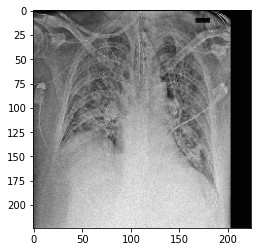

In [35]:
nameOfExperiment = "NuovoTest_Not_Kfold"
checkpointPath = Path('../../Outputs/COVID/LR/'+nameOfExperiment+'/CHECKPOINTS/')
graphPath = Path('../../Outputs/COVID/LR/'+nameOfExperiment+'/GRAPHS/')
pathSavedModel = Path('../../Outputs/COVID/LR/'+nameOfExperiment+'/MODELS-PB/')
plotpath = Path('../../Outputs/COVID/LR/'+nameOfExperiment+'/PLTS/')
evalspath = Path('../../Outputs/COVID/LR/'+nameOfExperiment+'/EVALUATIONS/')

checkpointPath.mkdir(parents=True, exist_ok=True)
graphPath.mkdir(parents=True, exist_ok=True)
pathSavedModel.mkdir(parents=True, exist_ok=True)
plotpath.mkdir(parents=True, exist_ok=True)
evalspath.mkdir(parents=True, exist_ok=True)



from sklearn.model_selection import StratifiedKFold, KFold

kf = KFold(n_splits=10, shuffle=True, random_state=SEED)

foldToCalculate = 0
trainFold = []
valFold = []

for i, (train_index, val_index) in enumerate(kf.split(X_full)):
    if i == foldToCalculate:
        trainFold = train_index
        valFold = val_index


X_train = X_full.iloc[trainFold]
X_val = X_full.iloc[valFold]
Y_train = Y_full.iloc[trainFold]
Y_val = Y_full.iloc[valFold]


# search all feature that are numeric
nameColsNumber = list(X_full.select_dtypes(exclude=['string','object','bool','datetime']).columns)

# Generates the mean of the column and change NAN values with the mean of the column
X_train = meanOfCol(X_train,nameColsNumber)
X_val = meanOfCol(X_val,nameColsNumber)






print( "training: "+str(Y_train.shape))
print( "validation: "+str(Y_val.shape))
# NO CROP
print('TRAIN')
class1 = Y_train.sum()[0]
print('MILD: ' + str(class1))
class2 = Y_train.sum()[1]
print('SEVERE: ' + str(class2))
total = Y_train.sum().sum()
print('total errors: ' + str(total))


# Y_tr_unc = np.zeros((Y_train.shape[0],2,5)) 
# print('uncertanty shape training: ' + str(Y_tr_unc.shape))
# Y_val_unc = np.zeros((Y_val.shape[0],2,5)) 
# print('uncertanty shape validation: ' + str(Y_val_unc.shape))


# X_train_IMGS = loadPNGtoArrayNoDicom(X_train['ImageFile'][:10],basePath=databasePathIMAGES)
# X_val_IMGS = loadPNGtoArrayNoDicom(X_val['ImageFile'][:3],basePath=databasePathIMAGES)
# Y_train = Y_train[:10]
# Y_val = Y_val[:3]


X_train_IMGS = loadPNGtoArrayNoDicom(X_train['ImageFile'],basePath=databasePathIMAGES)
X_val_IMGS = loadPNGtoArrayNoDicom(X_val['ImageFile'],basePath=databasePathIMAGES)
# Y_train = Y_train
# Y_val = Y_val




# X_train_IMGS = loadPNGtoArrayNoDicom(X_train['ImageFile'],basePath=databasePathIMAGES)
# X_val_IMGS = loadPNGtoArrayNoDicom(X_val['ImageFile'],basePath=databasePathIMAGES)
print(X_train_IMGS.shape)
print(X_val_IMGS.shape)
plt.figure()
plt.imshow(X_val_IMGS[2])



In [36]:
X_full.head()

,ImageFile,Age,Sex,Positivity at admission,Temp_C,DaysFever,Cough,DifficultyInBreathing,Therapy_anti-inflammatory,Therapy_Tocilizumab,...,Chronic Kidney disease,RespiratoryFailure,Obesity,Position,Hospital-A,Hospital-B,Hospital-C,Hospital-D,Hospital-E,Hospital-F
0,a987bf874b9bf185714a47a3ca526cde01909f182db0a8...,46.0,1,1.0,NaN,3.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,d0b85929c67c0cc4c9ec1b575fd38528fc54866ef40c66...,69.0,0,1.0,37.7,NaN,0.0,0.0,0.0,0.0,...,0.0,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,32015df154187a5a5544f8f863eacbf61fbfe12d130dd8...,47.0,1,1.0,NaN,2.0,1.0,0.0,0.0,0.0,...,0.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,f4fbdd06f358873f3c5a2bf3c3144c6f406e46ba8f6dbc...,68.0,1,1.0,39.8,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,8918c72266726a30ce36d65bc774b0e188a2dc48584af0...,70.0,1,1.0,38.5,4.0,0.0,0.0,1.0,0.0,...,0.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [37]:
X_train.head()

,ImageFile,Age,Sex,Positivity at admission,Temp_C,DaysFever,Cough,DifficultyInBreathing,Therapy_anti-inflammatory,Therapy_Tocilizumab,...,Chronic Kidney disease,RespiratoryFailure,Obesity,Position,Hospital-A,Hospital-B,Hospital-C,Hospital-D,Hospital-E,Hospital-F
0,a987bf874b9bf185714a47a3ca526cde01909f182db0a8...,46.0,1,1.0,37.560895,3.000000,1.0,1.0,0.0,0.0,...,0.0,0.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,d0b85929c67c0cc4c9ec1b575fd38528fc54866ef40c66...,69.0,0,1.0,37.700000,2.726452,0.0,0.0,0.0,0.0,...,0.0,1.0,0.106339,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,32015df154187a5a5544f8f863eacbf61fbfe12d130dd8...,47.0,1,1.0,37.560895,2.000000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.106339,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,f4fbdd06f358873f3c5a2bf3c3144c6f406e46ba8f6dbc...,68.0,1,1.0,39.800000,1.000000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.106339,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,8918c72266726a30ce36d65bc774b0e188a2dc48584af0...,70.0,1,1.0,38.500000,4.000000,0.0,0.0,1.0,0.0,...,0.0,0.0,0.106339,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [38]:
X_train = X_train.drop('ImageFile', axis='columns')
X_val = X_val.drop('ImageFile', axis='columns')

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns,index=X_train.index)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns,index=X_val.index)

In [39]:
X_train.head()

,Age,Sex,Positivity at admission,Temp_C,DaysFever,Cough,DifficultyInBreathing,Therapy_anti-inflammatory,Therapy_Tocilizumab,Therapy_Anakinra,...,Chronic Kidney disease,RespiratoryFailure,Obesity,Position,Hospital-A,Hospital-B,Hospital-C,Hospital-D,Hospital-E,Hospital-F
0,0.345679,1.0,1.0,0.354245,0.750000,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.629630,0.0,1.0,0.377049,0.681613,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.106339,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.358025,1.0,1.0,0.354245,0.500000,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.106339,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.617284,1.0,1.0,0.721311,0.250000,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.106339,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.641975,1.0,1.0,0.508197,1.000000,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.106339,1.0,0.0,0.0,0.0,0.0,0.0,1.0


### ADDESTRAMENTO

In [40]:

# trainset = tf.data.Dataset.from_tensor_slices((X_train_IMGS, [Y_train,Y_tr_unc]))
# trainset = trainset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
# trainset = trainset.batch(batch_size)
# trainset.prefetch(buffer_size=AUTOTUNE)


# validset = tf.data.Dataset.from_tensor_slices((X_val_IMGS, [Y_val,Y_val_unc]))
# validset = validset.batch(batch_size)
# validset.prefetch(buffer_size=AUTOTUNE)

In [41]:

# lrates = []

# def step_decay(epoch):
#     return lrate



In [42]:
# print(trainset)
# print(np.ceil(X_train_IMGS.shape[0]/batch_size))

In [43]:
def changeModelLayers(model, addname):
    for layer in model.layers:
        layer._name = layer.name + str(addname)
    return model

### addestramento multilayer fusion

In [ ]:
MlFFU = DSfusionDecisionsML((IMAGE_SIZE[0],IMAGE_SIZE[1],3))

plot_model(MlFFU, to_file=plotpath / Path('ML_DF_U.png'), show_shapes=True, show_layer_names=True)



# initial_learning_rate = 1.5e-5      # NON VA BENE
# initial_learning_rate = 1.5e-4      #acc 0.66
initial_learning_rate = 1e-3  # migliore come accuracy massima  0.69

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=100, decay_rate=0.98, staircase=False)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=100, decay_rate=0.95, staircase=False)
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=np.ceil(X_train_IMGS.shape[0]/batch_size), decay_rate=0.99, staircase=False)
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=np.ceil((X_train_IMGS.shape[0]/batch_size)/2), decay_rate=0.99, staircase=True)
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=np.ceil((X_train_IMGS.shape[0]/batch_size)), decay_rate=0.99, staircase=True)
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=300, decay_rate=0.99, staircase=False)
    

MlFFU.compile(
        # optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-2, decay=1e-4),   #FUSION 2022
        optimizer=tf.keras.optimizers.Adam(lr_schedule),
        # optimizer=tf.keras.optimizers.Adam(0.0011),
        # optimizer = tf.keras.optimizers.Adam(1e-2),
        # optimizer=tf.keras.optimizers.Adam(1.1e-3),
        loss="categorical_crossentropy",
        # loss="categorical_crossentropy",
        # metrics=["accuracy",dice_coef,"categorical_accuracy"],
        # metrics=["categorical_accuracy",tfa.metrics.F1Score(average='macro',num_classes=4)],
        metrics=["categorical_accuracy",tfa.metrics.F1Score(average='macro',num_classes=2)],
        # metrics=["categorical_accuracy"],
)
# CREATE CALLBACKS
checkpointClassification = tf.keras.callbacks.ModelCheckpoint(
                        checkpointPath / Path('ML_DF_U_Classification_acc'),
                        monitor='val_categorical_accuracy', verbose=0, 
                        # monitor='val_dm_pignistic_16_categorical_accuracy', verbose=0, 
                        save_best_only=True, mode='max')
                                                # CREATE CALLBACKS


checkpointClassificationF1 = tf.keras.callbacks.ModelCheckpoint(
                        checkpointPath / Path('ML_DF_U_Classification_F1'), 
                        monitor='val_f1_score', verbose=0, 
                        save_best_only=True, mode='max')
                                                # CREATE CALLBACKS

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)


    
lr_finder = LRFinder(min_lr=1e-3,
                     max_lr=1e-3*9,
                             steps_per_epoch=np.ceil(X_train_IMGS.shape[0]/batch_size), 
                             epochs=10)


schedule_lr = SGDRScheduler(min_lr=0.0009,
                                max_lr=0.01,
                                steps_per_epoch=np.ceil(X_train_IMGS.shape[0]/batch_size),
                                lr_decay=0.8,
                                cycle_length=10,
                                mult_factor=3.5)


    
# lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)


cb = TimingCallback()

print(checkpointPath / Path('resnet_Classification_acc'))

# callbacks_list = [checkpointClassification]
# callbacks_list = [checkpointClassification, checkpointClassificationF1, earlyStopping, cb, schedule_lr,lrate]
# callbacks_list = [checkpointClassification, checkpointClassificationF1, earlyStopping, cb, schedule_lr]
# callbacks_list = [checkpointClassification, checkpointClassificationF1, cb, schedule_lr]
callbacks_list = [checkpointClassification, checkpointClassificationF1, cb]
# callbacks_list = [checkpointClassification, cb]
# callbacks_list = [checkpointClassification, checkpointClassificationF1, earlyStopping, cb]
# callbacks_list = [checkpointClassificationF1, earlyStopping]

history = MlFFU.fit(
        # x = X_train_IMGS,
        # trainset,
        x = X_train_IMGS,
        # y = [Y_train,Y_tr_unc],
        y = Y_train,
        # epochs = 1,
        epochs = 500,
        validation_data = [X_val_IMGS,Y_val],
        # validation_data = [X_val_IMGS,[Y_val,Y_val_unc]],
        # validation_data = validset,
        callbacks = callbacks_list,    #some problems with DS layers and callbacks
        batch_size=32,
        # batch_size=1,
        # class_weight=c_w,
)

(None, 224, 224, 3)
(None, 112, 112, 16)
(None, 56, 56, 32)
(None, 56, 56, 32)
(None, 56, 56, 32)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(None, 1, 2)
(None, 2)
..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\resnet_Classification_acc
Epoch 1/500
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
32/32 [==============================] - ETA: 0s - loss: 1.4788 - categorical_accuracy: 0.5025 - f1_score: 0.3960(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(N

(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\ML_DF_U_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\ML_DF_U_Classification_acc\assets


(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\ML_DF_U_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\ML_DF_U_Classification_F1\assets


32/32 [==============================] - 15s 345ms/step - loss: 1.4788 - categorical_accuracy: 0.5025 - f1_score: 0.3960 - val_loss: 1.4700 - val_categorical_accuracy: 0.3545 - val_f1_score: 0.2617
Epoch 2/500
32/32 [==============================] - 1s 25ms/step - loss: 1.2352 - categorical_accuracy: 0.5005 - f1_score: 0.3371 - val_loss: 1.3932 - val_categorical_accuracy: 0.3545 - val_f1_score: 0.2617
Epoch 3/500
32/32 [==============================] - 1s 19ms/step - loss: 1.1784 - categorical_accuracy: 0.4955 - f1_score: 0.4370 - val_loss: 1.2675 - val_categorical_accuracy: 0.3545 - val_f1_score: 0.2617
Epoch 4/500
32/32 [==============================] - 1s 20ms/step - loss: 1.1386 - categorical_accuracy: 0.5307 - f1_score: 0.5248 - val_loss: 1.1502 - val_categorical_accuracy: 0.3545 - val_f1_score: 0.2617
Epoch 5/500
31/32 [============================>.] - ETA: 0s - loss: 1.1501 - categorical_accuracy: 0.5010 - f1_score: 0.4992(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None,

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\ML_DF_U_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\ML_DF_U_Classification_acc\assets


(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\ML_DF_U_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\ML_DF_U_Classification_F1\assets


32/32 [==============================] - 10s 324ms/step - loss: 1.1502 - categorical_accuracy: 0.5005 - f1_score: 0.4987 - val_loss: 1.1317 - val_categorical_accuracy: 0.6273 - val_f1_score: 0.4273
Epoch 6/500
31/32 [============================>.] - ETA: 0s - loss: 1.1457 - categorical_accuracy: 0.5161 - f1_score: 0.4876(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\ML_DF_U_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\ML_DF_U_Classification_acc\assets


32/32 [==============================] - 5s 166ms/step - loss: 1.1457 - categorical_accuracy: 0.5156 - f1_score: 0.4871 - val_loss: 1.0939 - val_categorical_accuracy: 0.6455 - val_f1_score: 0.3923
Epoch 7/500
32/32 [==============================] - 1s 23ms/step - loss: 1.1534 - categorical_accuracy: 0.5096 - f1_score: 0.4717 - val_loss: 1.0956 - val_categorical_accuracy: 0.6455 - val_f1_score: 0.3923
Epoch 8/500
32/32 [==============================] - 1s 19ms/step - loss: 1.1296 - categorical_accuracy: 0.5478 - f1_score: 0.5465 - val_loss: 1.1037 - val_categorical_accuracy: 0.6455 - val_f1_score: 0.3923
Epoch 9/500
32/32 [==============================] - 1s 19ms/step - loss: 1.1337 - categorical_accuracy: 0.5378 - f1_score: 0.5318 - val_loss: 1.3909 - val_categorical_accuracy: 0.6455 - val_f1_score: 0.3923
Epoch 10/500
32/32 [==============================] - 1s 20ms/step - loss: 1.1282 - categorical_accuracy: 0.5519 - f1_score: 0.5341 - val_loss: 1.2548 - val_categorical_accuracy: 

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\ML_DF_U_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\ML_DF_U_Classification_F1\assets


32/32 [==============================] - 5s 165ms/step - loss: 1.1223 - categorical_accuracy: 0.5549 - f1_score: 0.5479 - val_loss: 4.4458 - val_categorical_accuracy: 0.4818 - val_f1_score: 0.4797
Epoch 12/500
32/32 [==============================] - 1s 23ms/step - loss: 1.1521 - categorical_accuracy: 0.5327 - f1_score: 0.5266 - val_loss: 1.5280 - val_categorical_accuracy: 0.6455 - val_f1_score: 0.3923
Epoch 13/500
32/32 [==============================] - 1s 21ms/step - loss: 1.1166 - categorical_accuracy: 0.5529 - f1_score: 0.5527 - val_loss: 1.4056 - val_categorical_accuracy: 0.6455 - val_f1_score: 0.3923
Epoch 14/500
32/32 [==============================] - 1s 20ms/step - loss: 1.1217 - categorical_accuracy: 0.5257 - f1_score: 0.4896 - val_loss: 6.1428 - val_categorical_accuracy: 0.3636 - val_f1_score: 0.2774
Epoch 15/500
32/32 [==============================] - 1s 20ms/step - loss: 1.1184 - categorical_accuracy: 0.5277 - f1_score: 0.5105 - val_loss: 5.9024 - val_categorical_accurac

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\ML_DF_U_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\ML_DF_U_Classification_F1\assets


32/32 [==============================] - 5s 167ms/step - loss: 1.0762 - categorical_accuracy: 0.5831 - f1_score: 0.5772 - val_loss: 3.7962 - val_categorical_accuracy: 0.5727 - val_f1_score: 0.5453
Epoch 64/500
32/32 [==============================] - 1s 25ms/step - loss: 1.0794 - categorical_accuracy: 0.5811 - f1_score: 0.5750 - val_loss: 5.8919 - val_categorical_accuracy: 0.3727 - val_f1_score: 0.3107
Epoch 65/500
32/32 [==============================] - 1s 20ms/step - loss: 1.0672 - categorical_accuracy: 0.6073 - f1_score: 0.6065 - val_loss: 5.9855 - val_categorical_accuracy: 0.3727 - val_f1_score: 0.3021
Epoch 66/500
32/32 [==============================] - 1s 20ms/step - loss: 1.0732 - categorical_accuracy: 0.5891 - f1_score: 0.5812 - val_loss: 5.8908 - val_categorical_accuracy: 0.3636 - val_f1_score: 0.2964
Epoch 67/500
32/32 [==============================] - 1s 19ms/step - loss: 1.0694 - categorical_accuracy: 0.5861 - f1_score: 0.5844 - val_loss: 5.9859 - val_categorical_accurac

In [ ]:
print(cb.logs)
print(sum(cb.logs))
with open(str(evalspath) + 'ML_DF_U_TRAINING_TIME.txt', 'w') as f:
    f.write('Training Time for feature fusion'+'\n\n')
    f.write('TRAINING TIMES: '+'\n')
    ep = 0
    for t in cb.logs:
        ep = ep + 1
        f.write('Epoch: ' + str(ep) + ' >>> '+' time: ' + str(t) + '\n')
    f.write('\n\n')
    f.write('TRAINING TIME SUM: '+'\n')
    f.write('\n\n')
    f.write(str(sum(cb.logs)))

[14.703890800000003, 1.0069823999999983, 0.6218789999999927, 0.6296227999999928, 10.065035999999992, 5.361273600000004, 0.8302711999999985, 0.6190347000000003, 0.6187005999999968, 0.6298341000000107, 5.147708100000003, 0.7665519999999901, 0.659836900000002, 0.629547500000001, 0.6357748000000072, 0.6304295999999994, 0.6418180999999947, 0.6271935999999982, 0.6218489000000034, 0.6217108000000025, 0.6169158999999951, 0.6131697000000003, 0.6317272000000003, 0.6156912000000005, 0.6211623000000088, 0.6260998000000058, 0.6473134000000016, 0.6160548000000006, 0.6268303000000088, 0.6392414000000031, 0.6272115999999954, 0.6290851999999916, 0.6368634999999898, 0.6222153000000077, 0.633775, 0.6341922000000011, 0.6478275999999994, 0.6274185999999986, 0.6346276999999958, 0.6386159000000049, 0.6339949000000047, 0.6450899999999962, 0.6421407999999929, 0.6289560999999964, 0.627363900000006, 0.6234036999999972, 0.6392905999999954, 0.6216995999999995, 0.6199354999999969, 0.6373861000000147, 0.636418200000

In [ ]:
#PLOT HISTORY
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['loss'],
                    name='Train loss'))
fig.add_trace(go.Scatter(
                    y=history.history['val_loss'],
                    name='Validation loss'))
fig.update_layout(height=500, 
                width=700,
                title='END 2 END Loss CNN',
                xaxis_title='Epoch',
                yaxis_title='Loss')
fig.show()
plotly_plot(fig, filename=str(Path(graphPath / Path("training ML_df_U loss.html"))), auto_open=False)


fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['categorical_accuracy'],
                    name='Train accuracy'))
fig.add_trace(go.Scatter(
                    y=history.history['val_categorical_accuracy'],
                    name='Validation accuracy'))

fig.update_layout(height=500, 
                width=700,
                title='END 2 END Accuracy CNN',
                xaxis_title='Epoch',
                yaxis_title='Accuracy')
fig.show()
plotly_plot(fig, filename=str(Path(graphPath / Path("training ML_df_U accuracy.html"))), auto_open=False)

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['f1_score'],
                    name='Train F1 score'))
fig.add_trace(go.Scatter(
                    y=history.history['val_f1_score'],
                    name='Validation F1 score'))

fig.update_layout(height=500, 
                width=700,
                title='END 2 END Accuracy CNN',
                xaxis_title='Epoch',
                yaxis_title='F1 score')
fig.show()
plotly_plot(fig, filename=str(Path(graphPath / Path("training ML_df_U F1 score.html"))), auto_open=False)


'..\\..\\Outputs\\COVID\\LR\\NuovoTest_Not_Kfold\\GRAPHS\\training ML_df_U F1 score.html'

<Figure size 432x288 with 0 Axes>

In [ ]:

## EVALUATION
gc.collect()

bestPt = checkpointPath / Path('ML_DF_U_Classification_F1')
model = tf.keras.models.load_model(bestPt)

print("Ground truth of the validation")

evaluation = model.evaluate(x = X_val_IMGS, y = Y_val)
prediction = model.predict(X_val_IMGS)

ypreds = np.argmax(prediction, axis=1)
yground = np.argmax(Y_val.to_numpy(), axis=1)
# yground = np.argmax(targets, axis=1)

print(ypreds)
print(yground)



score = accuracy_score(yground, ypreds)
print('accuracy: ', score)

loss = log_loss(yground, prediction)
print('log_loss: ', loss)

# Print the confusion matrix
cmatrix = confusion_matrix(yground, ypreds)
print(cmatrix)

# Print the precision and recall, among other metrics
creport = classification_report(yground, ypreds, digits=5)
print(creport)


evaluation = dict(zip(model.metrics_names,evaluation))

# FF_f1_values.append(evaluation['f1_score'])



print(evaluation)
with open(str(evalspath) + 'ML_DF_U_F1_EVALUATION.txt', 'w') as f:
    f.write('CNN FUSION BY DS TR: 80 VAL: 20'+'\n\n')
    for k, v in evaluation.items():
        f.write(str(k) + ' >>> '+ str(v) + '\n\n')
    f.write('CNN FUSION BY DS TR: 80 VAL: 20'+'\n\n')
    f.write('SKLEARN METRICS:')
    f.write(str('Loss') + ' >>> '+ str(loss) + '\n\n')
    f.write(str('Accuracy') + ' >>> '+ str(score) + '\n\n')
    f.write(str('Confusion Matrix') + ' >>> \n'+ str(cmatrix) + '\n\n')
    f.write(str('CLASSIFICATION REPORT WITH CLASSES') + ' >>> \n'+ str(creport) + '\n\n')




bestPt = checkpointPath / Path('ML_DF_U_Classification_acc')
model = tf.keras.models.load_model(bestPt)

print("Ground truth of the validation")

evaluation = model.evaluate(x = X_val_IMGS, y = Y_val)
prediction = model.predict(X_val_IMGS)

ypreds = np.argmax(prediction, axis=1)
yground = np.argmax(Y_val.to_numpy(), axis=1)
# yground = np.argmax(targets, axis=1)

print(ypreds)
print(yground)



score = accuracy_score(yground, ypreds)
print('accuracy: ', score)

loss = log_loss(yground, prediction)
print('log_loss: ', loss)


# Print the confusion matrix
cmatrix = confusion_matrix(yground, ypreds)
print(cmatrix)

# Print the precision and recall, among other metrics
creport = classification_report(yground, ypreds, digits=5)
print(creport)


# FF_accuracy_values.append(score)

evaluation = dict(zip(model.metrics_names,evaluation))
print(evaluation)
with open(str(evalspath) + 'ML_DF_U_acc_EVALUATION.txt', 'w') as f:
    f.write('CNN FUSION BY DS TR: 80 VAL: 20'+'\n\n')
    for k, v in evaluation.items():
        f.write(str(k) + ' >>> '+ str(v) + '\n\n')
    f.write('CNN FUSION BY DS TR: 80 VAL: 20'+'\n\n')
    f.write('SKLEARN METRICS:')
    f.write(str('Loss') + ' >>> '+ str(loss) + '\n\n')
    f.write(str('Accuracy') + ' >>> '+ str(score) + '\n\n')
    f.write(str('Confusion Matrix') + ' >>> \n'+ str(cmatrix) + '\n\n')
    f.write(str('CLASSIFICATION REPORT WITH CLASSES') + ' >>> \n'+ str(creport) + '\n\n')

(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
Ground truth of the validation
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
4/4 [==============================] - 0s 12ms/step - loss: 3.7962 - categorical_accuracy: 0.5727 - f1_score: 0.5453
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
4/4 [==============================] - 0s 12ms/step
[1 0 1 0 1 0 1 0 1 1 1 1 0 0 1 1 0 1 1 0 1 0 0 1 1 1 0 1 1 1 1 1 1 0 0 1 0
 0 1 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 1 0 0 0 1 1 0 1 0 1
 1 1 1 1 1 0 1 1 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 0 1 0]
[0 1 0 0 1 1 1 1 1 1 0 0 0 0 1 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1
 1 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 0 0 1 1 1 0 1 0
 1 1 0 1 1 0 1 1 0 0 1 0 1 0 1 0 0 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 0 0 0 1]
accuracy:  0.5727272727272728
log_loss:  8.579599094390868
[[18 21]
 [26 45]]
              precision    recall  f1-score   support

           0    0.40909 

c:\Users\Michele\anaconda3\envs\tfNew2023_2\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Michele\anaconda3\envs\tfNew2023_2\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Michele\anaconda3\envs\tfNew2023_2\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



### addestramento EfficientNet

In [41]:
import efficientnet.tfkeras as efn

In [122]:
def efficientnetCreate(inputShape):
        # inputs = layers.Input(shape=(inputShape[0], inputShape[1], 3))
        efficientnet = efn.EfficientNetB1(weights='imagenet', include_top=False, input_shape=(inputShape[0], inputShape[1], 3))
        # efficientnet = tf.keras.applications.efficientnet_v2.EfficientNetV2L(
        #     include_top=False,
        #     input_tensor=inputs,
        #     weights='imagenet',
        # )

        # Freeze the pretrained weights
        efficientnet.trainable = False
        # Rebuild top
        x = layers.GlobalAveragePooling2D(name="avg_pool")(efficientnet.output)
        x = layers.BatchNormalization()(x)
        top_dropout_rate = 0.4
        x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
        x = layers.Dense(512, activation="relu")(x)
        x = layers.Dropout(top_dropout_rate)(x)
        x = layers.Dense(128, activation="relu")(x)
        # x = layers.Dropout(top_dropout_rate)(x)
        x = layers.Dense(16, activation="relu")(x)
        x = layers.Dense(4, activation="relu")(x)
        outputs = layers.Dense(2, activation="sigmoid", name="pred")(x)

        efficientnet = tf.keras.Model(efficientnet.input, outputs, name="EfficientNet")

        return efficientnet

In [126]:
efficientnet = efficientnetCreate(IMAGE_SIZE)

plot_model(efficientnet, to_file=plotpath / Path('efficientnet.png'), show_shapes=True, show_layer_names=True)



# initial_learning_rate = 1.5e-5      # NON VA BENE
# initial_learning_rate = 1.5e-4      #acc 0.66
initial_learning_rate = 1e-5  # migliore come accuracy massima  0.69

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=100, decay_rate=0.98, staircase=False)
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=100, decay_rate=0.95, staircase=False)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=200, decay_rate=0.99, staircase=False)
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=np.ceil(X_train_IMGS.shape[0]/batch_size), decay_rate=0.99, staircase=False)
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=np.ceil((X_train_IMGS.shape[0]/batch_size)/2), decay_rate=0.99, staircase=True)
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=np.ceil((X_train_IMGS.shape[0]/batch_size)), decay_rate=0.99, staircase=True)
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=300, decay_rate=0.99, staircase=False)
    

efficientnet.compile(
        # optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-2, decay=1e-4),   #FUSION 2022
        optimizer=tf.keras.optimizers.Adam(lr_schedule),
        # optimizer=tf.keras.optimizers.Adam(0.0011),
        # optimizer = tf.keras.optimizers.Adam(1e-2),
        # optimizer=tf.keras.optimizers.Adam(1.1e-3),
        loss="binary_crossentropy",
        # loss="categorical_crossentropy",
        # metrics=["accuracy",dice_coef,"categorical_accuracy"],
        # metrics=["categorical_accuracy",tfa.metrics.F1Score(average='macro',num_classes=4)],
        metrics=["binary_accuracy",tfa.metrics.F1Score(average='macro',num_classes=2)],
        # metrics=["categorical_accuracy"],
)
# CREATE CALLBACKS
checkpointClassification = tf.keras.callbacks.ModelCheckpoint(
                        checkpointPath / Path('efficientnet_Classification_acc'),
                        monitor='val_binary_accuracy', verbose=0, 
                        # monitor='val_dm_pignistic_16_categorical_accuracy', verbose=0, 
                        save_best_only=True, mode='max')
                                                # CREATE CALLBACKS


checkpointClassificationF1 = tf.keras.callbacks.ModelCheckpoint(
                        checkpointPath / Path('efficientnet_Classification_F1'), 
                        monitor='val_f1_score', verbose=0, 
                        save_best_only=True, mode='max')
                                                # CREATE CALLBACKS

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)


    
lr_finder = LRFinder(min_lr=1e-3,
                     max_lr=1e-3*9,
                             steps_per_epoch=np.ceil(X_train_IMGS.shape[0]/batch_size), 
                             epochs=10)


schedule_lr = SGDRScheduler(min_lr=0.0009,
                                max_lr=0.01,
                                steps_per_epoch=np.ceil(X_train_IMGS.shape[0]/batch_size),
                                lr_decay=0.8,
                                cycle_length=10,
                                mult_factor=3.5)


    
# lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)


cb = TimingCallback()

print(checkpointPath / Path('efficientnet'))

# callbacks_list = [checkpointClassification]
# callbacks_list = [checkpointClassification, checkpointClassificationF1, earlyStopping, cb, schedule_lr,lrate]
# callbacks_list = [checkpointClassification, checkpointClassificationF1, earlyStopping, cb, schedule_lr]
# callbacks_list = [checkpointClassification, checkpointClassificationF1, cb, schedule_lr]
callbacks_list = [checkpointClassification, checkpointClassificationF1, cb]
# callbacks_list = [checkpointClassification, cb]
# callbacks_list = [checkpointClassification, checkpointClassificationF1, earlyStopping, cb]
# callbacks_list = [checkpointClassificationF1, earlyStopping]

history = efficientnet.fit(
        # x = X_train_IMGS,
        # trainset,
        x = X_train_IMGS,
        # y = [Y_train,Y_tr_unc],
        y = Y_train,
        # epochs = 1,
        epochs = 500,
        validation_data = [X_val_IMGS,Y_val],
        # validation_data = [X_val_IMGS,[Y_val,Y_val_unc]],
        # validation_data = validset,
        callbacks = callbacks_list,    #some problems with DS layers and callbacks
        batch_size=32,
        # batch_size=1,
        # class_weight=c_w,
)

..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet
Epoch 1/500
 5/31 [===>..........................] - ETA: 0s - loss: 0.9666 - binary_accuracy: 0.4938 - f1_score: 0.3305WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0156s vs `on_train_batch_end` time: 0.0447s). Check your callbacks.


31/31 [==============================] - ETA: 0s - loss: 0.9770 - binary_accuracy: 0.4849 - f1_score: 0.3265

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


31/31 [==============================] - 32s 974ms/step - loss: 0.9770 - binary_accuracy: 0.4849 - f1_score: 0.3265 - val_loss: 0.7038 - val_binary_accuracy: 0.4865 - val_f1_score: 0.3273
Epoch 2/500
31/31 [==============================] - 1s 35ms/step - loss: 0.9067 - binary_accuracy: 0.4849 - f1_score: 0.3265 - val_loss: 0.6993 - val_binary_accuracy: 0.4865 - val_f1_score: 0.3273
Epoch 3/500
31/31 [==============================] - 1s 35ms/step - loss: 0.8672 - binary_accuracy: 0.4859 - f1_score: 0.3287 - val_loss: 0.6983 - val_binary_accuracy: 0.4865 - val_f1_score: 0.3273
Epoch 4/500
31/31 [==============================] - 1s 35ms/step - loss: 0.8270 - binary_accuracy: 0.4849 - f1_score: 0.3265 - val_loss: 0.6980 - val_binary_accuracy: 0.4865 - val_f1_score: 0.3273
Epoch 5/500
31/31 [==============================] - 1s 35ms/step - loss: 0.8125 - binary_accuracy: 0.4859 - f1_score: 0.3287 - val_loss: 0.6979 - val_binary_accuracy: 0.4865 - val_f1_score: 0.3273
Epoch 6/500
31/31 [=

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


31/31 [==============================] - 15s 483ms/step - loss: 0.7383 - binary_accuracy: 0.4869 - f1_score: 0.3371 - val_loss: 0.6892 - val_binary_accuracy: 0.4595 - val_f1_score: 0.3286
Epoch 16/500
31/31 [==============================] - ETA: 0s - loss: 0.7333 - binary_accuracy: 0.4808 - f1_score: 0.3335

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


31/31 [==============================] - 15s 481ms/step - loss: 0.7333 - binary_accuracy: 0.4808 - f1_score: 0.3335 - val_loss: 0.6877 - val_binary_accuracy: 0.4775 - val_f1_score: 0.3633
Epoch 17/500
31/31 [==============================] - ETA: 0s - loss: 0.7140 - binary_accuracy: 0.4904 - f1_score: 0.3471

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


31/31 [==============================] - 29s 959ms/step - loss: 0.7140 - binary_accuracy: 0.4904 - f1_score: 0.3471 - val_loss: 0.6864 - val_binary_accuracy: 0.5045 - val_f1_score: 0.4217
Epoch 18/500
31/31 [==============================] - ETA: 0s - loss: 0.7146 - binary_accuracy: 0.4904 - f1_score: 0.3502

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


31/31 [==============================] - 29s 956ms/step - loss: 0.7146 - binary_accuracy: 0.4904 - f1_score: 0.3502 - val_loss: 0.6851 - val_binary_accuracy: 0.5180 - val_f1_score: 0.4367
Epoch 19/500
31/31 [==============================] - ETA: 0s - loss: 0.7104 - binary_accuracy: 0.4970 - f1_score: 0.3703

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


31/31 [==============================] - 30s 975ms/step - loss: 0.7104 - binary_accuracy: 0.4970 - f1_score: 0.3703 - val_loss: 0.6844 - val_binary_accuracy: 0.5405 - val_f1_score: 0.4795
Epoch 20/500
31/31 [==============================] - ETA: 0s - loss: 0.7206 - binary_accuracy: 0.4869 - f1_score: 0.3611

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


31/31 [==============================] - 30s 986ms/step - loss: 0.7206 - binary_accuracy: 0.4869 - f1_score: 0.3611 - val_loss: 0.6842 - val_binary_accuracy: 0.5495 - val_f1_score: 0.4998
Epoch 21/500
31/31 [==============================] - 1s 36ms/step - loss: 0.7117 - binary_accuracy: 0.5005 - f1_score: 0.3719 - val_loss: 0.6837 - val_binary_accuracy: 0.5495 - val_f1_score: 0.4998
Epoch 22/500
31/31 [==============================] - ETA: 0s - loss: 0.7156 - binary_accuracy: 0.4950 - f1_score: 0.3742

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


31/31 [==============================] - 28s 936ms/step - loss: 0.7156 - binary_accuracy: 0.4950 - f1_score: 0.3742 - val_loss: 0.6836 - val_binary_accuracy: 0.5721 - val_f1_score: 0.5382
Epoch 23/500
31/31 [==============================] - 1s 36ms/step - loss: 0.7074 - binary_accuracy: 0.5000 - f1_score: 0.3843 - val_loss: 0.6832 - val_binary_accuracy: 0.5586 - val_f1_score: 0.5310
Epoch 24/500
31/31 [==============================] - 1s 35ms/step - loss: 0.7030 - binary_accuracy: 0.4980 - f1_score: 0.3826 - val_loss: 0.6825 - val_binary_accuracy: 0.5541 - val_f1_score: 0.5238
Epoch 25/500
31/31 [==============================] - 1s 35ms/step - loss: 0.6876 - binary_accuracy: 0.5035 - f1_score: 0.3855 - val_loss: 0.6820 - val_binary_accuracy: 0.5541 - val_f1_score: 0.5238
Epoch 26/500
31/31 [==============================] - 1s 35ms/step - loss: 0.6961 - binary_accuracy: 0.5045 - f1_score: 0.3982 - val_loss: 0.6817 - val_binary_accuracy: 0.5541 - val_f1_score: 0.5238
Epoch 27/500
31/

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


31/31 [==============================] - 15s 487ms/step - loss: 0.6850 - binary_accuracy: 0.5302 - f1_score: 0.4498 - val_loss: 0.6784 - val_binary_accuracy: 0.5495 - val_f1_score: 0.5405
Epoch 34/500
31/31 [==============================] - ETA: 0s - loss: 0.6912 - binary_accuracy: 0.5186 - f1_score: 0.4322

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


31/31 [==============================] - 15s 483ms/step - loss: 0.6912 - binary_accuracy: 0.5186 - f1_score: 0.4322 - val_loss: 0.6781 - val_binary_accuracy: 0.5586 - val_f1_score: 0.5515
Epoch 35/500
31/31 [==============================] - 1s 35ms/step - loss: 0.6889 - binary_accuracy: 0.5257 - f1_score: 0.4518 - val_loss: 0.6780 - val_binary_accuracy: 0.5541 - val_f1_score: 0.5437
Epoch 36/500
31/31 [==============================] - ETA: 0s - loss: 0.6874 - binary_accuracy: 0.5242 - f1_score: 0.4457

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


31/31 [==============================] - 15s 483ms/step - loss: 0.6874 - binary_accuracy: 0.5242 - f1_score: 0.4457 - val_loss: 0.6776 - val_binary_accuracy: 0.5631 - val_f1_score: 0.5545
Epoch 37/500
31/31 [==============================] - 1s 36ms/step - loss: 0.6850 - binary_accuracy: 0.5267 - f1_score: 0.4639 - val_loss: 0.6769 - val_binary_accuracy: 0.5631 - val_f1_score: 0.5466
Epoch 38/500
31/31 [==============================] - 1s 35ms/step - loss: 0.6921 - binary_accuracy: 0.5227 - f1_score: 0.4508 - val_loss: 0.6765 - val_binary_accuracy: 0.5586 - val_f1_score: 0.5466
Epoch 39/500
31/31 [==============================] - 1s 35ms/step - loss: 0.6840 - binary_accuracy: 0.5348 - f1_score: 0.4699 - val_loss: 0.6760 - val_binary_accuracy: 0.5586 - val_f1_score: 0.5466
Epoch 40/500
31/31 [==============================] - ETA: 0s - loss: 0.6806 - binary_accuracy: 0.5600 - f1_score: 0.5073

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


31/31 [==============================] - 15s 500ms/step - loss: 0.6806 - binary_accuracy: 0.5600 - f1_score: 0.5073 - val_loss: 0.6749 - val_binary_accuracy: 0.5631 - val_f1_score: 0.5572
Epoch 41/500
31/31 [==============================] - 1s 36ms/step - loss: 0.6922 - binary_accuracy: 0.5504 - f1_score: 0.4898 - val_loss: 0.6744 - val_binary_accuracy: 0.5676 - val_f1_score: 0.5572
Epoch 42/500
31/31 [==============================] - ETA: 0s - loss: 0.6844 - binary_accuracy: 0.5499 - f1_score: 0.4937

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


31/31 [==============================] - 28s 932ms/step - loss: 0.6844 - binary_accuracy: 0.5499 - f1_score: 0.4937 - val_loss: 0.6738 - val_binary_accuracy: 0.5766 - val_f1_score: 0.5676
Epoch 43/500
31/31 [==============================] - ETA: 0s - loss: 0.6833 - binary_accuracy: 0.5469 - f1_score: 0.4966

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_acc\assets


31/31 [==============================] - 15s 497ms/step - loss: 0.6833 - binary_accuracy: 0.5469 - f1_score: 0.4966 - val_loss: 0.6731 - val_binary_accuracy: 0.5811 - val_f1_score: 0.5676
Epoch 44/500
31/31 [==============================] - ETA: 0s - loss: 0.6786 - binary_accuracy: 0.5469 - f1_score: 0.4944

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


31/31 [==============================] - 15s 488ms/step - loss: 0.6786 - binary_accuracy: 0.5469 - f1_score: 0.4944 - val_loss: 0.6723 - val_binary_accuracy: 0.5811 - val_f1_score: 0.5697
Epoch 45/500
31/31 [==============================] - ETA: 0s - loss: 0.6853 - binary_accuracy: 0.5428 - f1_score: 0.4976

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


31/31 [==============================] - 29s 955ms/step - loss: 0.6853 - binary_accuracy: 0.5428 - f1_score: 0.4976 - val_loss: 0.6714 - val_binary_accuracy: 0.5901 - val_f1_score: 0.5798
Epoch 46/500
31/31 [==============================] - ETA: 0s - loss: 0.6799 - binary_accuracy: 0.5570 - f1_score: 0.5111

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


31/31 [==============================] - 29s 970ms/step - loss: 0.6799 - binary_accuracy: 0.5570 - f1_score: 0.5111 - val_loss: 0.6709 - val_binary_accuracy: 0.5991 - val_f1_score: 0.5898
Epoch 47/500
31/31 [==============================] - ETA: 0s - loss: 0.6746 - binary_accuracy: 0.5711 - f1_score: 0.5286

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


31/31 [==============================] - 29s 953ms/step - loss: 0.6746 - binary_accuracy: 0.5711 - f1_score: 0.5286 - val_loss: 0.6707 - val_binary_accuracy: 0.6126 - val_f1_score: 0.6094
Epoch 48/500
31/31 [==============================] - 1s 36ms/step - loss: 0.6760 - binary_accuracy: 0.5489 - f1_score: 0.5048 - val_loss: 0.6700 - val_binary_accuracy: 0.6126 - val_f1_score: 0.6094
Epoch 49/500
31/31 [==============================] - 1s 35ms/step - loss: 0.6828 - binary_accuracy: 0.5454 - f1_score: 0.4941 - val_loss: 0.6695 - val_binary_accuracy: 0.6126 - val_f1_score: 0.6094
Epoch 50/500
31/31 [==============================] - 1s 35ms/step - loss: 0.6740 - binary_accuracy: 0.5585 - f1_score: 0.5206 - val_loss: 0.6689 - val_binary_accuracy: 0.6126 - val_f1_score: 0.6094
Epoch 51/500
31/31 [==============================] - 1s 35ms/step - loss: 0.6741 - binary_accuracy: 0.5640 - f1_score: 0.5319 - val_loss: 0.6685 - val_binary_accuracy: 0.6126 - val_f1_score: 0.6094
Epoch 52/500
31/

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_acc\assets


31/31 [==============================] - 15s 491ms/step - loss: 0.6807 - binary_accuracy: 0.5675 - f1_score: 0.5288 - val_loss: 0.6670 - val_binary_accuracy: 0.6171 - val_f1_score: 0.6094
Epoch 54/500
30/31 [============================>.] - ETA: 0s - loss: 0.6809 - binary_accuracy: 0.5641 - f1_score: 0.5295

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


31/31 [==============================] - 28s 936ms/step - loss: 0.6812 - binary_accuracy: 0.5630 - f1_score: 0.5272 - val_loss: 0.6664 - val_binary_accuracy: 0.6306 - val_f1_score: 0.6382
Epoch 55/500
31/31 [==============================] - 1s 35ms/step - loss: 0.6665 - binary_accuracy: 0.5781 - f1_score: 0.5435 - val_loss: 0.6656 - val_binary_accuracy: 0.6306 - val_f1_score: 0.6382
Epoch 56/500
31/31 [==============================] - ETA: 0s - loss: 0.6732 - binary_accuracy: 0.5595 - f1_score: 0.5254

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_acc\assets


31/31 [==============================] - 14s 482ms/step - loss: 0.6732 - binary_accuracy: 0.5595 - f1_score: 0.5254 - val_loss: 0.6647 - val_binary_accuracy: 0.6396 - val_f1_score: 0.6382
Epoch 57/500
31/31 [==============================] - 1s 35ms/step - loss: 0.6789 - binary_accuracy: 0.5721 - f1_score: 0.5416 - val_loss: 0.6640 - val_binary_accuracy: 0.6396 - val_f1_score: 0.6382
Epoch 58/500
31/31 [==============================] - 1s 35ms/step - loss: 0.6713 - binary_accuracy: 0.5811 - f1_score: 0.5534 - val_loss: 0.6638 - val_binary_accuracy: 0.6396 - val_f1_score: 0.6382
Epoch 59/500
31/31 [==============================] - ETA: 0s - loss: 0.6712 - binary_accuracy: 0.5590 - f1_score: 0.5302

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


31/31 [==============================] - 29s 955ms/step - loss: 0.6712 - binary_accuracy: 0.5590 - f1_score: 0.5302 - val_loss: 0.6632 - val_binary_accuracy: 0.6441 - val_f1_score: 0.6476
Epoch 60/500
31/31 [==============================] - ETA: 0s - loss: 0.6773 - binary_accuracy: 0.5615 - f1_score: 0.5330

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


31/31 [==============================] - 29s 939ms/step - loss: 0.6773 - binary_accuracy: 0.5615 - f1_score: 0.5330 - val_loss: 0.6625 - val_binary_accuracy: 0.6532 - val_f1_score: 0.6570
Epoch 61/500
31/31 [==============================] - 1s 35ms/step - loss: 0.6663 - binary_accuracy: 0.5872 - f1_score: 0.5601 - val_loss: 0.6622 - val_binary_accuracy: 0.6532 - val_f1_score: 0.6476
Epoch 62/500
31/31 [==============================] - ETA: 0s - loss: 0.6701 - binary_accuracy: 0.5610 - f1_score: 0.5364

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_acc\assets


31/31 [==============================] - 15s 489ms/step - loss: 0.6701 - binary_accuracy: 0.5610 - f1_score: 0.5364 - val_loss: 0.6619 - val_binary_accuracy: 0.6577 - val_f1_score: 0.6570
Epoch 63/500
31/31 [==============================] - ETA: 0s - loss: 0.6607 - binary_accuracy: 0.5811 - f1_score: 0.5590

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


31/31 [==============================] - 29s 960ms/step - loss: 0.6607 - binary_accuracy: 0.5811 - f1_score: 0.5590 - val_loss: 0.6615 - val_binary_accuracy: 0.6667 - val_f1_score: 0.6666
Epoch 64/500
31/31 [==============================] - 1s 36ms/step - loss: 0.6635 - binary_accuracy: 0.6023 - f1_score: 0.5790 - val_loss: 0.6607 - val_binary_accuracy: 0.6622 - val_f1_score: 0.6574
Epoch 65/500
31/31 [==============================] - 1s 36ms/step - loss: 0.6636 - binary_accuracy: 0.5847 - f1_score: 0.5635 - val_loss: 0.6604 - val_binary_accuracy: 0.6622 - val_f1_score: 0.6666
Epoch 66/500
31/31 [==============================] - 1s 36ms/step - loss: 0.6691 - binary_accuracy: 0.5897 - f1_score: 0.5732 - val_loss: 0.6599 - val_binary_accuracy: 0.6622 - val_f1_score: 0.6666
Epoch 67/500
31/31 [==============================] - ETA: 0s - loss: 0.6637 - binary_accuracy: 0.5998 - f1_score: 0.5842

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


31/31 [==============================] - 15s 494ms/step - loss: 0.6637 - binary_accuracy: 0.5998 - f1_score: 0.5842 - val_loss: 0.6596 - val_binary_accuracy: 0.6667 - val_f1_score: 0.6756
Epoch 68/500
31/31 [==============================] - 1s 35ms/step - loss: 0.6595 - binary_accuracy: 0.5907 - f1_score: 0.5707 - val_loss: 0.6588 - val_binary_accuracy: 0.6667 - val_f1_score: 0.6666
Epoch 69/500
31/31 [==============================] - ETA: 0s - loss: 0.6554 - binary_accuracy: 0.5892 - f1_score: 0.5657

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_acc\assets


31/31 [==============================] - 15s 513ms/step - loss: 0.6554 - binary_accuracy: 0.5892 - f1_score: 0.5657 - val_loss: 0.6582 - val_binary_accuracy: 0.6712 - val_f1_score: 0.6756
Epoch 70/500
31/31 [==============================] - 1s 35ms/step - loss: 0.6555 - binary_accuracy: 0.6235 - f1_score: 0.6122 - val_loss: 0.6573 - val_binary_accuracy: 0.6712 - val_f1_score: 0.6754
Epoch 71/500
31/31 [==============================] - ETA: 0s - loss: 0.6546 - binary_accuracy: 0.5791 - f1_score: 0.5589

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_acc\assets


31/31 [==============================] - 15s 499ms/step - loss: 0.6546 - binary_accuracy: 0.5791 - f1_score: 0.5589 - val_loss: 0.6563 - val_binary_accuracy: 0.6757 - val_f1_score: 0.6754
Epoch 72/500
31/31 [==============================] - 1s 35ms/step - loss: 0.6545 - binary_accuracy: 0.6220 - f1_score: 0.6072 - val_loss: 0.6557 - val_binary_accuracy: 0.6757 - val_f1_score: 0.6754
Epoch 73/500
31/31 [==============================] - 1s 35ms/step - loss: 0.6579 - binary_accuracy: 0.5842 - f1_score: 0.5639 - val_loss: 0.6553 - val_binary_accuracy: 0.6757 - val_f1_score: 0.6754
Epoch 74/500
31/31 [==============================] - ETA: 0s - loss: 0.6493 - binary_accuracy: 0.6290 - f1_score: 0.6112

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_acc\assets


31/31 [==============================] - 15s 504ms/step - loss: 0.6493 - binary_accuracy: 0.6290 - f1_score: 0.6112 - val_loss: 0.6541 - val_binary_accuracy: 0.6847 - val_f1_score: 0.6750
Epoch 75/500
31/31 [==============================] - ETA: 0s - loss: 0.6553 - binary_accuracy: 0.6129 - f1_score: 0.5976

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


31/31 [==============================] - 15s 495ms/step - loss: 0.6553 - binary_accuracy: 0.6129 - f1_score: 0.5976 - val_loss: 0.6534 - val_binary_accuracy: 0.6847 - val_f1_score: 0.6843
Epoch 76/500
31/31 [==============================] - 1s 35ms/step - loss: 0.6561 - binary_accuracy: 0.6265 - f1_score: 0.6099 - val_loss: 0.6530 - val_binary_accuracy: 0.6802 - val_f1_score: 0.6843
Epoch 77/500
31/31 [==============================] - 1s 35ms/step - loss: 0.6637 - binary_accuracy: 0.6084 - f1_score: 0.5966 - val_loss: 0.6522 - val_binary_accuracy: 0.6802 - val_f1_score: 0.6754
Epoch 78/500
31/31 [==============================] - 1s 35ms/step - loss: 0.6553 - binary_accuracy: 0.6169 - f1_score: 0.6048 - val_loss: 0.6516 - val_binary_accuracy: 0.6667 - val_f1_score: 0.6754
Epoch 79/500
31/31 [==============================] - 1s 35ms/step - loss: 0.6592 - binary_accuracy: 0.5887 - f1_score: 0.5749 - val_loss: 0.6513 - val_binary_accuracy: 0.6757 - val_f1_score: 0.6756
Epoch 80/500
31/

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


31/31 [==============================] - 15s 494ms/step - loss: 0.6537 - binary_accuracy: 0.6240 - f1_score: 0.6093 - val_loss: 0.6518 - val_binary_accuracy: 0.6802 - val_f1_score: 0.6846
Epoch 81/500
31/31 [==============================] - ETA: 0s - loss: 0.6522 - binary_accuracy: 0.6129 - f1_score: 0.6059

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\efficientnet_Classification_F1\assets


31/31 [==============================] - 29s 954ms/step - loss: 0.6522 - binary_accuracy: 0.6129 - f1_score: 0.6059 - val_loss: 0.6513 - val_binary_accuracy: 0.7027 - val_f1_score: 0.7027
Epoch 82/500
31/31 [==============================] - 1s 36ms/step - loss: 0.6589 - binary_accuracy: 0.6099 - f1_score: 0.5959 - val_loss: 0.6515 - val_binary_accuracy: 0.6937 - val_f1_score: 0.6847
Epoch 83/500
31/31 [==============================] - 1s 36ms/step - loss: 0.6429 - binary_accuracy: 0.6411 - f1_score: 0.6375 - val_loss: 0.6514 - val_binary_accuracy: 0.6847 - val_f1_score: 0.6846
Epoch 84/500
31/31 [==============================] - 1s 36ms/step - loss: 0.6554 - binary_accuracy: 0.6094 - f1_score: 0.5989 - val_loss: 0.6510 - val_binary_accuracy: 0.6847 - val_f1_score: 0.6846
Epoch 85/500
31/31 [==============================] - 1s 36ms/step - loss: 0.6494 - binary_accuracy: 0.6124 - f1_score: 0.6011 - val_loss: 0.6508 - val_binary_accuracy: 0.6712 - val_f1_score: 0.6756
Epoch 86/500
31/

In [127]:
#PLOT HISTORY
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['loss'],
                    name='Train loss'))
fig.add_trace(go.Scatter(
                    y=history.history['val_loss'],
                    name='Validation loss'))
fig.update_layout(height=500, 
                width=700,
                title='END 2 END Loss EFFICIENTNET',
                xaxis_title='Epoch',
                yaxis_title='Loss')
fig.show()
plotly_plot(fig, filename=str(Path(graphPath / Path("training Efficientnet loss.html"))), auto_open=False)


fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['binary_accuracy'],
                    name='Train accuracy'))
fig.add_trace(go.Scatter(
                    y=history.history['val_binary_accuracy'],
                    name='Validation accuracy'))

fig.update_layout(height=500, 
                width=700,
                title='END 2 END Accuracy EFFICIENTNET',
                xaxis_title='Epoch',
                yaxis_title='Accuracy')
fig.show()
plotly_plot(fig, filename=str(Path(graphPath / Path("training Efficientnet accuracy.html"))), auto_open=False)

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['f1_score'],
                    name='Train F1 score'))
fig.add_trace(go.Scatter(
                    y=history.history['val_f1_score'],
                    name='Validation F1 score'))

fig.update_layout(height=500, 
                width=700,
                title='END 2 END Accuracy EFFICIENTNET',
                xaxis_title='Epoch',
                yaxis_title='F1 score')
fig.show()
plotly_plot(fig, filename=str(Path(graphPath / Path("training Efficientnet F1 score.html"))), auto_open=False)


'..\\..\\Outputs\\COVID\\LR\\NuovoTest_Not_Kfold\\GRAPHS\\training Efficientnet F1 score.html'

<Figure size 432x288 with 0 Axes>

In [129]:

## EVALUATION
gc.collect()

bestPt = checkpointPath / Path('efficientnet_Classification_F1')
model = tf.keras.models.load_model(bestPt)

print("Ground truth of the validation")

evaluation = model.evaluate(x = X_val_IMGS, y = Y_val)
prediction = model.predict(X_val_IMGS)

ypreds = np.argmax(prediction, axis=1)
yground = np.argmax(Y_val.to_numpy(), axis=1)
# yground = np.argmax(targets, axis=1)

print(ypreds)
print(yground)



score = accuracy_score(yground, ypreds)
print('accuracy: ', score)

loss = log_loss(yground, prediction)
print('log_loss: ', loss)

# Print the confusion matrix
cmatrix = confusion_matrix(yground, ypreds)
print(cmatrix)

# Print the precision and recall, among other metrics
creport = classification_report(yground, ypreds, digits=5)
print(creport)


evaluation = dict(zip(model.metrics_names,evaluation))

# FF_f1_values.append(evaluation['f1_score'])



print(evaluation)
with open(str(evalspath) + 'EFFICIENTNET_F1_EVALUATION.txt', 'w') as f:
    f.write('EFFICIENTNET FUSION BY DS TR: 80 VAL: 20'+'\n\n')
    for k, v in evaluation.items():
        f.write(str(k) + ' >>> '+ str(v) + '\n\n')
    f.write('CNN FUSION BY DS TR: 80 VAL: 20'+'\n\n')
    f.write('SKLEARN METRICS:')
    f.write(str('Loss') + ' >>> '+ str(loss) + '\n\n')
    f.write(str('Accuracy') + ' >>> '+ str(score) + '\n\n')
    f.write(str('Confusion Matrix') + ' >>> \n'+ str(cmatrix) + '\n\n')
    f.write(str('CLASSIFICATION REPORT WITH CLASSES') + ' >>> \n'+ str(creport) + '\n\n')




bestPt = checkpointPath / Path('efficientnet_Classification_acc')
model = tf.keras.models.load_model(bestPt)

print("Ground truth of the validation")

evaluation = model.evaluate(x = X_val_IMGS, y = Y_val)
prediction = model.predict(X_val_IMGS)

ypreds = np.argmax(prediction, axis=1)
yground = np.argmax(Y_val.to_numpy(), axis=1)
# yground = np.argmax(targets, axis=1)

print(ypreds)
print(yground)



score = accuracy_score(yground, ypreds)
print('accuracy: ', score)

loss = log_loss(yground, prediction)
print('log_loss: ', loss)


# Print the confusion matrix
cmatrix = confusion_matrix(yground, ypreds)
print(cmatrix)

# Print the precision and recall, among other metrics
creport = classification_report(yground, ypreds, digits=5)
print(creport)


# FF_accuracy_values.append(score)

evaluation = dict(zip(model.metrics_names,evaluation))
print(evaluation)
with open(str(evalspath) + 'EFFICIENTNET_acc_EVALUATION.txt', 'w') as f:
    f.write('EFFICIENTNET FUSION BY DS TR: 80 VAL: 20'+'\n\n')
    for k, v in evaluation.items():
        f.write(str(k) + ' >>> '+ str(v) + '\n\n')
    f.write('CNN FUSION BY DS TR: 80 VAL: 20'+'\n\n')
    f.write('SKLEARN METRICS:')
    f.write(str('Loss') + ' >>> '+ str(loss) + '\n\n')
    f.write(str('Accuracy') + ' >>> '+ str(score) + '\n\n')
    f.write(str('Confusion Matrix') + ' >>> \n'+ str(cmatrix) + '\n\n')
    f.write(str('CLASSIFICATION REPORT WITH CLASSES') + ' >>> \n'+ str(creport) + '\n\n')

Ground truth of the validation
4/4 [==============================] - 1s 27ms/step
[0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 0 1 0 1 1 0 0 1 0 0 0 0 1 0 0 1 1 1 1 0
 0 1 1 1 1 0 0 1 1 0 1 0 1 1 1 1 0 1 1 0 1 0 1 0 0 1 0 0 1 0 1 0 0 0 0 1 1
 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 1 0 0 1 1 0 1 0 1 1 0 0]
[0 0 1 0 1 0 0 0 1 1 0 1 1 1 1 0 1 0 1 1 1 0 0 0 1 1 0 1 0 1 0 0 1 1 1 1 0
 0 1 1 1 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0
 1 0 0 0 1 1 1 1 1 0 0 0 0 1 0 1 1 0 0 1 0 0 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1]
accuracy:  0.7027027027027027
log_loss:  0.649209439150385
[[39 15]
 [18 39]]
              precision    recall  f1-score   support

           0    0.68421   0.72222   0.70270        54
           1    0.72222   0.68421   0.70270        57

    accuracy                        0.70270       111
   macro avg    0.70322   0.70322   0.70270       111
weighted avg    0.70373   0.70270   0.70270       111

{'loss': 0.6512680053710938, 'binary_accuracy': 0.7027027010

### addestramento MLP (Dati Clinici)

In [40]:
def create_mlp(dim, regression=False):
    #model definition
    model = Sequential()
    model.add(Dense(16,input_dim=dim,activation='relu'))
    model.add(Dropout(0.6))
    model.add(Dense(8,activation='relu'))
    model.add(Dense(8,activation='relu'))
    model.add(Dropout(0.6))
    model.add(Dense(4,activation='relu'))
    #can continue the model

    if regression:
        model.add(Dense(2,activation='sigmoid'))
    # else:
        # model.add(Flatten())

    return model

In [41]:
mlpOnly = create_mlp(X_train.shape[1],regression=True)

plot_model(mlpOnly, to_file=plotpath / Path('MLP_only.png'), show_shapes=True, show_layer_names=True)


initial_learning_rate = 1e-3  # migliore come accuracy massima  0.69

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=100, decay_rate=0.99, staircase=False)

mlpOnly.compile(
        # optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-2, decay=1e-4),   #FUSION 2022
        optimizer=tf.keras.optimizers.Adam(lr_schedule),
        # optimizer=tf.keras.optimizers.Adam(0.0011),
        # optimizer = tf.keras.optimizers.Adam(1e-2),
        # optimizer=tf.keras.optimizers.Adam(1.1e-3),
        # loss="categorical_crossentropy",
        loss="binary_crossentropy",
        # loss="categorical_crossentropy",
        # metrics=["accuracy",dice_coef,"categorical_accuracy"],
        # metrics=["categorical_accuracy",tfa.metrics.F1Score(average='macro',num_classes=4)],
        # metrics=["categorical_accuracy",tfa.metrics.F1Score(average='macro',num_classes=2)],
        metrics=["binary_accuracy",tfa.metrics.F1Score(average='macro',num_classes=2)],
        # metrics=["categorical_accuracy"],
)
# CREATE CALLBACKS
checkpointClassification = tf.keras.callbacks.ModelCheckpoint(
                        checkpointPath / Path('MLP_Classification_acc'),
                        monitor='val_binary_accuracy', verbose=0, 
                        # monitor='val_dm_pignistic_16_categorical_accuracy', verbose=0, 
                        save_best_only=True, mode='max')
                                                # CREATE CALLBACKS


checkpointClassificationF1 = tf.keras.callbacks.ModelCheckpoint(
                        checkpointPath / Path('MLP_Classification_F1'), 
                        monitor='val_f1_score', verbose=0, 
                        save_best_only=True, mode='max')
                                                # CREATE CALLBACKS

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)

    
# lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)


cb = TimingCallback()

print(checkpointPath / Path('MLP'))

# callbacks_list = [checkpointClassification]
# callbacks_list = [checkpointClassification, checkpointClassificationF1, earlyStopping, cb, schedule_lr,lrate]
# callbacks_list = [checkpointClassification, checkpointClassificationF1, earlyStopping, cb, schedule_lr]
# callbacks_list = [checkpointClassification, checkpointClassificationF1, cb, schedule_lr]
callbacks_list = [checkpointClassification, checkpointClassificationF1, cb]
# callbacks_list = [checkpointClassification, cb]
# callbacks_list = [checkpointClassification, checkpointClassificationF1, earlyStopping, cb]
# callbacks_list = [checkpointClassificationF1, earlyStopping]

history = mlpOnly.fit(
        # x = X_train_IMGS,
        # trainset,
        x = X_train,
        # y = [Y_train,Y_tr_unc],
        y = Y_train,
        # epochs = 1,
        epochs = 1000,
        validation_data = [X_val,Y_val],
        # validation_data = [X_val_IMGS,[Y_val,Y_val_unc]],
        # validation_data = validset,
        callbacks = callbacks_list,    #some problems with DS layers and callbacks
        batch_size=32,
        # batch_size=1,
        # class_weight=c_w,
)

..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MLP
Epoch 1/1000
19/31 [=================>............] - ETA: 0s - loss: 0.7021 - binary_accuracy: 0.5123 - f1_score: 0.5226 INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MLP_Classification_acc\assets
INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MLP_Classification_F1\assets
31/31 [==============================] - 2s 36ms/step - loss: 0.6995 - binary_accuracy: 0.5126 - f1_score: 0.5110 - val_loss: 0.6925 - val_binary_accuracy: 0.5000 - val_f1_score: 0.4972
Epoch 2/1000
31/31 [==============================] - 0s 4ms/step - loss: 0.6948 - binary_accuracy: 0.4894 - f1_score: 0.4504 - val_loss: 0.6919 - val_binary_accuracy: 0.4640 - val_f1_score: 0.3393
Epoch 3/1000
31/31 [==============================] - 0s 4ms/step - loss: 0.6938 - binary_accuracy: 0.4995 - f1_score: 0.3934 - val_loss: 0.6906 - val_binary_accuracy: 0.4775 - val_f1_score: 0.339

In [42]:
#PLOT HISTORY
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['loss'],
                    name='Train loss'))
fig.add_trace(go.Scatter(
                    y=history.history['val_loss'],
                    name='Validation loss'))
fig.update_layout(height=500, 
                width=700,
                title='END 2 END Loss MLP',
                xaxis_title='Epoch',
                yaxis_title='Loss')
fig.show()
plotly_plot(fig, filename=str(Path(graphPath / Path("training MLP loss.html"))), auto_open=False)


fig = go.Figure()
fig.add_trace(go.Scatter(
                    # y=history.history['categorical_accuracy'],
                    y=history.history['binary_accuracy'],
                    name='Train accuracy'))
fig.add_trace(go.Scatter(
                    # y=history.history['val_categorical_accuracy'],
                    y=history.history['val_binary_accuracy'],
                    name='Validation accuracy'))

fig.update_layout(height=500, 
                width=700,
                title='END 2 END Accuracy MLP',
                xaxis_title='Epoch',
                yaxis_title='Accuracy')
fig.show()
plotly_plot(fig, filename=str(Path(graphPath / Path("training MLP accuracy.html"))), auto_open=False)

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['f1_score'],
                    name='Train F1 score'))
fig.add_trace(go.Scatter(
                    y=history.history['val_f1_score'],
                    name='Validation F1 score'))

fig.update_layout(height=500, 
                width=700,
                title='END 2 END Accuracy MLP',
                xaxis_title='Epoch',
                yaxis_title='F1 score')
fig.show()
plotly_plot(fig, filename=str(Path(graphPath / Path("training MLP F1 score.html"))), auto_open=False)


'..\\..\\Outputs\\COVID\\LR\\NuovoTest_Not_Kfold\\GRAPHS\\training MLP F1 score.html'

<Figure size 432x288 with 0 Axes>

In [43]:
## EVALUATION
gc.collect()

bestPt = checkpointPath / Path('MLP_Classification_F1')
model = tf.keras.models.load_model(bestPt)

print("Ground truth of the validation")

evaluation = model.evaluate(x = X_val, y = Y_val)
prediction = model.predict(X_val)

ypreds = np.argmax(prediction, axis=1)
yground = np.argmax(Y_val.to_numpy(), axis=1)
# yground = np.argmax(targets, axis=1)

print(ypreds)
print(yground)



score = accuracy_score(yground, ypreds)
print('accuracy: ', score)

loss = log_loss(yground, prediction)
print('log_loss: ', loss)

# Print the confusion matrix
cmatrix = confusion_matrix(yground, ypreds)
print(cmatrix)

# Print the precision and recall, among other metrics
creport = classification_report(yground, ypreds, digits=5)
print(creport)


evaluation = dict(zip(model.metrics_names,evaluation))

# FF_f1_values.append(evaluation['f1_score'])



print(evaluation)
with open(str(evalspath) + 'MLP_F1_EVALUATION.txt', 'w') as f:
    f.write('MLP FUSION BY DS TR: 80 VAL: 20'+'\n\n')
    for k, v in evaluation.items():
        f.write(str(k) + ' >>> '+ str(v) + '\n\n')
    f.write('CNN FUSION BY DS TR: 80 VAL: 20'+'\n\n')
    f.write('SKLEARN METRICS:')
    f.write(str('Loss') + ' >>> '+ str(loss) + '\n\n')
    f.write(str('Accuracy') + ' >>> '+ str(score) + '\n\n')
    f.write(str('Confusion Matrix') + ' >>> \n'+ str(cmatrix) + '\n\n')
    f.write(str('CLASSIFICATION REPORT WITH CLASSES') + ' >>> \n'+ str(creport) + '\n\n')




bestPt = checkpointPath / Path('MLP_Classification_acc')
model = tf.keras.models.load_model(bestPt)

print("Ground truth of the validation")

evaluation = model.evaluate(x = X_val, y = Y_val)
prediction = model.predict(X_val)

ypreds = np.argmax(prediction, axis=1)
yground = np.argmax(Y_val.to_numpy(), axis=1)
# yground = np.argmax(targets, axis=1)

print(ypreds)
print(yground)



score = accuracy_score(yground, ypreds)
print('accuracy: ', score)

loss = log_loss(yground, prediction)
print('log_loss: ', loss)


# Print the confusion matrix
cmatrix = confusion_matrix(yground, ypreds)
print(cmatrix)

# Print the precision and recall, among other metrics
creport = classification_report(yground, ypreds, digits=5)
print(creport)


# FF_accuracy_values.append(score)

evaluation = dict(zip(model.metrics_names,evaluation))
print(evaluation)
with open(str(evalspath) + 'MLP_acc_EVALUATION.txt', 'w') as f:
    f.write('MLP FUSION BY DS TR: 80 VAL: 20'+'\n\n')
    for k, v in evaluation.items():
        f.write(str(k) + ' >>> '+ str(v) + '\n\n')
    f.write('MLP FUSION BY DS TR: 80 VAL: 20'+'\n\n')
    f.write('SKLEARN METRICS:')
    f.write(str('Loss') + ' >>> '+ str(loss) + '\n\n')
    f.write(str('Accuracy') + ' >>> '+ str(score) + '\n\n')
    f.write(str('Confusion Matrix') + ' >>> \n'+ str(cmatrix) + '\n\n')
    f.write(str('CLASSIFICATION REPORT WITH CLASSES') + ' >>> \n'+ str(creport) + '\n\n')

Ground truth of the validation
4/4 [==============================] - 0s 1ms/step
[0 0 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 1 1 1 0
 0 1 1 0 0 1 0 0 1 0 1 0 0 1 1 1 1 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 1 1
 1 0 0 0 1 1 1 1 1 0 0 0 0 1 0 1 1 0 0 1 0 0 1 1 0 0 0 1 1 1 1 1 0 0 1 0 1]
[0 0 1 0 1 0 0 0 1 1 0 1 1 1 1 0 1 0 1 1 1 0 0 0 1 1 0 1 0 1 0 0 1 1 1 1 0
 0 1 1 1 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0
 1 0 0 0 1 1 1 1 1 0 0 0 0 1 0 1 1 0 0 1 0 0 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1]
accuracy:  0.8198198198198198
log_loss:  0.47826043830194453
[[46  8]
 [12 45]]
              precision    recall  f1-score   support

           0    0.79310   0.85185   0.82143        54
           1    0.84906   0.78947   0.81818        57

    accuracy                        0.81982       111
   macro avg    0.82108   0.82066   0.81981       111
weighted avg    0.82184   0.81982   0.81976       111

{'loss': 0.47793662548065186, 'binary_accuracy': 0.81981980

### Multimodale

In [49]:
def create_decision_Multimodal(MLP, CNN, mlpOutL = -2, cnnOutL = -3):

    outMLP = MLP.layers[cnnOutL].output
    outCNN = CNN.layers[mlpOutL].output

    concat_decisions = Concatenate()([outMLP,outCNN])    

    new_decision = Dense(4,activation='relu')(concat_decisions)
    new_decision = BatchNormalization()(new_decision)
    
    output = Dense(2, activation='sigmoid')(new_decision)

    model = Model(inputs=[CNN.input,MLP.input], outputs=output)

    return model

In [51]:
bestPt = checkpointPath / Path('efficientnet_Classification_acc')
CNNmod = tf.keras.models.load_model(bestPt)
CNNmod = changeModelLayers(CNNmod,'mlFusionC')
CNNmod.trainable = False

bestPt = checkpointPath / Path('MLP_Classification_acc')
MLPmod = tf.keras.models.load_model(bestPt)
MLPmod = changeModelLayers(MLPmod,'_MLP')
MLPmod.trainable = False
    

# concatMultimodal = create_decision_Multimodal(MLPmod,CNNmod,-1,-1)
concatMultimodal = create_decision_Multimodal(MLPmod,CNNmod)

plot_model(concatMultimodal, to_file=plotpath / Path('MULTIMODAL CONCAT_only.png'), show_shapes=True, show_layer_names=True)


initial_learning_rate = 1e-3  # migliore come accuracy massima  0.69

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=100, decay_rate=0.99, staircase=False)

concatMultimodal.compile(
        # optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-2, decay=1e-4),   #FUSION 2022
        optimizer=tf.keras.optimizers.Adam(lr_schedule),
        # optimizer=tf.keras.optimizers.Adam(0.0011),
        # optimizer = tf.keras.optimizers.Adam(1e-2),
        # optimizer=tf.keras.optimizers.Adam(1.1e-3),
        # loss="categorical_crossentropy",
        loss="binary_crossentropy",
        # loss="categorical_crossentropy",
        # metrics=["accuracy",dice_coef,"categorical_accuracy"],
        # metrics=["categorical_accuracy",tfa.metrics.F1Score(average='macro',num_classes=4)],
        # metrics=["categorical_accuracy",tfa.metrics.F1Score(average='macro',num_classes=2)],
        metrics=["binary_accuracy",tfa.metrics.F1Score(average='macro',num_classes=2)],
        # metrics=["categorical_accuracy"],
)
# CREATE CALLBACKS
checkpointClassification = tf.keras.callbacks.ModelCheckpoint(
                        checkpointPath / Path('MULTIMODAL_CONCAT_Classification_acc'),
                        monitor='val_binary_accuracy', verbose=0, 
                        # monitor='val_dm_pignistic_16_categorical_accuracy', verbose=0, 
                        save_best_only=True, mode='max')
                                                # CREATE CALLBACKS


checkpointClassificationF1 = tf.keras.callbacks.ModelCheckpoint(
                        checkpointPath / Path('MULTIMODAL_CONCAT_Classification_F1'), 
                        monitor='val_f1_score', verbose=0, 
                        save_best_only=True, mode='max')
                                                # CREATE CALLBACKS

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)

    
# lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)


cb = TimingCallback()

print(checkpointPath / Path('MULTIMODAL_CONCAT'))

# callbacks_list = [checkpointClassification]
# callbacks_list = [checkpointClassification, checkpointClassificationF1, earlyStopping, cb, schedule_lr,lrate]
# callbacks_list = [checkpointClassification, checkpointClassificationF1, earlyStopping, cb, schedule_lr]
# callbacks_list = [checkpointClassification, checkpointClassificationF1, cb, schedule_lr]
callbacks_list = [checkpointClassification, checkpointClassificationF1, cb]
# callbacks_list = [checkpointClassification, cb]
# callbacks_list = [checkpointClassification, checkpointClassificationF1, earlyStopping, cb]
# callbacks_list = [checkpointClassificationF1, earlyStopping]

history = concatMultimodal.fit(
        # x = X_train_IMGS,
        # trainset,
        x = [X_train_IMGS,X_train],
        # y = [Y_train,Y_tr_unc],
        y = Y_train,
        # epochs = 1,
        epochs = 200,
        validation_data = [[X_val_IMGS,X_val],Y_val],
        # validation_data = [X_val_IMGS,[Y_val,Y_val_unc]],
        # validation_data = validset,
        callbacks = callbacks_list,    #some problems with DS layers and callbacks
        batch_size=32,
        # batch_size=1,
        # class_weight=c_w,
)

..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT
Epoch 1/200
 6/31 [====>.........................] - ETA: 1s - loss: 0.7063 - binary_accuracy: 0.6094 - f1_score: 0.5914WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0136s vs `on_train_batch_end` time: 0.0642s). Check your callbacks.


30/31 [============================>.] - ETA: 0s - loss: 0.6457 - binary_accuracy: 0.6510 - f1_score: 0.6410

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_F1\assets


31/31 [==============================] - 33s 993ms/step - loss: 0.6448 - binary_accuracy: 0.6527 - f1_score: 0.6426 - val_loss: 0.6281 - val_binary_accuracy: 0.7162 - val_f1_score: 0.7199
Epoch 2/200
31/31 [==============================] - ETA: 0s - loss: 0.6299 - binary_accuracy: 0.6537 - f1_score: 0.6437

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_F1\assets


31/31 [==============================] - 29s 966ms/step - loss: 0.6299 - binary_accuracy: 0.6537 - f1_score: 0.6437 - val_loss: 0.6084 - val_binary_accuracy: 0.7342 - val_f1_score: 0.7260
Epoch 3/200
31/31 [==============================] - 1s 35ms/step - loss: 0.6294 - binary_accuracy: 0.6552 - f1_score: 0.6500 - val_loss: 0.5905 - val_binary_accuracy: 0.7252 - val_f1_score: 0.7162
Epoch 4/200
31/31 [==============================] - 1s 34ms/step - loss: 0.5788 - binary_accuracy: 0.6976 - f1_score: 0.6942 - val_loss: 0.5765 - val_binary_accuracy: 0.7252 - val_f1_score: 0.7148
Epoch 5/200
31/31 [==============================] - 1s 34ms/step - loss: 0.5690 - binary_accuracy: 0.7016 - f1_score: 0.6922 - val_loss: 0.5630 - val_binary_accuracy: 0.7207 - val_f1_score: 0.7232
Epoch 6/200
31/31 [==============================] - 1s 34ms/step - loss: 0.5476 - binary_accuracy: 0.7177 - f1_score: 0.7100 - val_loss: 0.5510 - val_binary_accuracy: 0.7207 - val_f1_score: 0.6927
Epoch 7/200
31/31 [=

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_F1\assets


31/31 [==============================] - 29s 957ms/step - loss: 0.4876 - binary_accuracy: 0.7631 - f1_score: 0.7643 - val_loss: 0.5106 - val_binary_accuracy: 0.7432 - val_f1_score: 0.7417
Epoch 13/200
31/31 [==============================] - 1s 35ms/step - loss: 0.4910 - binary_accuracy: 0.7686 - f1_score: 0.7694 - val_loss: 0.5046 - val_binary_accuracy: 0.7432 - val_f1_score: 0.7417
Epoch 14/200
31/31 [==============================] - 1s 35ms/step - loss: 0.4742 - binary_accuracy: 0.7767 - f1_score: 0.7756 - val_loss: 0.4987 - val_binary_accuracy: 0.7432 - val_f1_score: 0.7332
Epoch 15/200
31/31 [==============================] - ETA: 0s - loss: 0.4952 - binary_accuracy: 0.7661 - f1_score: 0.7683

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_F1\assets


31/31 [==============================] - 15s 513ms/step - loss: 0.4952 - binary_accuracy: 0.7661 - f1_score: 0.7683 - val_loss: 0.4953 - val_binary_accuracy: 0.7342 - val_f1_score: 0.7431
Epoch 16/200
31/31 [==============================] - ETA: 0s - loss: 0.4614 - binary_accuracy: 0.8009 - f1_score: 0.8003

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_acc\assets


31/31 [==============================] - 15s 489ms/step - loss: 0.4614 - binary_accuracy: 0.8009 - f1_score: 0.8003 - val_loss: 0.4882 - val_binary_accuracy: 0.7477 - val_f1_score: 0.7260
Epoch 17/200
31/31 [==============================] - ETA: 0s - loss: 0.4732 - binary_accuracy: 0.7777 - f1_score: 0.7783

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_F1\assets


31/31 [==============================] - 29s 953ms/step - loss: 0.4732 - binary_accuracy: 0.7777 - f1_score: 0.7783 - val_loss: 0.4833 - val_binary_accuracy: 0.7523 - val_f1_score: 0.7461
Epoch 18/200
31/31 [==============================] - ETA: 0s - loss: 0.4645 - binary_accuracy: 0.7848 - f1_score: 0.7844

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_F1\assets


31/31 [==============================] - 30s 983ms/step - loss: 0.4645 - binary_accuracy: 0.7848 - f1_score: 0.7844 - val_loss: 0.4798 - val_binary_accuracy: 0.7568 - val_f1_score: 0.7648
Epoch 19/200
31/31 [==============================] - ETA: 0s - loss: 0.4654 - binary_accuracy: 0.7898 - f1_score: 0.7913

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_acc\assets


31/31 [==============================] - 15s 499ms/step - loss: 0.4654 - binary_accuracy: 0.7898 - f1_score: 0.7913 - val_loss: 0.4738 - val_binary_accuracy: 0.7613 - val_f1_score: 0.7648
Epoch 20/200
31/31 [==============================] - ETA: 0s - loss: 0.4507 - binary_accuracy: 0.7828 - f1_score: 0.7841

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_F1\assets


31/31 [==============================] - 15s 491ms/step - loss: 0.4507 - binary_accuracy: 0.7828 - f1_score: 0.7841 - val_loss: 0.4707 - val_binary_accuracy: 0.7613 - val_f1_score: 0.7653
Epoch 21/200
31/31 [==============================] - ETA: 0s - loss: 0.4364 - binary_accuracy: 0.7969 - f1_score: 0.8003

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_acc\assets


31/31 [==============================] - 15s 506ms/step - loss: 0.4364 - binary_accuracy: 0.7969 - f1_score: 0.8003 - val_loss: 0.4678 - val_binary_accuracy: 0.7658 - val_f1_score: 0.7653
Epoch 22/200
31/31 [==============================] - 1s 35ms/step - loss: 0.4319 - binary_accuracy: 0.8135 - f1_score: 0.8133 - val_loss: 0.4663 - val_binary_accuracy: 0.7658 - val_f1_score: 0.7564
Epoch 23/200
31/31 [==============================] - 1s 35ms/step - loss: 0.4420 - binary_accuracy: 0.8130 - f1_score: 0.8135 - val_loss: 0.4659 - val_binary_accuracy: 0.7658 - val_f1_score: 0.7564
Epoch 24/200
31/31 [==============================] - ETA: 0s - loss: 0.4519 - binary_accuracy: 0.7818 - f1_score: 0.7789

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_F1\assets


31/31 [==============================] - 15s 504ms/step - loss: 0.4519 - binary_accuracy: 0.7818 - f1_score: 0.7789 - val_loss: 0.4655 - val_binary_accuracy: 0.7613 - val_f1_score: 0.7657
Epoch 25/200
31/31 [==============================] - ETA: 0s - loss: 0.4495 - binary_accuracy: 0.8155 - f1_score: 0.8133

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_acc\assets


31/31 [==============================] - 15s 486ms/step - loss: 0.4495 - binary_accuracy: 0.8155 - f1_score: 0.8133 - val_loss: 0.4651 - val_binary_accuracy: 0.7703 - val_f1_score: 0.7657
Epoch 26/200
31/31 [==============================] - ETA: 0s - loss: 0.4954 - binary_accuracy: 0.7752 - f1_score: 0.7752

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_F1\assets


31/31 [==============================] - 16s 514ms/step - loss: 0.4954 - binary_accuracy: 0.7752 - f1_score: 0.7752 - val_loss: 0.4668 - val_binary_accuracy: 0.7703 - val_f1_score: 0.7748
Epoch 27/200
31/31 [==============================] - 1s 35ms/step - loss: 0.4420 - binary_accuracy: 0.8070 - f1_score: 0.8075 - val_loss: 0.4651 - val_binary_accuracy: 0.7703 - val_f1_score: 0.7748
Epoch 28/200
31/31 [==============================] - ETA: 0s - loss: 0.4261 - binary_accuracy: 0.8070 - f1_score: 0.8094

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_acc\assets


31/31 [==============================] - 15s 501ms/step - loss: 0.4261 - binary_accuracy: 0.8070 - f1_score: 0.8094 - val_loss: 0.4630 - val_binary_accuracy: 0.7748 - val_f1_score: 0.7748
Epoch 29/200
31/31 [==============================] - 1s 35ms/step - loss: 0.4266 - binary_accuracy: 0.8251 - f1_score: 0.8246 - val_loss: 0.4640 - val_binary_accuracy: 0.7748 - val_f1_score: 0.7748
Epoch 30/200
31/31 [==============================] - 1s 35ms/step - loss: 0.4564 - binary_accuracy: 0.7939 - f1_score: 0.7933 - val_loss: 0.4635 - val_binary_accuracy: 0.7748 - val_f1_score: 0.7748
Epoch 31/200
31/31 [==============================] - 1s 34ms/step - loss: 0.4378 - binary_accuracy: 0.8004 - f1_score: 0.7993 - val_loss: 0.4640 - val_binary_accuracy: 0.7748 - val_f1_score: 0.7748
Epoch 32/200
31/31 [==============================] - 1s 35ms/step - loss: 0.4215 - binary_accuracy: 0.8155 - f1_score: 0.8174 - val_loss: 0.4630 - val_binary_accuracy: 0.7748 - val_f1_score: 0.7748
Epoch 33/200
31/

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_acc\assets


31/31 [==============================] - 15s 496ms/step - loss: 0.4359 - binary_accuracy: 0.7984 - f1_score: 0.7974 - val_loss: 0.4633 - val_binary_accuracy: 0.7793 - val_f1_score: 0.7748
Epoch 34/200
31/31 [==============================] - 1s 35ms/step - loss: 0.4208 - binary_accuracy: 0.8226 - f1_score: 0.8256 - val_loss: 0.4633 - val_binary_accuracy: 0.7793 - val_f1_score: 0.7748
Epoch 35/200
31/31 [==============================] - 1s 35ms/step - loss: 0.4443 - binary_accuracy: 0.8090 - f1_score: 0.8085 - val_loss: 0.4614 - val_binary_accuracy: 0.7748 - val_f1_score: 0.7748
Epoch 36/200
31/31 [==============================] - ETA: 0s - loss: 0.4299 - binary_accuracy: 0.8185 - f1_score: 0.8175

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_F1\assets


31/31 [==============================] - 29s 980ms/step - loss: 0.4299 - binary_accuracy: 0.8185 - f1_score: 0.8175 - val_loss: 0.4606 - val_binary_accuracy: 0.7838 - val_f1_score: 0.7838
Epoch 37/200
31/31 [==============================] - 1s 35ms/step - loss: 0.4345 - binary_accuracy: 0.8075 - f1_score: 0.8074 - val_loss: 0.4603 - val_binary_accuracy: 0.7838 - val_f1_score: 0.7838
Epoch 38/200
31/31 [==============================] - ETA: 0s - loss: 0.4101 - binary_accuracy: 0.8367 - f1_score: 0.8367

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_acc\assets


31/31 [==============================] - 15s 510ms/step - loss: 0.4101 - binary_accuracy: 0.8367 - f1_score: 0.8367 - val_loss: 0.4606 - val_binary_accuracy: 0.7883 - val_f1_score: 0.7838
Epoch 39/200
31/31 [==============================] - 1s 35ms/step - loss: 0.4364 - binary_accuracy: 0.8080 - f1_score: 0.8094 - val_loss: 0.4613 - val_binary_accuracy: 0.7838 - val_f1_score: 0.7838
Epoch 40/200
31/31 [==============================] - 1s 34ms/step - loss: 0.4387 - binary_accuracy: 0.8216 - f1_score: 0.8235 - val_loss: 0.4610 - val_binary_accuracy: 0.7748 - val_f1_score: 0.7748
Epoch 41/200
31/31 [==============================] - 1s 35ms/step - loss: 0.4241 - binary_accuracy: 0.8105 - f1_score: 0.8095 - val_loss: 0.4613 - val_binary_accuracy: 0.7748 - val_f1_score: 0.7748
Epoch 42/200
31/31 [==============================] - 1s 34ms/step - loss: 0.4411 - binary_accuracy: 0.8135 - f1_score: 0.8125 - val_loss: 0.4617 - val_binary_accuracy: 0.7793 - val_f1_score: 0.7748
Epoch 43/200
31/

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_F1\assets


31/31 [==============================] - 15s 511ms/step - loss: 0.4533 - binary_accuracy: 0.8145 - f1_score: 0.8155 - val_loss: 0.4608 - val_binary_accuracy: 0.7883 - val_f1_score: 0.7928
Epoch 53/200
31/31 [==============================] - 1s 35ms/step - loss: 0.4335 - binary_accuracy: 0.8049 - f1_score: 0.8053 - val_loss: 0.4601 - val_binary_accuracy: 0.7838 - val_f1_score: 0.7838
Epoch 54/200
31/31 [==============================] - 1s 35ms/step - loss: 0.4435 - binary_accuracy: 0.8080 - f1_score: 0.8095 - val_loss: 0.4605 - val_binary_accuracy: 0.7793 - val_f1_score: 0.7838
Epoch 55/200
31/31 [==============================] - 1s 35ms/step - loss: 0.4393 - binary_accuracy: 0.8039 - f1_score: 0.8065 - val_loss: 0.4606 - val_binary_accuracy: 0.7838 - val_f1_score: 0.7838
Epoch 56/200
31/31 [==============================] - 1s 35ms/step - loss: 0.4013 - binary_accuracy: 0.8261 - f1_score: 0.8235 - val_loss: 0.4613 - val_binary_accuracy: 0.7883 - val_f1_score: 0.7838
Epoch 57/200
31/

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_acc\assets


31/31 [==============================] - 15s 497ms/step - loss: 0.4419 - binary_accuracy: 0.8125 - f1_score: 0.8145 - val_loss: 0.4607 - val_binary_accuracy: 0.7928 - val_f1_score: 0.7928
Epoch 59/200
31/31 [==============================] - 1s 35ms/step - loss: 0.4514 - binary_accuracy: 0.8024 - f1_score: 0.8034 - val_loss: 0.4607 - val_binary_accuracy: 0.7928 - val_f1_score: 0.7838
Epoch 60/200
31/31 [==============================] - ETA: 0s - loss: 0.4469 - binary_accuracy: 0.7969 - f1_score: 0.7972

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_acc\assets


31/31 [==============================] - 15s 508ms/step - loss: 0.4469 - binary_accuracy: 0.7969 - f1_score: 0.7972 - val_loss: 0.4602 - val_binary_accuracy: 0.7973 - val_f1_score: 0.7928
Epoch 61/200
31/31 [==============================] - 1s 35ms/step - loss: 0.4453 - binary_accuracy: 0.8090 - f1_score: 0.8094 - val_loss: 0.4594 - val_binary_accuracy: 0.7883 - val_f1_score: 0.7928
Epoch 62/200
31/31 [==============================] - 1s 34ms/step - loss: 0.4343 - binary_accuracy: 0.7979 - f1_score: 0.7991 - val_loss: 0.4601 - val_binary_accuracy: 0.7973 - val_f1_score: 0.7928
Epoch 63/200
31/31 [==============================] - 1s 34ms/step - loss: 0.4353 - binary_accuracy: 0.8024 - f1_score: 0.7984 - val_loss: 0.4598 - val_binary_accuracy: 0.7883 - val_f1_score: 0.7928
Epoch 64/200
31/31 [==============================] - 1s 34ms/step - loss: 0.4434 - binary_accuracy: 0.8004 - f1_score: 0.8003 - val_loss: 0.4594 - val_binary_accuracy: 0.7883 - val_f1_score: 0.7928
Epoch 65/200
31/

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_F1\assets


31/31 [==============================] - 15s 495ms/step - loss: 0.4227 - binary_accuracy: 0.8196 - f1_score: 0.8194 - val_loss: 0.4605 - val_binary_accuracy: 0.7973 - val_f1_score: 0.8018
Epoch 78/200
31/31 [==============================] - 1s 35ms/step - loss: 0.4360 - binary_accuracy: 0.8009 - f1_score: 0.7991 - val_loss: 0.4609 - val_binary_accuracy: 0.7973 - val_f1_score: 0.8018
Epoch 79/200
31/31 [==============================] - 1s 35ms/step - loss: 0.4444 - binary_accuracy: 0.8090 - f1_score: 0.8084 - val_loss: 0.4611 - val_binary_accuracy: 0.7928 - val_f1_score: 0.7927
Epoch 80/200
31/31 [==============================] - 1s 35ms/step - loss: 0.4329 - binary_accuracy: 0.8130 - f1_score: 0.8145 - val_loss: 0.4606 - val_binary_accuracy: 0.7928 - val_f1_score: 0.8018
Epoch 81/200
31/31 [==============================] - 1s 35ms/step - loss: 0.4343 - binary_accuracy: 0.8165 - f1_score: 0.8165 - val_loss: 0.4604 - val_binary_accuracy: 0.7973 - val_f1_score: 0.8018
Epoch 82/200
31/

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_acc\assets


31/31 [==============================] - 15s 494ms/step - loss: 0.4434 - binary_accuracy: 0.8110 - f1_score: 0.8094 - val_loss: 0.4606 - val_binary_accuracy: 0.8018 - val_f1_score: 0.8018
Epoch 114/200
31/31 [==============================] - 1s 35ms/step - loss: 0.4421 - binary_accuracy: 0.8070 - f1_score: 0.8054 - val_loss: 0.4608 - val_binary_accuracy: 0.8018 - val_f1_score: 0.8018
Epoch 115/200
31/31 [==============================] - 1s 35ms/step - loss: 0.4319 - binary_accuracy: 0.8130 - f1_score: 0.8135 - val_loss: 0.4602 - val_binary_accuracy: 0.8018 - val_f1_score: 0.8018
Epoch 116/200
31/31 [==============================] - 1s 35ms/step - loss: 0.4163 - binary_accuracy: 0.8191 - f1_score: 0.8194 - val_loss: 0.4595 - val_binary_accuracy: 0.7973 - val_f1_score: 0.8018
Epoch 117/200
31/31 [==============================] - 1s 35ms/step - loss: 0.4196 - binary_accuracy: 0.8206 - f1_score: 0.8205 - val_loss: 0.4588 - val_binary_accuracy: 0.8018 - val_f1_score: 0.8018
Epoch 118/20

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_CONCAT_Classification_F1\assets


31/31 [==============================] - 15s 515ms/step - loss: 0.4288 - binary_accuracy: 0.8140 - f1_score: 0.8134 - val_loss: 0.4595 - val_binary_accuracy: 0.8018 - val_f1_score: 0.8108
Epoch 121/200
31/31 [==============================] - 1s 35ms/step - loss: 0.4518 - binary_accuracy: 0.8024 - f1_score: 0.8023 - val_loss: 0.4599 - val_binary_accuracy: 0.7973 - val_f1_score: 0.8018
Epoch 122/200
31/31 [==============================] - 1s 35ms/step - loss: 0.4445 - binary_accuracy: 0.8115 - f1_score: 0.8094 - val_loss: 0.4603 - val_binary_accuracy: 0.8018 - val_f1_score: 0.8018
Epoch 123/200
31/31 [==============================] - 1s 35ms/step - loss: 0.4408 - binary_accuracy: 0.8160 - f1_score: 0.8175 - val_loss: 0.4606 - val_binary_accuracy: 0.8018 - val_f1_score: 0.8018
Epoch 124/200
31/31 [==============================] - 1s 34ms/step - loss: 0.4188 - binary_accuracy: 0.8206 - f1_score: 0.8184 - val_loss: 0.4596 - val_binary_accuracy: 0.8018 - val_f1_score: 0.8018
Epoch 125/20

In [45]:
#PLOT HISTORY
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['loss'],
                    name='Train loss'))
fig.add_trace(go.Scatter(
                    y=history.history['val_loss'],
                    name='Validation loss'))
fig.update_layout(height=500, 
                width=700,
                title='END 2 END Loss MULTIMODAL CONCAT',
                xaxis_title='Epoch',
                yaxis_title='Loss')
fig.show()
plotly_plot(fig, filename=str(Path(graphPath / Path("training MULTIMODAL CONCAT loss.html"))), auto_open=False)


fig = go.Figure()
fig.add_trace(go.Scatter(
                    # y=history.history['categorical_accuracy'],
                    y=history.history['binary_accuracy'],
                    name='Train accuracy'))
fig.add_trace(go.Scatter(
                    # y=history.history['val_categorical_accuracy'],
                    y=history.history['val_binary_accuracy'],
                    name='Validation accuracy'))

fig.update_layout(height=500, 
                width=700,
                title='END 2 END Accuracy MULTIMODAL CONCAT',
                xaxis_title='Epoch',
                yaxis_title='Accuracy')
fig.show()
plotly_plot(fig, filename=str(Path(graphPath / Path("training MULTIMODAL CONCAT accuracy.html"))), auto_open=False)

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['f1_score'],
                    name='Train F1 score'))
fig.add_trace(go.Scatter(
                    y=history.history['val_f1_score'],
                    name='Validation F1 score'))

fig.update_layout(height=500, 
                width=700,
                title='END 2 END Accuracy MULTIMODAL CONCAT',
                xaxis_title='Epoch',
                yaxis_title='F1 score')
fig.show()
plotly_plot(fig, filename=str(Path(graphPath / Path("training MULTIMODAL CONCAT F1 score.html"))), auto_open=False)


'..\\..\\Outputs\\COVID\\LR\\NuovoTest_Not_Kfold\\GRAPHS\\training MULTIMODAL CONCAT F1 score.html'

<Figure size 432x288 with 0 Axes>

In [46]:
## EVALUATION
gc.collect()

bestPt = checkpointPath / Path('MULTIMODAL_CONCAT_Classification_F1')
model = tf.keras.models.load_model(bestPt)

print("Ground truth of the validation")

evaluation = model.evaluate(x = [X_val_IMGS,X_val], y = Y_val)
prediction = model.predict([X_val_IMGS,X_val])

ypreds = np.argmax(prediction, axis=1)
yground = np.argmax(Y_val.to_numpy(), axis=1)
# yground = np.argmax(targets, axis=1)

print(ypreds)
print(yground)



score = accuracy_score(yground, ypreds)
print('accuracy: ', score)

loss = log_loss(yground, prediction)
print('log_loss: ', loss)

# Print the confusion matrix
cmatrix = confusion_matrix(yground, ypreds)
print(cmatrix)

# Print the precision and recall, among other metrics
creport = classification_report(yground, ypreds, digits=5)
print(creport)


evaluation = dict(zip(model.metrics_names,evaluation))

# FF_f1_values.append(evaluation['f1_score'])



print(evaluation)
with open(str(evalspath) + 'MULTIMODAL_CONCAT_F1_EVALUATION.txt', 'w') as f:
    f.write('MULTIMODAL_CONCAT FUSION BY DS TR: 80 VAL: 20'+'\n\n')
    for k, v in evaluation.items():
        f.write(str(k) + ' >>> '+ str(v) + '\n\n')
    f.write('MULTIMODAL_CONCAT FUSION BY DS TR: 80 VAL: 20'+'\n\n')
    f.write('SKLEARN METRICS:')
    f.write(str('Loss') + ' >>> '+ str(loss) + '\n\n')
    f.write(str('Accuracy') + ' >>> '+ str(score) + '\n\n')
    f.write(str('Confusion Matrix') + ' >>> \n'+ str(cmatrix) + '\n\n')
    f.write(str('CLASSIFICATION REPORT WITH CLASSES') + ' >>> \n'+ str(creport) + '\n\n')




bestPt = checkpointPath / Path('MULTIMODAL_CONCAT_Classification_acc')
model = tf.keras.models.load_model(bestPt)

print("Ground truth of the validation")

evaluation = model.evaluate(x = [X_val_IMGS,X_val], y = Y_val)
prediction = model.predict([X_val_IMGS,X_val])

ypreds = np.argmax(prediction, axis=1)
yground = np.argmax(Y_val.to_numpy(), axis=1)
# yground = np.argmax(targets, axis=1)

print(ypreds)
print(yground)



score = accuracy_score(yground, ypreds)
print('accuracy: ', score)

loss = log_loss(yground, prediction)
print('log_loss: ', loss)


# Print the confusion matrix
cmatrix = confusion_matrix(yground, ypreds)
print(cmatrix)

# Print the precision and recall, among other metrics
creport = classification_report(yground, ypreds, digits=5)
print(creport)


# FF_accuracy_values.append(score)

evaluation = dict(zip(model.metrics_names,evaluation))
print(evaluation)
with open(str(evalspath) + 'MULTIMODAL_CONCAT_acc_EVALUATION.txt', 'w') as f:
    f.write('MULTIMODAL_CONCAT FUSION BY DS TR: 80 VAL: 20'+'\n\n')
    for k, v in evaluation.items():
        f.write(str(k) + ' >>> '+ str(v) + '\n\n')
    f.write('MULTIMODAL_CONCAT FUSION BY DS TR: 80 VAL: 20'+'\n\n')
    f.write('SKLEARN METRICS:')
    f.write(str('Loss') + ' >>> '+ str(loss) + '\n\n')
    f.write(str('Accuracy') + ' >>> '+ str(score) + '\n\n')
    f.write(str('Confusion Matrix') + ' >>> \n'+ str(cmatrix) + '\n\n')
    f.write(str('CLASSIFICATION REPORT WITH CLASSES') + ' >>> \n'+ str(creport) + '\n\n')

Ground truth of the validation
4/4 [==============================] - 1s 27ms/step
[0 0 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 1 1 1 0
 0 1 1 0 0 1 0 0 1 0 1 0 0 1 1 1 1 0 0 0 0 1 1 1 0 1 0 0 0 0 1 0 0 0 0 1 1
 1 0 0 0 1 1 1 1 1 0 0 0 0 1 0 1 1 0 0 1 0 0 1 1 0 0 0 1 1 1 1 1 0 0 1 0 1]
[0 0 1 0 1 0 0 0 1 1 0 1 1 1 1 0 1 0 1 1 1 0 0 0 1 1 0 1 0 1 0 0 1 1 1 1 0
 0 1 1 1 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0
 1 0 0 0 1 1 1 1 1 0 0 0 0 1 0 1 1 0 0 1 0 0 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1]
accuracy:  0.8108108108108109
log_loss:  0.5013013702255111
[[45  9]
 [12 45]]
              precision    recall  f1-score   support

           0    0.78947   0.83333   0.81081        54
           1    0.83333   0.78947   0.81081        57

    accuracy                        0.81081       111
   macro avg    0.81140   0.81140   0.81081       111
weighted avg    0.81200   0.81081   0.81081       111

{'loss': 0.5016018748283386, 'binary_accuracy': 0.810810804

In [47]:
CNNmod.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17mlFusionC (InputLayer)  [(None, 224, 224, 3  0          []                               
                                )]                                                                
                                                                                                  
 stem_convmlFusionC (Conv2D)    (None, 112, 112, 32  864         ['input_17mlFusionC[0][0]']      
                                )                                                                 
                                                                                                  
 stem_bnmlFusionC (BatchNormali  (None, 112, 112, 32  128        ['stem_convmlFusionC[0][0]']     
 zation)                        )                                                      

In [48]:
MLPmod.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15_MLP (Dense)        (None, 16)                768       
                                                                 
 dropout_16_MLP (Dropout)    (None, 16)                0         
                                                                 
 dense_16_MLP (Dense)        (None, 8)                 136       
                                                                 
 dense_17_MLP (Dense)        (None, 8)                 72        
                                                                 
 dropout_17_MLP (Dropout)    (None, 8)                 0         
                                                                 
 dense_18_MLP (Dense)        (None, 4)                 36        
                                                                 
 dense_19_MLP (Dense)        (None, 2)                

### Multimodal DS

In [75]:
def create_decision_Multimodal_DEMPSTER(MLP, CNN, mlpOutL = -1, cnnOutL = -1, uncertainty = False):

    # outMLP = MLP.layers[cnnOutL].output
    outMLP = MLP.output
    # outCNN = CNN.layers[mlpOutL].output
    outCNN = CNN.output

    outMLP = BatchNormalization()(outMLP)
    outCNN = BatchNormalization()(outCNN)

    massesMLP, uncMLP = MassesWithUncertainty(outMLP,1)
    massesCNN, uncCNN = MassesWithUncertainty(outCNN,2)

    if uncertainty:
        massesMLP = Multiply()([massesMLP,uncMLP])
        massesCNN = Multiply()([massesCNN,uncCNN])


    combination = Lambda(CombineMasses, name='massCombination')((massesMLP,massesCNN))

    pigProb = Lambda(mass_to_pignistic, name='pigProb')(combination)

    pigProb = Reshape((pigProb.shape[-1],))(pigProb)

    output = pigProb


    model = Model(inputs=[CNN.input,MLP.input], outputs=output)

    return model

In [85]:
bestPt = checkpointPath / Path('efficientnet_Classification_acc')
CNNmod = tf.keras.models.load_model(bestPt)
CNNmod = changeModelLayers(CNNmod,'_CNN_ds')
CNNmod.trainable = False

bestPt = checkpointPath / Path('MLP_Classification_acc')
MLPmod = tf.keras.models.load_model(bestPt)
MLPmod = changeModelLayers(MLPmod,'_MLP_ds')
MLPmod.trainable = False
    

# concatMultimodal = create_decision_Multimodal(MLPmod,CNNmod,-1,-1)
# concatMultimodal = create_decision_Multimodal_DEMPSTER(MLPmod,CNNmod, uncertainty=True)
concatMultimodal = create_decision_Multimodal_DEMPSTER(MLPmod,CNNmod)

plot_model(concatMultimodal, to_file=plotpath / Path('MULTIMODAL DEMPSTER_only.png'), show_shapes=True, show_layer_names=True)


initial_learning_rate = 1e-3  # migliore come accuracy massima  0.69

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=100, decay_rate=0.99, staircase=False)

concatMultimodal.compile(
        # optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-2, decay=1e-4),   #FUSION 2022
        # optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),   #FUSION 2022
        optimizer=tf.keras.optimizers.Adam(lr_schedule),
        # optimizer=tf.keras.optimizers.Adam(0.0011),
        # optimizer = tf.keras.optimizers.Adam(1e-2),
        # optimizer=tf.keras.optimizers.Adam(1.1e-3),
        # loss="categorical_crossentropy",
        loss="binary_crossentropy",
        # loss="mean_squared_logarithmic_error",
        # metrics=["accuracy",dice_coef,"categorical_accuracy"],
        # metrics=["categorical_accuracy",tfa.metrics.F1Score(average='macro',num_classes=4)],
        # metrics=["categorical_accuracy",tfa.metrics.F1Score(average='macro',num_classes=2)],
        metrics=["binary_accuracy",tfa.metrics.F1Score(average='macro',num_classes=2)],
        # metrics=["categorical_accuracy"],
)
# CREATE CALLBACKS
checkpointClassification = tf.keras.callbacks.ModelCheckpoint(
                        checkpointPath / Path('MULTIMODAL_DEMPSTER_Classification_acc'),
                        monitor='val_binary_accuracy', verbose=0, 
                        # monitor='val_dm_pignistic_16_categorical_accuracy', verbose=0, 
                        save_best_only=True, mode='max')
                                                # CREATE CALLBACKS


checkpointClassificationF1 = tf.keras.callbacks.ModelCheckpoint(
                        checkpointPath / Path('MULTIMODAL_DEMPSTER_Classification_F1'), 
                        monitor='val_f1_score', verbose=0, 
                        save_best_only=True, mode='max')
                                                # CREATE CALLBACKS

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)

    
# lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)


cb = TimingCallback()

print(checkpointPath / Path('MULTIMODAL_DEMPSTER'))

# callbacks_list = [checkpointClassification]
# callbacks_list = [checkpointClassification, checkpointClassificationF1, earlyStopping, cb, schedule_lr,lrate]
# callbacks_list = [checkpointClassification, checkpointClassificationF1, earlyStopping, cb, schedule_lr]
# callbacks_list = [checkpointClassification, checkpointClassificationF1, cb, schedule_lr]
callbacks_list = [checkpointClassification, checkpointClassificationF1, cb]
# callbacks_list = [checkpointClassification, cb]
# callbacks_list = [checkpointClassification, checkpointClassificationF1, earlyStopping, cb]
# callbacks_list = [checkpointClassificationF1, earlyStopping]

history = concatMultimodal.fit(
        # x = X_train_IMGS,
        # trainset,
        x = [X_train_IMGS,X_train],
        # y = [Y_train,Y_tr_unc],
        y = Y_train,
        # epochs = 1,
        epochs = 500,
        validation_data = [[X_val_IMGS,X_val],Y_val],
        # validation_data = [X_val_IMGS,[Y_val,Y_val_unc]],
        # validation_data = validset,
        callbacks = callbacks_list,    #some problems with DS layers and callbacks
        batch_size=32,
        # batch_size=1,
        # class_weight=c_w,
)

(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_DEMPSTER
Epoch 1/500
(1, 2)
(32, 2)
(1, 2)
(32, 2)
(32, 1, 3)
(32, 1, 3)
(32, 1, 3)
(32, 3, 1)
(32, 1, 3)
(1, 2)
(32, 2)
(1, 2)
(32, 2)
(32, 1, 3)
(32, 1, 3)
(32, 1, 3)
(32, 3, 1)
(32, 1, 3)
 5/31 [===>..........................] - ETA: 0s - loss: 4.3633 - binary_accuracy: 0.5406 - f1_score: 0.5429WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0150s vs `on_train_batch_end` time: 0.0575s). Check your callbacks.


31/31 [==============================] - ETA: 0s - loss: 4.1514 - binary_accuracy: 0.5771 - f1_score: 0.5764(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_DEMPSTER_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_DEMPSTER_Classification_acc\assets


(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_DEMPSTER_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_DEMPSTER_Classification_F1\assets


31/31 [==============================] - 37s 1s/step - loss: 4.1514 - binary_accuracy: 0.5771 - f1_score: 0.5764 - val_loss: 4.2986 - val_binary_accuracy: 0.4865 - val_f1_score: 0.3273
Epoch 2/500
31/31 [==============================] - 1s 36ms/step - loss: 4.2317 - binary_accuracy: 0.5736 - f1_score: 0.5586 - val_loss: 4.4278 - val_binary_accuracy: 0.4865 - val_f1_score: 0.3273
Epoch 3/500
31/31 [==============================] - ETA: 0s - loss: 3.6926 - binary_accuracy: 0.6210 - f1_score: 0.6175(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(N

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_DEMPSTER_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_DEMPSTER_Classification_acc\assets


(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_DEMPSTER_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_DEMPSTER_Classification_F1\assets


31/31 [==============================] - 33s 1s/step - loss: 3.6926 - binary_accuracy: 0.6210 - f1_score: 0.6175 - val_loss: 4.3213 - val_binary_accuracy: 0.4955 - val_f1_score: 0.3784
Epoch 4/500
31/31 [==============================] - ETA: 0s - loss: 3.8564 - binary_accuracy: 0.6174 - f1_score: 0.5890(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_DEMPSTER_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_DEMPSTER_Classification_acc\assets


(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_DEMPSTER_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_DEMPSTER_Classification_F1\assets


31/31 [==============================] - 29s 947ms/step - loss: 3.8564 - binary_accuracy: 0.6174 - f1_score: 0.5890 - val_loss: 3.8797 - val_binary_accuracy: 0.5225 - val_f1_score: 0.4912
Epoch 5/500
31/31 [==============================] - ETA: 0s - loss: 3.5314 - binary_accuracy: 0.6477 - f1_score: 0.6098(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_DEMPSTER_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_DEMPSTER_Classification_acc\assets


(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_DEMPSTER_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_DEMPSTER_Classification_F1\assets


31/31 [==============================] - 33s 1s/step - loss: 3.5314 - binary_accuracy: 0.6477 - f1_score: 0.6098 - val_loss: 3.3995 - val_binary_accuracy: 0.5586 - val_f1_score: 0.6248
Epoch 6/500
31/31 [==============================] - ETA: 0s - loss: 3.8019 - binary_accuracy: 0.6341 - f1_score: 0.5857(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_DEMPSTER_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_DEMPSTER_Classification_F1\assets


31/31 [==============================] - 15s 488ms/step - loss: 3.8019 - binary_accuracy: 0.6341 - f1_score: 0.5857 - val_loss: 3.3114 - val_binary_accuracy: 0.5586 - val_f1_score: 0.6513
Epoch 7/500
31/31 [==============================] - ETA: 0s - loss: 3.3603 - binary_accuracy: 0.6689 - f1_score: 0.6208(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_DEMPSTER_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_DEMPSTER_Classification_F1\assets


31/31 [==============================] - 20s 643ms/step - loss: 3.3603 - binary_accuracy: 0.6689 - f1_score: 0.6208 - val_loss: 3.0603 - val_binary_accuracy: 0.5586 - val_f1_score: 0.6754
Epoch 8/500
31/31 [==============================] - ETA: 0s - loss: 3.2188 - binary_accuracy: 0.6845 - f1_score: 0.6456(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_DEMPSTER_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_DEMPSTER_Classification_acc\assets


(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_DEMPSTER_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_DEMPSTER_Classification_F1\assets


31/31 [==============================] - 29s 953ms/step - loss: 3.2188 - binary_accuracy: 0.6845 - f1_score: 0.6456 - val_loss: 2.4690 - val_binary_accuracy: 0.5946 - val_f1_score: 0.7287
Epoch 9/500
31/31 [==============================] - ETA: 0s - loss: 2.7975 - binary_accuracy: 0.7097 - f1_score: 0.7009(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_DEMPSTER_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_DEMPSTER_Classification_acc\assets


31/31 [==============================] - 19s 634ms/step - loss: 2.7975 - binary_accuracy: 0.7097 - f1_score: 0.7009 - val_loss: 2.4397 - val_binary_accuracy: 0.6171 - val_f1_score: 0.7279
Epoch 10/500
31/31 [==============================] - 2s 38ms/step - loss: 2.6952 - binary_accuracy: 0.6850 - f1_score: 0.6835 - val_loss: 2.4904 - val_binary_accuracy: 0.6126 - val_f1_score: 0.7193
Epoch 11/500
31/31 [==============================] - 1s 36ms/step - loss: 2.7637 - binary_accuracy: 0.6910 - f1_score: 0.6768 - val_loss: 2.4094 - val_binary_accuracy: 0.6126 - val_f1_score: 0.7270
Epoch 12/500
31/31 [==============================] - 1s 36ms/step - loss: 2.7148 - binary_accuracy: 0.6996 - f1_score: 0.6907 - val_loss: 2.3148 - val_binary_accuracy: 0.6081 - val_f1_score: 0.7184
Epoch 13/500
31/31 [==============================] - ETA: 0s - loss: 2.7781 - binary_accuracy: 0.6885 - f1_score: 0.6860(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_DEMPSTER_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_DEMPSTER_Classification_acc\assets


31/31 [==============================] - 15s 495ms/step - loss: 2.7781 - binary_accuracy: 0.6885 - f1_score: 0.6860 - val_loss: 2.1902 - val_binary_accuracy: 0.6261 - val_f1_score: 0.7279
Epoch 14/500
31/31 [==============================] - 1s 36ms/step - loss: 2.3682 - binary_accuracy: 0.6986 - f1_score: 0.7343 - val_loss: 2.2943 - val_binary_accuracy: 0.6171 - val_f1_score: 0.7184
Epoch 15/500
31/31 [==============================] - 1s 36ms/step - loss: 2.6050 - binary_accuracy: 0.6920 - f1_score: 0.7012 - val_loss: 2.2316 - val_binary_accuracy: 0.6216 - val_f1_score: 0.7193
Epoch 16/500
31/31 [==============================] - ETA: 0s - loss: 2.6792 - binary_accuracy: 0.6754 - f1_score: 0.6651(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None,

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_DEMPSTER_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_DEMPSTER_Classification_acc\assets


(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_DEMPSTER_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_DEMPSTER_Classification_F1\assets


31/31 [==============================] - 32s 1s/step - loss: 2.6792 - binary_accuracy: 0.6754 - f1_score: 0.6651 - val_loss: 2.0998 - val_binary_accuracy: 0.6306 - val_f1_score: 0.7366
Epoch 17/500
31/31 [==============================] - 1s 36ms/step - loss: 2.4239 - binary_accuracy: 0.6820 - f1_score: 0.7042 - val_loss: 2.1532 - val_binary_accuracy: 0.6261 - val_f1_score: 0.7366
Epoch 18/500
31/31 [==============================] - ETA: 0s - loss: 2.7330 - binary_accuracy: 0.6699 - f1_score: 0.6698(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_DEMPSTER_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_DEMPSTER_Classification_acc\assets


31/31 [==============================] - 15s 497ms/step - loss: 2.7330 - binary_accuracy: 0.6699 - f1_score: 0.6698 - val_loss: 2.0614 - val_binary_accuracy: 0.7117 - val_f1_score: 0.7270
Epoch 19/500
31/31 [==============================] - ETA: 0s - loss: 2.3260 - binary_accuracy: 0.6956 - f1_score: 0.7201(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_DEMPSTER_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_DEMPSTER_Classification_acc\assets


31/31 [==============================] - 15s 498ms/step - loss: 2.3260 - binary_accuracy: 0.6956 - f1_score: 0.7201 - val_loss: 2.0359 - val_binary_accuracy: 0.7342 - val_f1_score: 0.7270
Epoch 20/500
31/31 [==============================] - 1s 36ms/step - loss: 2.7375 - binary_accuracy: 0.6779 - f1_score: 0.6803 - val_loss: 2.0264 - val_binary_accuracy: 0.7252 - val_f1_score: 0.7270
Epoch 21/500
31/31 [==============================] - 1s 36ms/step - loss: 2.5684 - binary_accuracy: 0.6920 - f1_score: 0.7003 - val_loss: 2.3175 - val_binary_accuracy: 0.7027 - val_f1_score: 0.6937
Epoch 22/500
31/31 [==============================] - 1s 35ms/step - loss: 2.5411 - binary_accuracy: 0.6845 - f1_score: 0.6941 - val_loss: 1.7789 - val_binary_accuracy: 0.7027 - val_f1_score: 0.7206
Epoch 23/500
31/31 [==============================] - 1s 35ms/step - loss: 2.3910 - binary_accuracy: 0.6799 - f1_score: 0.7082 - val_loss: 1.7705 - val_binary_accuracy: 0.7027 - val_f1_score: 0.7206
Epoch 24/500
31/

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_DEMPSTER_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_DEMPSTER_Classification_F1\assets


31/31 [==============================] - 19s 641ms/step - loss: 2.3724 - binary_accuracy: 0.6744 - f1_score: 0.6928 - val_loss: 1.7420 - val_binary_accuracy: 0.7207 - val_f1_score: 0.7384
Epoch 42/500
31/31 [==============================] - 1s 36ms/step - loss: 2.2392 - binary_accuracy: 0.6784 - f1_score: 0.7155 - val_loss: 1.7416 - val_binary_accuracy: 0.7162 - val_f1_score: 0.7384
Epoch 43/500
31/31 [==============================] - 1s 36ms/step - loss: 2.1687 - binary_accuracy: 0.7011 - f1_score: 0.7265 - val_loss: 1.7438 - val_binary_accuracy: 0.7207 - val_f1_score: 0.7279
Epoch 44/500
31/31 [==============================] - 1s 36ms/step - loss: 2.0881 - binary_accuracy: 0.6764 - f1_score: 0.7198 - val_loss: 1.7411 - val_binary_accuracy: 0.7207 - val_f1_score: 0.7260
Epoch 45/500
31/31 [==============================] - 1s 36ms/step - loss: 1.9428 - binary_accuracy: 0.7056 - f1_score: 0.7517 - val_loss: 1.7405 - val_binary_accuracy: 0.7252 - val_f1_score: 0.7260
Epoch 46/500
31/

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_DEMPSTER_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\MULTIMODAL_DEMPSTER_Classification_F1\assets


31/31 [==============================] - 15s 513ms/step - loss: 1.7088 - binary_accuracy: 0.6729 - f1_score: 0.7266 - val_loss: 1.6042 - val_binary_accuracy: 0.7252 - val_f1_score: 0.7452
Epoch 371/500
31/31 [==============================] - 1s 37ms/step - loss: 1.5212 - binary_accuracy: 0.6935 - f1_score: 0.7305 - val_loss: 1.6020 - val_binary_accuracy: 0.7252 - val_f1_score: 0.7452
Epoch 372/500
31/31 [==============================] - 1s 36ms/step - loss: 1.6272 - binary_accuracy: 0.6729 - f1_score: 0.7118 - val_loss: 1.6028 - val_binary_accuracy: 0.7252 - val_f1_score: 0.7366
Epoch 373/500
31/31 [==============================] - 1s 36ms/step - loss: 1.5143 - binary_accuracy: 0.6804 - f1_score: 0.7139 - val_loss: 1.5983 - val_binary_accuracy: 0.7252 - val_f1_score: 0.7366
Epoch 374/500
31/31 [==============================] - 1s 36ms/step - loss: 1.6149 - binary_accuracy: 0.6845 - f1_score: 0.7210 - val_loss: 1.5954 - val_binary_accuracy: 0.7252 - val_f1_score: 0.7452
Epoch 375/50

In [86]:
#PLOT HISTORY
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['loss'],
                    name='Train loss'))
fig.add_trace(go.Scatter(
                    y=history.history['val_loss'],
                    name='Validation loss'))
fig.update_layout(height=500, 
                width=700,
                title='END 2 END Loss MULTIMODAL_DEMPSTER',
                xaxis_title='Epoch',
                yaxis_title='Loss')
fig.show()
plotly_plot(fig, filename=str(Path(graphPath / Path("training MULTIMODAL_DEMPSTER loss.html"))), auto_open=False)


fig = go.Figure()
fig.add_trace(go.Scatter(
                    # y=history.history['categorical_accuracy'],
                    y=history.history['binary_accuracy'],
                    name='Train accuracy'))
fig.add_trace(go.Scatter(
                    # y=history.history['val_categorical_accuracy'],
                    y=history.history['val_binary_accuracy'],
                    name='Validation accuracy'))

fig.update_layout(height=500, 
                width=700,
                title='END 2 END Accuracy MULTIMODAL_DEMPSTER',
                xaxis_title='Epoch',
                yaxis_title='Accuracy')
fig.show()
plotly_plot(fig, filename=str(Path(graphPath / Path("training MULTIMODAL_DEMPSTER accuracy.html"))), auto_open=False)

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['f1_score'],
                    name='Train F1 score'))
fig.add_trace(go.Scatter(
                    y=history.history['val_f1_score'],
                    name='Validation F1 score'))

fig.update_layout(height=500, 
                width=700,
                title='END 2 END Accuracy MULTIMODAL_DEMPSTER',
                xaxis_title='Epoch',
                yaxis_title='F1 score')
fig.show()
plotly_plot(fig, filename=str(Path(graphPath / Path("training MULTIMODAL_DEMPSTER F1 score.html"))), auto_open=False)


'..\\..\\Outputs\\COVID\\LR\\NuovoTest_Not_Kfold\\GRAPHS\\training MULTIMODAL_DEMPSTER F1 score.html'

<Figure size 432x288 with 0 Axes>

In [87]:
## EVALUATION
gc.collect()

bestPt = checkpointPath / Path('MULTIMODAL_DEMPSTER_Classification_F1')
model = tf.keras.models.load_model(bestPt)

print("Ground truth of the validation")

evaluation = model.evaluate(x = [X_val_IMGS,X_val], y = Y_val)
prediction = model.predict([X_val_IMGS,X_val])

ypreds = np.argmax(prediction, axis=1)
yground = np.argmax(Y_val.to_numpy(), axis=1)
# yground = np.argmax(targets, axis=1)

print(ypreds)
print(yground)



score = accuracy_score(yground, ypreds)
print('accuracy: ', score)

loss = log_loss(yground, prediction)
print('log_loss: ', loss)

# Print the confusion matrix
cmatrix = confusion_matrix(yground, ypreds)
print(cmatrix)

# Print the precision and recall, among other metrics
creport = classification_report(yground, ypreds, digits=5)
print(creport)


evaluation = dict(zip(model.metrics_names,evaluation))

# FF_f1_values.append(evaluation['f1_score'])



print(evaluation)
with open(str(evalspath) + 'MULTIMODAL_DEMPSTER_F1_EVALUATION.txt', 'w') as f:
    f.write('MULTIMODAL_DEMPSTER FUSION BY DS TR: 80 VAL: 20'+'\n\n')
    for k, v in evaluation.items():
        f.write(str(k) + ' >>> '+ str(v) + '\n\n')
    f.write('MULTIMODAL_DEMPSTER FUSION BY DS TR: 80 VAL: 20'+'\n\n')
    f.write('SKLEARN METRICS:')
    f.write(str('Loss') + ' >>> '+ str(loss) + '\n\n')
    f.write(str('Accuracy') + ' >>> '+ str(score) + '\n\n')
    f.write(str('Confusion Matrix') + ' >>> \n'+ str(cmatrix) + '\n\n')
    f.write(str('CLASSIFICATION REPORT WITH CLASSES') + ' >>> \n'+ str(creport) + '\n\n')




bestPt = checkpointPath / Path('MULTIMODAL_DEMPSTER_Classification_acc')
model = tf.keras.models.load_model(bestPt)

print("Ground truth of the validation")

evaluation = model.evaluate(x = [X_val_IMGS,X_val], y = Y_val)
prediction = model.predict([X_val_IMGS,X_val])

ypreds = np.argmax(prediction, axis=1)
yground = np.argmax(Y_val.to_numpy(), axis=1)
# yground = np.argmax(targets, axis=1)

print(ypreds)
print(yground)



score = accuracy_score(yground, ypreds)
print('accuracy: ', score)

loss = log_loss(yground, prediction)
print('log_loss: ', loss)


# Print the confusion matrix
cmatrix = confusion_matrix(yground, ypreds)
print(cmatrix)

# Print the precision and recall, among other metrics
creport = classification_report(yground, ypreds, digits=5)
print(creport)


# FF_accuracy_values.append(score)

evaluation = dict(zip(model.metrics_names,evaluation))
print(evaluation)
with open(str(evalspath) + 'MULTIMODAL_DEMPSTER_acc_EVALUATION.txt', 'w') as f:
    f.write('MULTIMODAL_DEMPSTER FUSION BY DS TR: 80 VAL: 20'+'\n\n')
    for k, v in evaluation.items():
        f.write(str(k) + ' >>> '+ str(v) + '\n\n')
    f.write('MULTIMODAL_DEMPSTER FUSION BY DS TR: 80 VAL: 20'+'\n\n')
    f.write('SKLEARN METRICS:')
    f.write(str('Loss') + ' >>> '+ str(loss) + '\n\n')
    f.write(str('Accuracy') + ' >>> '+ str(score) + '\n\n')
    f.write(str('Confusion Matrix') + ' >>> \n'+ str(cmatrix) + '\n\n')
    f.write(str('CLASSIFICATION REPORT WITH CLASSES') + ' >>> \n'+ str(creport) + '\n\n')

(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
Ground truth of the validation
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
4/4 [==============================] - 1s 29ms/step - loss: 1.6042 - binary_accuracy: 0.7252 - f1_score: 0.7452
(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
4/4 [==============================] - 1s 30ms/step
[0 0 1 0 0 0 1 0 1 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 1 1 0
 0 1 1 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 1
 1 0 0 0 1 1 1 1 1 0 0 0 0 1 0 1 1 0 0 1 0 0 1 1 0 0 0 1 1 1 0 0 0 0 1 0 0]
[0 0 1 0 1 0 0 0 1 1 0 1 1 1 1 0 1 0 1 1 1 0 0 0 1 1 0 1 0 1 0 0 1 1 1 1 0
 0 1 1 1 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0
 1 0 0 0 1 1 1 1 1 0 0 0 0 1 0 1 1 0 0 1 0 0 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1]
accuracy:  0.7477477477477478
log_loss:  2.7784524678844154
[[47  7]
 [21 36]]
              precision    recall  f1-score   support

           0    0.69118 

## PRINT DATI SU CSV

In [48]:

## EVALUATION
gc.collect()

bestPt = checkpointPath / Path('ML_DF_U_Classification_F1')
model = tf.keras.models.load_model(bestPt)



model.summary()

(None, 1, 3)
(None, 1, 3)
(None, 1, 3)
(None, 3, 1)
(None, 1, 3)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_16 (Conv2D)             (None, 112, 112, 16  1216        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_16 (BatchN  (None, 112, 112, 16  64         ['conv2d_16[0][0]']              
 ormalization)             

In [49]:
# intermediate_layer_model = keras.Model(inputs=model.input,
#                                        outputs=model.get_layer("mass_prob").output)
# intermediate_output = intermediate_layer_model(X_val_IMGS)
# uncerainties_Lr1 = intermediate_output.numpy()
# uncerainties_Lr1.shape
# # uncerainties_Lr1_rs = uncerainties_Lr1.reshape(uncerainties_Lr1.shape[0],uncerainties_Lr1.shape[1]*uncerainties_Lr1.shape[2])
# uncerainties_Lr1_rs = uncerainties_Lr1.reshape(uncerainties_Lr1.shape[0],uncerainties_Lr1.shape[1])
# # uncerainties_Lr1_rs_pd = pd.DataFrame(uncerainties_Lr1_rs, columns = ['LR_1_Un_theta_1_1','LR_1_Un_theta_2_1','LR_1_Un_theta_1_2','LR_1_Un_theta_2_2'])
# uncerainties_Lr1_rs_pd = pd.DataFrame(uncerainties_Lr1_rs, columns = ['Theta_1_mass','Theta_2_mass'])
# uncerainties_Lr1_rs_pd.head
# uncerainties_Lr1_rs_pd.to_csv('../massesFromProb_bel.csv')


In [50]:
# intermediate_layer_model = keras.Model(inputs=model.input,
#                                        outputs=model.get_layer("thetaOther1").output)
# intermediate_output = intermediate_layer_model(X_val_IMGS)
# uncerainties_Lr2 = intermediate_output.numpy()
# uncerainties_Lr2.shape
# uncerainties_Lr2_rs = uncerainties_Lr2.reshape(uncerainties_Lr2.shape[0],uncerainties_Lr2.shape[1])
# tetha_Other = pd.DataFrame(uncerainties_Lr2_rs, columns = ['Theta_1_mass','Theta_2_mass','ThetaOther'])
# tetha_Other.head
# # tetha_Other.to_csv('../massesFromProb_theta_bel.csv')

In [51]:
# intermediate_layer_model = keras.Model(inputs=model.input,
#                                        outputs=model.get_layer("beleaf1").output)
# intermediate_output = intermediate_layer_model(X_val_IMGS)
# uncerainties_Lr2 = intermediate_output.numpy()
# uncerainties_Lr2.shape
# uncerainties_Lr2_rs = uncerainties_Lr2.reshape(uncerainties_Lr2.shape[0],uncerainties_Lr2.shape[-1])
# beleaf = pd.DataFrame(uncerainties_Lr2_rs, columns = ['Theta_1_BEL','Theta_2_BEL','Theta_Other_BEL'])
# beleaf.head
# # beleaf.to_csv('../massesFromProb_BEL_only.csv')

In [52]:
# intermediate_layer_model = keras.Model(inputs=model.input,
#                                        outputs=model.get_layer("plausibility1").output)
# intermediate_output = intermediate_layer_model(X_val_IMGS)
# uncerainties_Lr2 = intermediate_output.numpy()
# uncerainties_Lr2.shape
# uncerainties_Lr2_rs = uncerainties_Lr2.reshape(uncerainties_Lr2.shape[0],uncerainties_Lr2.shape[-1])
# plausibility = pd.DataFrame(uncerainties_Lr2_rs, columns = ['Theta_1_PL','Theta_2_PL','Theta_Other_PL'])
# plausibility.head
# # plausibility.to_csv('../massesFromProb_PL_only.csv')

In [53]:
# intermediate_layer_model = keras.Model(inputs=model.input,
#                                        outputs=model.get_layer("uncertainty1").output)
# intermediate_output = intermediate_layer_model(X_val_IMGS)
# uncerainties_Lr2 = intermediate_output.numpy()
# uncerainties_Lr2.shape
# uncerainties_Lr2_rs = uncerainties_Lr2.reshape(uncerainties_Lr2.shape[0],uncerainties_Lr2.shape[-1])
# uncertainty_single = pd.DataFrame(uncerainties_Lr2_rs, columns = ['Theta_1_UNC','Theta_2_UNC','Theta_Other_UNC'])
# uncertainty_single.head
# # uncertainty_single.to_csv('../massesFromProb_UNC_only.csv')

In [54]:
# intermediate_layer_model = keras.Model(inputs=model.input,
#                                        outputs=model.get_layer("S_X1").output)
# intermediate_output = intermediate_layer_model(X_val_IMGS)
# uncerainties_Lr2 = intermediate_output.numpy()
# uncerainties_Lr2.shape
# uncerainties_Lr2_rs = uncerainties_Lr2.reshape(uncerainties_Lr2.shape[0],uncerainties_Lr2.shape[-1])
# S_X = pd.DataFrame(uncerainties_Lr2_rs, columns = ['S(Theta_1)','S(Theta_2)','S(Theta_Other)'])
# S_X.head
# # S_X.to_csv('../massesFromProb_S(X)_only.csv')

In [55]:
# intermediate_layer_model = keras.Model(inputs=model.input,
#                                        outputs=model.get_layer("unc_general1").output)
# intermediate_output = intermediate_layer_model(X_val_IMGS)
# uncerainties_Lr2 = intermediate_output.numpy()
# uncerainties_Lr2.shape
# uncerainties_Lr2_rs = uncerainties_Lr2.reshape(uncerainties_Lr2.shape[0],uncerainties_Lr2.shape[-1])
# Uncertainty_glob = pd.DataFrame(uncerainties_Lr2_rs, columns = ['UNCERTAINTY'])
# Uncertainty_glob.head
# # Uncertainty_glob.to_csv('../massesFromProb_UNCERTAINTY_only.csv')

In [56]:
# OutputToPrint = pd.concat([tetha_Other, beleaf, plausibility, uncertainty_single, S_X, Uncertainty_glob], axis=1)
# OutputToPrint.to_csv('../Print_Outcome_massesAndUnc.csv')
# OutputToPrint.head

In [57]:
intermediate_layer_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer("thetaOther4").output)
intermediate_output = intermediate_layer_model(X_val_IMGS)
uncerainties_Lr2 = intermediate_output.numpy()
uncerainties_Lr2.shape
uncerainties_Lr2_rs = uncerainties_Lr2.reshape(uncerainties_Lr2.shape[0],uncerainties_Lr2.shape[1])
tetha_Other_lr1 = pd.DataFrame(uncerainties_Lr2_rs, columns = ['Theta_1_mass_lr1','Theta_2_mass_lr1','ThetaOther_lr1'])
tetha_Other_lr1.head
# tetha_Other.to_csv('../massesFromProb_theta_bel.csv')

<bound method NDFrame.head of      Theta_1_mass_lr1  Theta_2_mass_lr1  ThetaOther_lr1
0            0.000047          0.000396        0.999557
1            0.000067          0.000573        0.999360
2            0.000065          0.000649        0.999286
3            0.000055          0.000548        0.999397
4            0.000062          0.000513        0.999425
..                ...               ...             ...
106          0.000063          0.000528        0.999409
107          0.000049          0.000472        0.999479
108          0.000083          0.000823        0.999095
109          0.000088          0.000917        0.998995
110          0.000044          0.000326        0.999630

[111 rows x 3 columns]>

In [58]:
intermediate_layer_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer("thetaOther5").output)
intermediate_output = intermediate_layer_model(X_val_IMGS)
uncerainties_Lr2 = intermediate_output.numpy()
uncerainties_Lr2.shape
uncerainties_Lr2_rs = uncerainties_Lr2.reshape(uncerainties_Lr2.shape[0],uncerainties_Lr2.shape[1])
tetha_Other_lr2 = pd.DataFrame(uncerainties_Lr2_rs, columns = ['Theta_1_mass_lr2','Theta_2_mass_lr2','ThetaOther_lr2'])
tetha_Other_lr2.head
# tetha_Other.to_csv('../massesFromProb_theta_bel.csv')

<bound method NDFrame.head of      Theta_1_mass_lr2  Theta_2_mass_lr2  ThetaOther_lr2
0            0.708461          0.294793       -0.003254
1            0.704181          0.289642        0.006176
2            0.700775          0.293204        0.006021
3            0.702501          0.293230        0.004269
4            0.708374          0.292311       -0.000684
..                ...               ...             ...
106          0.703818          0.293226        0.002956
107          0.704219          0.293255        0.002526
108          0.702028          0.285260        0.012712
109          0.689751          0.291258        0.018990
110          0.712756          0.294414       -0.007170

[111 rows x 3 columns]>

In [59]:
intermediate_layer_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer("massCombination").output)
intermediate_output = intermediate_layer_model(X_val_IMGS)
uncerainties_Lr2 = intermediate_output.numpy()
uncerainties_Lr2.shape
uncerainties_Lr2_rs = uncerainties_Lr2.reshape(uncerainties_Lr2.shape[0],uncerainties_Lr2.shape[-1])
tetha_Comb = pd.DataFrame(uncerainties_Lr2_rs, columns = ['Theta_1_mass_COMB','Theta_2_mass_COMB','ThetaOther_COMB'])
tetha_Comb.head
# tetha_Other.to_csv('../massesFromProb_theta_bel.csv')

(111, 1, 3)
(111, 1, 3)
(111, 1, 3)
(111, 3, 1)
(111, 1, 3)


<bound method NDFrame.head of      Theta_1_mass_COMB  Theta_2_mass_COMB  ThetaOther_COMB
0            -0.000021           0.001894        -0.000021
1             0.000054           0.002542         0.000054
2             0.000058           0.002829         0.000058
3             0.000036           0.002443         0.000036
4            -0.000006           0.002355        -0.000006
..                 ...                ...              ...
106           0.000024           0.002411         0.000024
107           0.000019           0.002155         0.000019
108           0.000149           0.003352         0.000149
109           0.000244           0.003738         0.000244
110          -0.000039           0.001621        -0.000039

[111 rows x 3 columns]>

In [60]:
intermediate_layer_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer("pigProb").output)
intermediate_output = intermediate_layer_model(X_val_IMGS)
uncerainties_Lr2 = intermediate_output.numpy()
uncerainties_Lr2.shape
uncerainties_Lr2_rs = uncerainties_Lr2.reshape(uncerainties_Lr2.shape[0],uncerainties_Lr2.shape[-1])
pigProb = pd.DataFrame(uncerainties_Lr2_rs, columns = ['Theta_1_PigProb','Theta_2_PigProb'])
pigProb.head
# tetha_Other.to_csv('../massesFromProb_theta_bel.csv')

(111, 1, 3)
(111, 1, 3)
(111, 1, 3)
(111, 3, 1)
(111, 1, 3)


<bound method NDFrame.head of      Theta_1_PigProb  Theta_2_PigProb
0           1.000047       -90.585915
1           1.000067        46.895359
2           1.000065        48.699677
3           1.000055        68.685219
4           1.000062      -427.043274
..               ...              ...
106         1.000063        99.181709
107         1.000049       116.098061
108         1.000083        22.440638
109         1.000088        15.337331
110         1.000044       -41.061501

[111 rows x 2 columns]>

In [61]:
OutputToPrint = pd.concat([tetha_Other_lr1, tetha_Other_lr2, tetha_Comb, pigProb], axis=1)
OutputToPrint.to_csv('../massesCombination.csv')
OutputToPrint.head

<bound method NDFrame.head of      Theta_1_mass_lr1  Theta_2_mass_lr1  ThetaOther_lr1  Theta_1_mass_lr2  \
0            0.000047          0.000396        0.999557          0.708461   
1            0.000067          0.000573        0.999360          0.704181   
2            0.000065          0.000649        0.999286          0.700775   
3            0.000055          0.000548        0.999397          0.702501   
4            0.000062          0.000513        0.999425          0.708374   
..                ...               ...             ...               ...   
106          0.000063          0.000528        0.999409          0.703818   
107          0.000049          0.000472        0.999479          0.704219   
108          0.000083          0.000823        0.999095          0.702028   
109          0.000088          0.000917        0.998995          0.689751   
110          0.000044          0.000326        0.999630          0.712756   

     Theta_2_mass_lr2  ThetaOther_lr2  Theta_

## TEST ON CIFAR-10

An evidential classifier based on Dempster-Shafer theory and deep learning

https://www.sciencedirect.com/science/article/pii/S0925231221004525?casa_token=DZYcVFo3zHgAAAAA:9MY2VhVvBY21Vp1DkyNmm_-TsLS1PstmhtB9IllTaA17UPEd1OzZ7k7P4isGRsoKmryvu810lg

In [84]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical


In [85]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

In [86]:
# Normalize pixel values to the range [0, 1]
train_images, test_images = train_images / 255.0, test_images / 255.0

# Convert labels to one-hot encoded vectors
# train_labels = tf.keras.utils.to_categorical(train_labels, 10)
# test_labels = tf.keras.utils.to_categorical(test_labels, 10)

In [87]:
# Assuming you have already loaded the CIFAR-10 dataset as train_images, train_labels, test_images, and test_labels
import numpy as np

# Define the two classes you want for binary classification
class_1 = 0  # For example, "airplane"
class_2 = 1  # For example, "automobile"

# Filter the data for the selected classes
train_mask = (train_labels == class_1) | (train_labels == class_2)
test_mask = (test_labels == class_1) | (test_labels == class_2)

# Filter the images and labels for the selected classes

# Use numpy.delete() to delete elements based on the mask
train_images_binary = np.delete(train_images, np.where(train_mask == False), axis=0)
train_labels_binary = np.delete(train_labels, np.where(train_mask == False), axis=0)

# train_images_binary = train_images[train_mask]
# train_labels_binary = train_labels[train_mask]

test_images_binary = np.delete(test_images, np.where(test_mask == False), axis=0)
test_labels_binary = np.delete(test_labels, np.where(test_mask == False), axis=0)
# test_images_binary = test_images[test_mask]
# test_labels_binary = test_labels[test_mask]

train_labels_binary = tf.keras.utils.to_categorical(train_labels_binary, 2)
test_labels_binary = tf.keras.utils.to_categorical(test_labels_binary, 2)

In [88]:
print(train_images.shape)
print(train_images_binary.shape)
print(train_labels_binary.shape)


(50000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 2)


In [89]:
print(train_mask[0])

[False]


In [113]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(2, activation='softmax')
])

In [114]:

plot_model(model, to_file=plotpath / Path('cifar_only.png'), show_shapes=True, show_layer_names=True)


initial_learning_rate = 1e-3  # migliore come accuracy massima  0.69

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=100, decay_rate=0.98, staircase=False)

model.compile(
        # optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-2, decay=1e-4),   #FUSION 2022
        # optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),   #FUSION 2022
        optimizer=tf.keras.optimizers.Adam(lr_schedule),
        # optimizer=tf.keras.optimizers.Adam(),
        # optimizer=tf.keras.optimizers.Adam(0.0011),
        # optimizer = tf.keras.optimizers.Adam(1e-2),
        # optimizer=tf.keras.optimizers.Adam(1.1e-3),
        # loss="categorical_crossentropy",
        loss="binary_crossentropy",
        # loss="mean_squared_logarithmic_error",
        # metrics=["accuracy",dice_coef,"categorical_accuracy"],
        # metrics=["categorical_accuracy",tfa.metrics.F1Score(average='macro',num_classes=4)],
        # metrics=["categorical_accuracy",tfa.metrics.F1Score(average='macro',num_classes=2)],
        metrics=["binary_accuracy",tfa.metrics.F1Score(average='macro',num_classes=2)],
        # metrics=["categorical_accuracy"],
)

# CREATE CALLBACKS
checkpointClassification = tf.keras.callbacks.ModelCheckpoint(
                        checkpointPath / Path('CIFAR_Classification_acc'),
                        monitor='val_binary_accuracy', verbose=0, 
                        # monitor='val_dm_pignistic_16_categorical_accuracy', verbose=0, 
                        save_best_only=True, mode='max')
                                                # CREATE CALLBACKS


checkpointClassificationF1 = tf.keras.callbacks.ModelCheckpoint(
                        checkpointPath / Path('CIFAR_Classification_F1'), 
                        monitor='val_f1_score', verbose=0, 
                        save_best_only=True, mode='max')
                                                # CREATE CALLBACKS

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)

    
# lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)


cb = TimingCallback()

print(checkpointPath / Path('CIFAR'))

# callbacks_list = [checkpointClassification]
# callbacks_list = [checkpointClassification, checkpointClassificationF1, earlyStopping, cb, schedule_lr,lrate]
# callbacks_list = [checkpointClassification, checkpointClassificationF1, earlyStopping, cb, schedule_lr]
# callbacks_list = [checkpointClassification, checkpointClassificationF1, cb, schedule_lr]
callbacks_list = [checkpointClassification, checkpointClassificationF1, cb]
# callbacks_list = [checkpointClassification, cb]
# callbacks_list = [checkpointClassification, checkpointClassificationF1, earlyStopping, cb]
# callbacks_list = [checkpointClassificationF1, earlyStopping]

history = model.fit(
        # x = X_train_IMGS,
        # trainset,
        x = train_images_binary,
        # y = [Y_train,Y_tr_unc],
        y = train_labels_binary,
        # epochs = 1,
        epochs = 100,
        validation_data = (test_images_binary,test_labels_binary),
        # validation_data = [X_val_IMGS,[Y_val,Y_val_unc]],
        # validation_data = validset,
        callbacks = callbacks_list,    #some problems with DS layers and callbacks
        # batch_size=32,
        # batch_size=1,
        # class_weight=c_w,
)

..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR
Epoch 1/100
312/313 [============================>.] - ETA: 0s - loss: 0.4289 - binary_accuracy: 0.7941 - f1_score: 0.7941

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_F1\assets


313/313 [==============================] - 2s 7ms/step - loss: 0.4286 - binary_accuracy: 0.7942 - f1_score: 0.7942 - val_loss: 0.2895 - val_binary_accuracy: 0.8765 - val_f1_score: 0.8762
Epoch 2/100
307/313 [============================>.] - ETA: 0s - loss: 0.2706 - binary_accuracy: 0.8858 - f1_score: 0.8858

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_F1\assets


313/313 [==============================] - 2s 7ms/step - loss: 0.2700 - binary_accuracy: 0.8864 - f1_score: 0.8864 - val_loss: 0.2121 - val_binary_accuracy: 0.9145 - val_f1_score: 0.9144
Epoch 3/100
306/313 [============================>.] - ETA: 0s - loss: 0.1992 - binary_accuracy: 0.9196 - f1_score: 0.9196

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_F1\assets


313/313 [==============================] - 2s 6ms/step - loss: 0.1981 - binary_accuracy: 0.9201 - f1_score: 0.9201 - val_loss: 0.1690 - val_binary_accuracy: 0.9310 - val_f1_score: 0.9310
Epoch 4/100
306/313 [============================>.] - ETA: 0s - loss: 0.1591 - binary_accuracy: 0.9386 - f1_score: 0.9386

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_F1\assets


313/313 [==============================] - 2s 6ms/step - loss: 0.1588 - binary_accuracy: 0.9384 - f1_score: 0.9384 - val_loss: 0.1453 - val_binary_accuracy: 0.9380 - val_f1_score: 0.9380
Epoch 5/100
296/313 [===========================>..] - ETA: 0s - loss: 0.1321 - binary_accuracy: 0.9484 - f1_score: 0.9484

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_F1\assets


313/313 [==============================] - 2s 7ms/step - loss: 0.1311 - binary_accuracy: 0.9492 - f1_score: 0.9492 - val_loss: 0.1427 - val_binary_accuracy: 0.9465 - val_f1_score: 0.9465
Epoch 6/100
310/313 [============================>.] - ETA: 0s - loss: 0.1079 - binary_accuracy: 0.9573 - f1_score: 0.9573

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_F1\assets


313/313 [==============================] - 2s 6ms/step - loss: 0.1087 - binary_accuracy: 0.9568 - f1_score: 0.9568 - val_loss: 0.1428 - val_binary_accuracy: 0.9475 - val_f1_score: 0.9475
Epoch 7/100
302/313 [===========================>..] - ETA: 0s - loss: 0.0890 - binary_accuracy: 0.9661 - f1_score: 0.9661

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_F1\assets


313/313 [==============================] - 2s 6ms/step - loss: 0.0902 - binary_accuracy: 0.9656 - f1_score: 0.9656 - val_loss: 0.1366 - val_binary_accuracy: 0.9485 - val_f1_score: 0.9485
Epoch 8/100
306/313 [============================>.] - ETA: 0s - loss: 0.0742 - binary_accuracy: 0.9729 - f1_score: 0.9729

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_F1\assets


313/313 [==============================] - 2s 6ms/step - loss: 0.0748 - binary_accuracy: 0.9727 - f1_score: 0.9727 - val_loss: 0.1350 - val_binary_accuracy: 0.9505 - val_f1_score: 0.9505
Epoch 9/100
305/313 [============================>.] - ETA: 0s - loss: 0.0588 - binary_accuracy: 0.9773 - f1_score: 0.9773

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_F1\assets


313/313 [==============================] - 2s 6ms/step - loss: 0.0602 - binary_accuracy: 0.9768 - f1_score: 0.9768 - val_loss: 0.1307 - val_binary_accuracy: 0.9545 - val_f1_score: 0.9545
Epoch 10/100
313/313 [==============================] - 1s 3ms/step - loss: 0.0441 - binary_accuracy: 0.9841 - f1_score: 0.9841 - val_loss: 0.1661 - val_binary_accuracy: 0.9460 - val_f1_score: 0.9460
Epoch 11/100
313/313 [==============================] - 1s 3ms/step - loss: 0.0376 - binary_accuracy: 0.9848 - f1_score: 0.9848 - val_loss: 0.1648 - val_binary_accuracy: 0.9535 - val_f1_score: 0.9535
Epoch 12/100
313/313 [==============================] - 1s 3ms/step - loss: 0.0244 - binary_accuracy: 0.9919 - f1_score: 0.9919 - val_loss: 0.1668 - val_binary_accuracy: 0.9535 - val_f1_score: 0.9535
Epoch 13/100
312/313 [============================>.] - ETA: 0s - loss: 0.0182 - binary_accuracy: 0.9938 - f1_score: 0.9938

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_F1\assets


313/313 [==============================] - 2s 6ms/step - loss: 0.0182 - binary_accuracy: 0.9937 - f1_score: 0.9937 - val_loss: 0.1731 - val_binary_accuracy: 0.9580 - val_f1_score: 0.9580
Epoch 14/100
313/313 [==============================] - 1s 3ms/step - loss: 0.0146 - binary_accuracy: 0.9959 - f1_score: 0.9959 - val_loss: 0.2017 - val_binary_accuracy: 0.9530 - val_f1_score: 0.9530
Epoch 15/100
313/313 [==============================] - 1s 3ms/step - loss: 0.0063 - binary_accuracy: 0.9983 - f1_score: 0.9983 - val_loss: 0.1893 - val_binary_accuracy: 0.9555 - val_f1_score: 0.9555
Epoch 16/100
313/313 [==============================] - 1s 3ms/step - loss: 0.0043 - binary_accuracy: 0.9995 - f1_score: 0.9995 - val_loss: 0.2206 - val_binary_accuracy: 0.9540 - val_f1_score: 0.9540
Epoch 17/100
301/313 [===========================>..] - ETA: 0s - loss: 0.0019 - binary_accuracy: 0.9999 - f1_score: 0.9999

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_F1\assets


313/313 [==============================] - 2s 6ms/step - loss: 0.0019 - binary_accuracy: 0.9999 - f1_score: 0.9999 - val_loss: 0.2164 - val_binary_accuracy: 0.9595 - val_f1_score: 0.9595
Epoch 18/100
313/313 [==============================] - 1s 3ms/step - loss: 8.2985e-04 - binary_accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 0.2286 - val_binary_accuracy: 0.9565 - val_f1_score: 0.9565
Epoch 19/100
313/313 [==============================] - 1s 3ms/step - loss: 4.4512e-04 - binary_accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 0.2337 - val_binary_accuracy: 0.9585 - val_f1_score: 0.9585
Epoch 20/100
313/313 [==============================] - 1s 3ms/step - loss: 3.4753e-04 - binary_accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 0.2401 - val_binary_accuracy: 0.9590 - val_f1_score: 0.9590
Epoch 21/100
313/313 [==============================] - 1s 3ms/step - loss: 2.5702e-04 - binary_accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 0.2452 - val_binary_accuracy: 0.9590 - val_f1_score: 0.95

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_F1\assets


313/313 [==============================] - 2s 6ms/step - loss: 8.0692e-05 - binary_accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 0.2803 - val_binary_accuracy: 0.9605 - val_f1_score: 0.9605
Epoch 29/100
313/313 [==============================] - 1s 3ms/step - loss: 7.1279e-05 - binary_accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 0.2856 - val_binary_accuracy: 0.9585 - val_f1_score: 0.9585
Epoch 30/100
313/313 [==============================] - 1s 3ms/step - loss: 6.1576e-05 - binary_accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 0.2894 - val_binary_accuracy: 0.9595 - val_f1_score: 0.9595
Epoch 31/100
308/313 [============================>.] - ETA: 0s - loss: 5.3753e-05 - binary_accuracy: 1.0000 - f1_score: 1.0000

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_F1\assets


313/313 [==============================] - 1s 5ms/step - loss: 5.3702e-05 - binary_accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 0.2927 - val_binary_accuracy: 0.9605 - val_f1_score: 0.9605
Epoch 32/100
313/313 [==============================] - 1s 4ms/step - loss: 4.7088e-05 - binary_accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 0.2965 - val_binary_accuracy: 0.9600 - val_f1_score: 0.9600
Epoch 33/100
310/313 [============================>.] - ETA: 0s - loss: 4.1866e-05 - binary_accuracy: 1.0000 - f1_score: 1.0000

INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_Classification_F1\assets


313/313 [==============================] - 2s 7ms/step - loss: 4.1554e-05 - binary_accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 0.3011 - val_binary_accuracy: 0.9610 - val_f1_score: 0.9610
Epoch 34/100
313/313 [==============================] - 1s 3ms/step - loss: 3.6738e-05 - binary_accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 0.3046 - val_binary_accuracy: 0.9600 - val_f1_score: 0.9600
Epoch 35/100
313/313 [==============================] - 1s 3ms/step - loss: 3.2779e-05 - binary_accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 0.3072 - val_binary_accuracy: 0.9605 - val_f1_score: 0.9605
Epoch 36/100
313/313 [==============================] - 1s 3ms/step - loss: 2.8876e-05 - binary_accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 0.3097 - val_binary_accuracy: 0.9610 - val_f1_score: 0.9610
Epoch 37/100
313/313 [==============================] - 1s 3ms/step - loss: 2.5039e-05 - binary_accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 0.3148 - val_binary_accuracy: 0.9605 - val_f1_score: 

In [115]:
#PLOT HISTORY
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['loss'],
                    name='Train loss'))
fig.add_trace(go.Scatter(
                    y=history.history['val_loss'],
                    name='Validation loss'))
fig.update_layout(height=500, 
                width=700,
                title='END 2 END Loss CIFAR',
                xaxis_title='Epoch',
                yaxis_title='Loss')
fig.show()
plotly_plot(fig, filename=str(Path(graphPath / Path("training CIFAR loss.html"))), auto_open=False)


fig = go.Figure()
fig.add_trace(go.Scatter(
                    # y=history.history['categorical_accuracy'],
                    y=history.history['binary_accuracy'],
                    name='Train accuracy'))
fig.add_trace(go.Scatter(
                    # y=history.history['val_categorical_accuracy'],
                    y=history.history['val_binary_accuracy'],
                    name='Validation accuracy'))

fig.update_layout(height=500, 
                width=700,
                title='END 2 END Accuracy CIFAR',
                xaxis_title='Epoch',
                yaxis_title='Accuracy')
fig.show()
plotly_plot(fig, filename=str(Path(graphPath / Path("training CIFAR accuracy.html"))), auto_open=False)

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['f1_score'],
                    name='Train F1 score'))
fig.add_trace(go.Scatter(
                    y=history.history['val_f1_score'],
                    name='Validation F1 score'))

fig.update_layout(height=500, 
                width=700,
                title='END 2 END Accuracy CIFAR',
                xaxis_title='Epoch',
                yaxis_title='F1 score')
fig.show()
plotly_plot(fig, filename=str(Path(graphPath / Path("training CIFAR F1 score.html"))), auto_open=False)


'..\\..\\Outputs\\COVID\\LR\\NuovoTest_Not_Kfold\\GRAPHS\\training CIFAR F1 score.html'

<Figure size 432x288 with 0 Axes>

In [116]:
## EVALUATION
gc.collect()

bestPt = checkpointPath / Path('CIFAR_Classification_F1')
model = tf.keras.models.load_model(bestPt)

print("Ground truth of the validation")

evaluation = model.evaluate(x = test_images_binary, y = test_labels_binary)
prediction = model.predict(test_images_binary)

ypreds = np.argmax(prediction, axis=1)
yground = np.argmax(test_labels_binary, axis=1)
# yground = np.argmax(targets, axis=1)

print(ypreds)
print(yground)



score = accuracy_score(yground, ypreds)
print('accuracy: ', score)

loss = log_loss(yground, prediction)
print('log_loss: ', loss)

# Print the confusion matrix
cmatrix = confusion_matrix(yground, ypreds)
print(cmatrix)

# Print the precision and recall, among other metrics
creport = classification_report(yground, ypreds, digits=5)
print(creport)


evaluation = dict(zip(model.metrics_names,evaluation))

# FF_f1_values.append(evaluation['f1_score'])



print(evaluation)
with open(str(evalspath) + 'CIFAR_F1_EVALUATION.txt', 'w') as f:
    f.write('CIFAR FUSION BY DS TR: 80 VAL: 20'+'\n\n')
    for k, v in evaluation.items():
        f.write(str(k) + ' >>> '+ str(v) + '\n\n')
    f.write('CIFAR FUSION BY DS TR: 80 VAL: 20'+'\n\n')
    f.write('SKLEARN METRICS:')
    f.write(str('Loss') + ' >>> '+ str(loss) + '\n\n')
    f.write(str('Accuracy') + ' >>> '+ str(score) + '\n\n')
    f.write(str('Confusion Matrix') + ' >>> \n'+ str(cmatrix) + '\n\n')
    f.write(str('CLASSIFICATION REPORT WITH CLASSES') + ' >>> \n'+ str(creport) + '\n\n')




bestPt = checkpointPath / Path('CIFAR_Classification_acc')
model = tf.keras.models.load_model(bestPt)

print("Ground truth of the validation")

evaluation = model.evaluate(x = test_images_binary, y = test_labels_binary)
prediction = model.predict(test_images_binary)

ypreds = np.argmax(prediction, axis=1)
yground = np.argmax(test_labels_binary, axis=1)
# yground = np.argmax(targets, axis=1)

print(ypreds)
print(yground)



score = accuracy_score(yground, ypreds)
print('accuracy: ', score)

loss = log_loss(yground, prediction)
print('log_loss: ', loss)


# Print the confusion matrix
cmatrix = confusion_matrix(yground, ypreds)
print(cmatrix)

# Print the precision and recall, among other metrics
creport = classification_report(yground, ypreds, digits=5)
print(creport)


# FF_accuracy_values.append(score)

evaluation = dict(zip(model.metrics_names,evaluation))
print(evaluation)
with open(str(evalspath) + 'CIFAR_acc_EVALUATION.txt', 'w') as f:
    f.write('CIFAR FUSION BY DS TR: 80 VAL: 20'+'\n\n')
    for k, v in evaluation.items():
        f.write(str(k) + ' >>> '+ str(v) + '\n\n')
    f.write('CIFAR FUSION BY DS TR: 80 VAL: 20'+'\n\n')
    f.write('SKLEARN METRICS:')
    f.write(str('Loss') + ' >>> '+ str(loss) + '\n\n')
    f.write(str('Accuracy') + ' >>> '+ str(score) + '\n\n')
    f.write(str('Confusion Matrix') + ' >>> \n'+ str(cmatrix) + '\n\n')
    f.write(str('CLASSIFICATION REPORT WITH CLASSES') + ' >>> \n'+ str(creport) + '\n\n')

Ground truth of the validation
63/63 [==============================] - 0s 1ms/step
[0 1 1 ... 0 0 1]
[0 1 1 ... 0 0 1]
accuracy:  0.961
log_loss:  0.5680742741469222
[[961  39]
 [ 39 961]]
              precision    recall  f1-score   support

           0    0.96100   0.96100   0.96100      1000
           1    0.96100   0.96100   0.96100      1000

    accuracy                        0.96100      2000
   macro avg    0.96100   0.96100   0.96100      2000
weighted avg    0.96100   0.96100   0.96100      2000

{'loss': 0.301055371761322, 'binary_accuracy': 0.9610000252723694, 'f1_score': 0.9610000252723694}
Ground truth of the validation
63/63 [==============================] - 0s 968us/step
[0 1 1 ... 0 0 1]
[0 1 1 ... 0 0 1]
accuracy:  0.961
log_loss:  0.5680742741469222
[[961  39]
 [ 39 961]]
              precision    recall  f1-score   support

           0    0.96100   0.96100   0.96100      1000
           1    0.96100   0.96100   0.96100      1000

    accuracy                

### dEMPSTER

In [122]:
def create_decision_CIFAR_DEMPSTER( CNN, uncertainty = False):

    cnnModel = CNN.output

    massesCNN, uncCNN = MassesWithUncertainty(cnnModel,1)

    if uncertainty:
        massesCNN = Multiply()([massesCNN,uncCNN])


    pigProb = Lambda(mass_to_pignistic, name='pigProb')(massesCNN)
    pigProb = Reshape((pigProb.shape[-1],))(pigProb)
    output = pigProb

    model = Model(inputs=CNN.input, outputs=output)

    return model

In [123]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(2, activation='softmax')
])


model = create_decision_CIFAR_DEMPSTER(model)

(1, 2)
(None, 2)


In [124]:

plot_model(model, to_file=plotpath / Path('cifar_DS_only.png'), show_shapes=True, show_layer_names=True)


initial_learning_rate = 1e-3  # migliore come accuracy massima  0.69

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=100, decay_rate=0.96, staircase=False)

model.compile(
        # optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-2, decay=1e-4),   #FUSION 2022
        # optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),   #FUSION 2022
        optimizer=tf.keras.optimizers.Adam(lr_schedule),
        # optimizer=tf.keras.optimizers.Adam(),
        # optimizer=tf.keras.optimizers.Adam(0.0011),
        # optimizer = tf.keras.optimizers.Adam(1e-2),
        # optimizer=tf.keras.optimizers.Adam(1.1e-3),
        # loss="categorical_crossentropy",
        loss="binary_crossentropy",
        # loss="mean_squared_logarithmic_error",
        # metrics=["accuracy",dice_coef,"categorical_accuracy"],
        # metrics=["categorical_accuracy",tfa.metrics.F1Score(average='macro',num_classes=4)],
        # metrics=["categorical_accuracy",tfa.metrics.F1Score(average='macro',num_classes=2)],
        metrics=["binary_accuracy",tfa.metrics.F1Score(average='macro',num_classes=2)],
        # metrics=["categorical_accuracy"],
)

# CREATE CALLBACKS
checkpointClassification = tf.keras.callbacks.ModelCheckpoint(
                        checkpointPath / Path('CIFAR_DS_Classification_acc'),
                        monitor='val_binary_accuracy', verbose=0, 
                        # monitor='val_dm_pignistic_16_categorical_accuracy', verbose=0, 
                        save_best_only=True, mode='max')
                                                # CREATE CALLBACKS


checkpointClassificationF1 = tf.keras.callbacks.ModelCheckpoint(
                        checkpointPath / Path('CIFAR_DS_Classification_F1'), 
                        monitor='val_f1_score', verbose=0, 
                        save_best_only=True, mode='max')
                                                # CREATE CALLBACKS

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)

    
# lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)


cb = TimingCallback()

print(checkpointPath / Path('CIFAR_DS'))

# callbacks_list = [checkpointClassification]
# callbacks_list = [checkpointClassification, checkpointClassificationF1, earlyStopping, cb, schedule_lr,lrate]
# callbacks_list = [checkpointClassification, checkpointClassificationF1, earlyStopping, cb, schedule_lr]
# callbacks_list = [checkpointClassification, checkpointClassificationF1, cb, schedule_lr]
callbacks_list = [checkpointClassification, checkpointClassificationF1, cb]
# callbacks_list = [checkpointClassification, cb]
# callbacks_list = [checkpointClassification, checkpointClassificationF1, earlyStopping, cb]
# callbacks_list = [checkpointClassificationF1, earlyStopping]

history = model.fit(
        # x = X_train_IMGS,
        # trainset,
        x = train_images_binary,
        # y = [Y_train,Y_tr_unc],
        y = train_labels_binary,
        # epochs = 1,
        epochs = 200,
        validation_data = (test_images_binary,test_labels_binary),
        # validation_data = [X_val_IMGS,[Y_val,Y_val_unc]],
        # validation_data = validset,
        callbacks = callbacks_list,    #some problems with DS layers and callbacks
        # batch_size=32,
        # batch_size=1,
        # class_weight=c_w,
)

..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS
Epoch 1/200
(1, 2)
(None, 2)
(1, 2)
(None, 2)
307/313 [============================>.] - ETA: 0s - loss: 0.5981 - binary_accuracy: 0.7338 - f1_score: 0.7496(1, 2)
(None, 2)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(1, 2)
(None, 2)


(1, 2)
(None, 2)
(1, 2)
(None, 2)
INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


(1, 2)
(None, 2)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
(1, 2)
(None, 2)


(1, 2)
(None, 2)
INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_F1\assets


313/313 [==============================] - 3s 9ms/step - loss: 0.5996 - binary_accuracy: 0.7344 - f1_score: 0.7510 - val_loss: 0.5801 - val_binary_accuracy: 0.7925 - val_f1_score: 0.8050
Epoch 2/200
301/313 [===========================>..] - ETA: 0s - loss: 0.5114 - binary_accuracy: 0.7807 - f1_score: 0.8012(1, 2)
(None, 2)
(1, 2)
(None, 2)


(1, 2)
(None, 2)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


(1, 2)
(None, 2)
(1, 2)
(None, 2)


(1, 2)
(None, 2)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_F1\assets


313/313 [==============================] - 3s 9ms/step - loss: 0.5207 - binary_accuracy: 0.7828 - f1_score: 0.8025 - val_loss: 0.4351 - val_binary_accuracy: 0.8605 - val_f1_score: 0.8606
Epoch 3/200
313/313 [==============================] - 1s 4ms/step - loss: 0.4978 - binary_accuracy: 0.8067 - f1_score: 0.8280 - val_loss: 0.5781 - val_binary_accuracy: 0.8420 - val_f1_score: 0.8485
Epoch 4/200
313/313 [==============================] - 1s 4ms/step - loss: 0.5176 - binary_accuracy: 0.7837 - f1_score: 0.8000 - val_loss: 0.5259 - val_binary_accuracy: 0.7200 - val_f1_score: 0.7100
Epoch 5/200
313/313 [==============================] - 1s 4ms/step - loss: 0.6562 - binary_accuracy: 0.7036 - f1_score: 0.7539 - val_loss: 0.5351 - val_binary_accuracy: 0.7205 - val_f1_score: 0.7848
Epoch 6/200
313/313 [==============================] - 1s 4ms/step - loss: 0.4802 - binary_accuracy: 0.7955 - f1_score: 0.8267 - val_loss: 0.5033 - val_binary_accuracy: 0.7770 - val_f1_score: 0.7792
Epoch 7/200
313/3

(1, 2)
(None, 2)
(1, 2)
(None, 2)
INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_F1\assets


313/313 [==============================] - 2s 6ms/step - loss: 0.4368 - binary_accuracy: 0.8321 - f1_score: 0.8486 - val_loss: 0.3549 - val_binary_accuracy: 0.8535 - val_f1_score: 0.8765
Epoch 9/200
313/313 [==============================] - 1s 4ms/step - loss: 0.5045 - binary_accuracy: 0.7934 - f1_score: 0.8067 - val_loss: 0.4169 - val_binary_accuracy: 0.8363 - val_f1_score: 0.8519
Epoch 10/200
313/313 [==============================] - ETA: 0s - loss: 0.3981 - binary_accuracy: 0.8466 - f1_score: 0.8569(1, 2)
(None, 2)
(1, 2)
(None, 2)
(1, 2)
(None, 2)


(1, 2)
(None, 2)
(1, 2)
(None, 2)
INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


(1, 2)
(None, 2)
(1, 2)
(None, 2)


(1, 2)
(None, 2)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_F1\assets


313/313 [==============================] - 3s 9ms/step - loss: 0.3981 - binary_accuracy: 0.8466 - f1_score: 0.8569 - val_loss: 0.3475 - val_binary_accuracy: 0.8740 - val_f1_score: 0.8855
Epoch 11/200
306/313 [============================>.] - ETA: 0s - loss: 0.3647 - binary_accuracy: 0.8701 - f1_score: 0.8807(1, 2)
(None, 2)
(1, 2)
(None, 2)
(1, 2)
(None, 2)


(1, 2)
(None, 2)
(1, 2)
(None, 2)
INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


(1, 2)
(None, 2)
(1, 2)
(None, 2)


(1, 2)
(None, 2)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_F1\assets


313/313 [==============================] - 3s 9ms/step - loss: 0.3647 - binary_accuracy: 0.8708 - f1_score: 0.8810 - val_loss: 0.3062 - val_binary_accuracy: 0.8815 - val_f1_score: 0.8900
Epoch 12/200
304/313 [============================>.] - ETA: 0s - loss: 0.3448 - binary_accuracy: 0.8788 - f1_score: 0.8874(1, 2)
(None, 2)
(1, 2)
(None, 2)


(1, 2)
(None, 2)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


(1, 2)
(None, 2)
(1, 2)
(None, 2)


(1, 2)
(None, 2)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_F1\assets


313/313 [==============================] - 3s 9ms/step - loss: 0.3432 - binary_accuracy: 0.8795 - f1_score: 0.8877 - val_loss: 0.2836 - val_binary_accuracy: 0.9005 - val_f1_score: 0.9105
Epoch 13/200
312/313 [============================>.] - ETA: 0s - loss: 0.3265 - binary_accuracy: 0.8889 - f1_score: 0.8986(1, 2)
(None, 2)
(1, 2)
(None, 2)
(1, 2)
(None, 2)


(1, 2)
(None, 2)
(1, 2)
(None, 2)
INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


(1, 2)
(None, 2)
(1, 2)
(None, 2)


(1, 2)
(None, 2)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_F1\assets


313/313 [==============================] - 3s 9ms/step - loss: 0.3264 - binary_accuracy: 0.8888 - f1_score: 0.8986 - val_loss: 0.2733 - val_binary_accuracy: 0.9032 - val_f1_score: 0.9120
Epoch 14/200
304/313 [============================>.] - ETA: 0s - loss: 0.3180 - binary_accuracy: 0.8811 - f1_score: 0.8961(1, 2)
(None, 2)
(1, 2)
(None, 2)
(1, 2)
(None, 2)


(1, 2)
(None, 2)
(1, 2)
(None, 2)
INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


(1, 2)
(None, 2)
(1, 2)
(None, 2)


(1, 2)
(None, 2)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_F1\assets


313/313 [==============================] - 3s 9ms/step - loss: 0.3155 - binary_accuracy: 0.8820 - f1_score: 0.8965 - val_loss: 0.2655 - val_binary_accuracy: 0.9075 - val_f1_score: 0.9205
Epoch 15/200
313/313 [==============================] - 1s 4ms/step - loss: 0.3311 - binary_accuracy: 0.8717 - f1_score: 0.8900 - val_loss: 0.2968 - val_binary_accuracy: 0.8970 - val_f1_score: 0.9078
Epoch 16/200
304/313 [============================>.] - ETA: 0s - loss: 0.2791 - binary_accuracy: 0.8954 - f1_score: 0.9070(1, 2)
(None, 2)
(1, 2)
(None, 2)


(1, 2)
(None, 2)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


313/313 [==============================] - 2s 6ms/step - loss: 0.2797 - binary_accuracy: 0.8954 - f1_score: 0.9068 - val_loss: 0.2488 - val_binary_accuracy: 0.9095 - val_f1_score: 0.9190
Epoch 17/200
313/313 [==============================] - 1s 4ms/step - loss: 0.3573 - binary_accuracy: 0.8522 - f1_score: 0.8631 - val_loss: 0.2867 - val_binary_accuracy: 0.8842 - val_f1_score: 0.9000
Epoch 18/200
313/313 [==============================] - 1s 4ms/step - loss: 0.2812 - binary_accuracy: 0.8945 - f1_score: 0.9056 - val_loss: 0.2698 - val_binary_accuracy: 0.9013 - val_f1_score: 0.9135
Epoch 19/200
313/313 [==============================] - 1s 4ms/step - loss: 0.2737 - binary_accuracy: 0.9011 - f1_score: 0.9099 - val_loss: 0.2760 - val_binary_accuracy: 0.9062 - val_f1_score: 0.9175
Epoch 20/200
307/313 [============================>.] - ETA: 0s - loss: 0.2655 - binary_accuracy: 0.9036 - f1_score: 0.9116(1, 2)
(None, 2)
(1, 2)
(None, 2)


(1, 2)
(None, 2)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_F1\assets


313/313 [==============================] - 2s 6ms/step - loss: 0.2667 - binary_accuracy: 0.9034 - f1_score: 0.9115 - val_loss: 0.2767 - val_binary_accuracy: 0.9090 - val_f1_score: 0.9205
Epoch 21/200
300/313 [===========================>..] - ETA: 0s - loss: 0.2586 - binary_accuracy: 0.9054 - f1_score: 0.9140(1, 2)
(None, 2)
(1, 2)
(None, 2)


(1, 2)
(None, 2)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


(1, 2)
(None, 2)
(1, 2)
(None, 2)
(1, 2)
(None, 2)


(1, 2)
(None, 2)
(1, 2)
(None, 2)
INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_F1\assets


313/313 [==============================] - 3s 9ms/step - loss: 0.2587 - binary_accuracy: 0.9052 - f1_score: 0.9140 - val_loss: 0.2728 - val_binary_accuracy: 0.9105 - val_f1_score: 0.9225
Epoch 22/200
313/313 [==============================] - 1s 4ms/step - loss: 0.2615 - binary_accuracy: 0.9036 - f1_score: 0.9104 - val_loss: 0.2579 - val_binary_accuracy: 0.9103 - val_f1_score: 0.9190
Epoch 23/200
313/313 [==============================] - 1s 4ms/step - loss: 0.2655 - binary_accuracy: 0.9040 - f1_score: 0.9134 - val_loss: 0.2815 - val_binary_accuracy: 0.9085 - val_f1_score: 0.9200
Epoch 24/200
310/313 [============================>.] - ETA: 0s - loss: 0.2547 - binary_accuracy: 0.9060 - f1_score: 0.9169(1, 2)
(None, 2)
(1, 2)
(None, 2)
(1, 2)
(None, 2)


(1, 2)
(None, 2)
(1, 2)
(None, 2)
INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


(1, 2)
(None, 2)
(1, 2)
(None, 2)


(1, 2)
(None, 2)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_F1\assets


313/313 [==============================] - 3s 8ms/step - loss: 0.2549 - binary_accuracy: 0.9060 - f1_score: 0.9173 - val_loss: 0.2624 - val_binary_accuracy: 0.9110 - val_f1_score: 0.9245
Epoch 25/200
307/313 [============================>.] - ETA: 0s - loss: 0.2468 - binary_accuracy: 0.9091 - f1_score: 0.9152(1, 2)
(None, 2)
(1, 2)
(None, 2)
(1, 2)
(None, 2)


(1, 2)
(None, 2)
(1, 2)
(None, 2)
INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


313/313 [==============================] - 2s 7ms/step - loss: 0.2452 - binary_accuracy: 0.9096 - f1_score: 0.9153 - val_loss: 0.2593 - val_binary_accuracy: 0.9130 - val_f1_score: 0.9240
Epoch 26/200
311/313 [============================>.] - ETA: 0s - loss: 0.2422 - binary_accuracy: 0.9097 - f1_score: 0.9167(1, 2)
(None, 2)
(1, 2)
(None, 2)


(1, 2)
(None, 2)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


(1, 2)
(None, 2)
(1, 2)
(None, 2)


(1, 2)
(None, 2)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_F1\assets


313/313 [==============================] - 3s 9ms/step - loss: 0.2417 - binary_accuracy: 0.9099 - f1_score: 0.9170 - val_loss: 0.2566 - val_binary_accuracy: 0.9147 - val_f1_score: 0.9260
Epoch 27/200
312/313 [============================>.] - ETA: 0s - loss: 0.2411 - binary_accuracy: 0.9089 - f1_score: 0.9171(1, 2)
(None, 2)
(1, 2)
(None, 2)
(1, 2)
(None, 2)


(1, 2)
(None, 2)
(1, 2)
(None, 2)
INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_F1\assets


313/313 [==============================] - 2s 7ms/step - loss: 0.2412 - binary_accuracy: 0.9089 - f1_score: 0.9171 - val_loss: 0.2405 - val_binary_accuracy: 0.9143 - val_f1_score: 0.9290
Epoch 28/200
306/313 [============================>.] - ETA: 0s - loss: 0.2413 - binary_accuracy: 0.9106 - f1_score: 0.9179(1, 2)
(None, 2)
(1, 2)
(None, 2)
(1, 2)
(None, 2)


(1, 2)
(None, 2)
(1, 2)
(None, 2)
INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


313/313 [==============================] - 2s 7ms/step - loss: 0.2396 - binary_accuracy: 0.9111 - f1_score: 0.9181 - val_loss: 0.2502 - val_binary_accuracy: 0.9162 - val_f1_score: 0.9275
Epoch 29/200
308/313 [============================>.] - ETA: 0s - loss: 0.2391 - binary_accuracy: 0.9113 - f1_score: 0.9195(1, 2)
(None, 2)
(1, 2)
(None, 2)
(1, 2)
(None, 2)


(1, 2)
(None, 2)
(1, 2)
(None, 2)
INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_F1\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_F1\assets


313/313 [==============================] - 2s 6ms/step - loss: 0.2389 - binary_accuracy: 0.9113 - f1_score: 0.9196 - val_loss: 0.2402 - val_binary_accuracy: 0.9153 - val_f1_score: 0.9305
Epoch 30/200
302/313 [===========================>..] - ETA: 0s - loss: 0.2358 - binary_accuracy: 0.9121 - f1_score: 0.9179(1, 2)
(None, 2)
(1, 2)
(None, 2)
(1, 2)
(None, 2)


(1, 2)
(None, 2)
(1, 2)
(None, 2)
INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


313/313 [==============================] - 2s 6ms/step - loss: 0.2357 - binary_accuracy: 0.9126 - f1_score: 0.9185 - val_loss: 0.2439 - val_binary_accuracy: 0.9185 - val_f1_score: 0.9295
Epoch 31/200
313/313 [==============================] - 1s 4ms/step - loss: 0.2338 - binary_accuracy: 0.9136 - f1_score: 0.9194 - val_loss: 0.2406 - val_binary_accuracy: 0.9178 - val_f1_score: 0.9300
Epoch 32/200
301/313 [===========================>..] - ETA: 0s - loss: 0.2322 - binary_accuracy: 0.9137 - f1_score: 0.9204(1, 2)
(None, 2)
(1, 2)
(None, 2)
(1, 2)
(None, 2)


(1, 2)
(None, 2)
(1, 2)
(None, 2)
INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


313/313 [==============================] - 2s 6ms/step - loss: 0.2324 - binary_accuracy: 0.9137 - f1_score: 0.9204 - val_loss: 0.2417 - val_binary_accuracy: 0.9193 - val_f1_score: 0.9300
Epoch 33/200
313/313 [==============================] - 1s 5ms/step - loss: 0.2313 - binary_accuracy: 0.9147 - f1_score: 0.9199 - val_loss: 0.2439 - val_binary_accuracy: 0.9190 - val_f1_score: 0.9305
Epoch 34/200
301/313 [===========================>..] - ETA: 0s - loss: 0.2294 - binary_accuracy: 0.9153 - f1_score: 0.9205(1, 2)
(None, 2)
(1, 2)
(None, 2)


(1, 2)
(None, 2)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


313/313 [==============================] - 2s 7ms/step - loss: 0.2301 - binary_accuracy: 0.9154 - f1_score: 0.9208 - val_loss: 0.2401 - val_binary_accuracy: 0.9200 - val_f1_score: 0.9305
Epoch 35/200
311/313 [============================>.] - ETA: 0s - loss: 0.2286 - binary_accuracy: 0.9162 - f1_score: 0.9206(1, 2)
(None, 2)
(1, 2)
(None, 2)
(1, 2)
(None, 2)


(1, 2)
(None, 2)
(1, 2)
(None, 2)
INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


313/313 [==============================] - 2s 6ms/step - loss: 0.2287 - binary_accuracy: 0.9161 - f1_score: 0.9205 - val_loss: 0.2451 - val_binary_accuracy: 0.9208 - val_f1_score: 0.9295
Epoch 36/200
309/313 [============================>.] - ETA: 0s - loss: 0.2287 - binary_accuracy: 0.9163 - f1_score: 0.9212(1, 2)
(None, 2)
(1, 2)
(None, 2)
(1, 2)
(None, 2)


(1, 2)
(None, 2)
(1, 2)
(None, 2)
INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


313/313 [==============================] - 2s 6ms/step - loss: 0.2278 - binary_accuracy: 0.9165 - f1_score: 0.9211 - val_loss: 0.2411 - val_binary_accuracy: 0.9215 - val_f1_score: 0.9305
Epoch 37/200
313/313 [==============================] - 1s 4ms/step - loss: 0.2300 - binary_accuracy: 0.9155 - f1_score: 0.9211 - val_loss: 0.2414 - val_binary_accuracy: 0.9208 - val_f1_score: 0.9280
Epoch 38/200
310/313 [============================>.] - ETA: 0s - loss: 0.2236 - binary_accuracy: 0.9165 - f1_score: 0.9221(1, 2)
(None, 2)
(1, 2)
(None, 2)
(1, 2)
(None, 2)


(1, 2)
(None, 2)
(1, 2)
(None, 2)
INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


313/313 [==============================] - 2s 6ms/step - loss: 0.2242 - binary_accuracy: 0.9162 - f1_score: 0.9220 - val_loss: 0.2428 - val_binary_accuracy: 0.9218 - val_f1_score: 0.9290
Epoch 39/200
313/313 [==============================] - 1s 4ms/step - loss: 0.2233 - binary_accuracy: 0.9162 - f1_score: 0.9234 - val_loss: 0.2426 - val_binary_accuracy: 0.9218 - val_f1_score: 0.9295
Epoch 40/200
312/313 [============================>.] - ETA: 0s - loss: 0.2227 - binary_accuracy: 0.9167 - f1_score: 0.9231(1, 2)
(None, 2)
(1, 2)
(None, 2)


(1, 2)
(None, 2)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


313/313 [==============================] - 2s 6ms/step - loss: 0.2226 - binary_accuracy: 0.9168 - f1_score: 0.9232 - val_loss: 0.2415 - val_binary_accuracy: 0.9222 - val_f1_score: 0.9295
Epoch 41/200
301/313 [===========================>..] - ETA: 0s - loss: 0.2247 - binary_accuracy: 0.9172 - f1_score: 0.9235(1, 2)
(None, 2)
(1, 2)
(None, 2)
(1, 2)
(None, 2)


(1, 2)
(None, 2)
(1, 2)
(None, 2)
INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


313/313 [==============================] - 2s 6ms/step - loss: 0.2219 - binary_accuracy: 0.9178 - f1_score: 0.9238 - val_loss: 0.2411 - val_binary_accuracy: 0.9227 - val_f1_score: 0.9300
Epoch 42/200
311/313 [============================>.] - ETA: 0s - loss: 0.2214 - binary_accuracy: 0.9179 - f1_score: 0.9241(1, 2)
(None, 2)
(1, 2)
(None, 2)
(1, 2)
(None, 2)


(1, 2)
(None, 2)
(1, 2)
(None, 2)
INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


313/313 [==============================] - 2s 6ms/step - loss: 0.2213 - binary_accuracy: 0.9179 - f1_score: 0.9240 - val_loss: 0.2403 - val_binary_accuracy: 0.9233 - val_f1_score: 0.9300
Epoch 43/200
313/313 [==============================] - 1s 4ms/step - loss: 0.2207 - binary_accuracy: 0.9189 - f1_score: 0.9240 - val_loss: 0.2398 - val_binary_accuracy: 0.9230 - val_f1_score: 0.9300
Epoch 44/200
308/313 [============================>.] - ETA: 0s - loss: 0.2208 - binary_accuracy: 0.9189 - f1_score: 0.9241(1, 2)
(None, 2)
(1, 2)
(None, 2)


(1, 2)
(None, 2)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


313/313 [==============================] - 2s 6ms/step - loss: 0.2201 - binary_accuracy: 0.9189 - f1_score: 0.9240 - val_loss: 0.2390 - val_binary_accuracy: 0.9243 - val_f1_score: 0.9285
Epoch 45/200
313/313 [==============================] - 1s 4ms/step - loss: 0.2196 - binary_accuracy: 0.9194 - f1_score: 0.9245 - val_loss: 0.2386 - val_binary_accuracy: 0.9243 - val_f1_score: 0.9300
Epoch 46/200
313/313 [==============================] - 1s 3ms/step - loss: 0.2190 - binary_accuracy: 0.9194 - f1_score: 0.9244 - val_loss: 0.2390 - val_binary_accuracy: 0.9230 - val_f1_score: 0.9300
Epoch 47/200
313/313 [==============================] - 1s 4ms/step - loss: 0.2186 - binary_accuracy: 0.9197 - f1_score: 0.9239 - val_loss: 0.2381 - val_binary_accuracy: 0.9240 - val_f1_score: 0.9305
Epoch 48/200
313/313 [==============================] - 1s 4ms/step - loss: 0.2182 - binary_accuracy: 0.9199 - f1_score: 0.9246 - val_loss: 0.2377 - val_binary_accuracy: 0.9240 - val_f1_score: 0.9305
Epoch 49/200


(1, 2)
(None, 2)
(1, 2)
(None, 2)
(1, 2)
(None, 2)
INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


INFO:tensorflow:Assets written to: ..\..\Outputs\COVID\LR\NuovoTest_Not_Kfold\CHECKPOINTS\CIFAR_DS_Classification_acc\assets


313/313 [==============================] - 2s 6ms/step - loss: 0.2141 - binary_accuracy: 0.9214 - f1_score: 0.9259 - val_loss: 0.2372 - val_binary_accuracy: 0.9245 - val_f1_score: 0.9305
Epoch 82/200
313/313 [==============================] - 1s 4ms/step - loss: 0.2141 - binary_accuracy: 0.9214 - f1_score: 0.9259 - val_loss: 0.2372 - val_binary_accuracy: 0.9243 - val_f1_score: 0.9305
Epoch 83/200
313/313 [==============================] - 1s 4ms/step - loss: 0.2141 - binary_accuracy: 0.9214 - f1_score: 0.9260 - val_loss: 0.2372 - val_binary_accuracy: 0.9243 - val_f1_score: 0.9305
Epoch 84/200
313/313 [==============================] - 1s 4ms/step - loss: 0.2141 - binary_accuracy: 0.9214 - f1_score: 0.9259 - val_loss: 0.2371 - val_binary_accuracy: 0.9240 - val_f1_score: 0.9305
Epoch 85/200
313/313 [==============================] - 1s 4ms/step - loss: 0.2141 - binary_accuracy: 0.9214 - f1_score: 0.9259 - val_loss: 0.2371 - val_binary_accuracy: 0.9240 - val_f1_score: 0.9305
Epoch 86/200


In [125]:
#PLOT HISTORY
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['loss'],
                    name='Train loss'))
fig.add_trace(go.Scatter(
                    y=history.history['val_loss'],
                    name='Validation loss'))
fig.update_layout(height=500, 
                width=700,
                title='END 2 END Loss CIFAR',
                xaxis_title='Epoch',
                yaxis_title='Loss')
fig.show()
plotly_plot(fig, filename=str(Path(graphPath / Path("training CIFAR_DS loss.html"))), auto_open=False)


fig = go.Figure()
fig.add_trace(go.Scatter(
                    # y=history.history['categorical_accuracy'],
                    y=history.history['binary_accuracy'],
                    name='Train accuracy'))
fig.add_trace(go.Scatter(
                    # y=history.history['val_categorical_accuracy'],
                    y=history.history['val_binary_accuracy'],
                    name='Validation accuracy'))

fig.update_layout(height=500, 
                width=700,
                title='END 2 END Accuracy CIFAR',
                xaxis_title='Epoch',
                yaxis_title='Accuracy')
fig.show()
plotly_plot(fig, filename=str(Path(graphPath / Path("training CIFAR_DS accuracy.html"))), auto_open=False)

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['f1_score'],
                    name='Train F1 score'))
fig.add_trace(go.Scatter(
                    y=history.history['val_f1_score'],
                    name='Validation F1 score'))

fig.update_layout(height=500, 
                width=700,
                title='END 2 END Accuracy CIFAR',
                xaxis_title='Epoch',
                yaxis_title='F1 score')
fig.show()
plotly_plot(fig, filename=str(Path(graphPath / Path("training CIFAR_DS F1 score.html"))), auto_open=False)


'..\\..\\Outputs\\COVID\\LR\\NuovoTest_Not_Kfold\\GRAPHS\\training CIFAR_DS F1 score.html'

<Figure size 432x288 with 0 Axes>

In [126]:
## EVALUATION
gc.collect()

bestPt = checkpointPath / Path('CIFAR_DS_Classification_F1')
model = tf.keras.models.load_model(bestPt)

print("Ground truth of the validation")

evaluation = model.evaluate(x = test_images_binary, y = test_labels_binary)
prediction = model.predict(test_images_binary)

ypreds = np.argmax(prediction, axis=1)
yground = np.argmax(test_labels_binary, axis=1)
# yground = np.argmax(targets, axis=1)

print(ypreds)
print(yground)



score = accuracy_score(yground, ypreds)
print('accuracy: ', score)

loss = log_loss(yground, prediction)
print('log_loss: ', loss)

# Print the confusion matrix
cmatrix = confusion_matrix(yground, ypreds)
print(cmatrix)

# Print the precision and recall, among other metrics
creport = classification_report(yground, ypreds, digits=5)
print(creport)


evaluation = dict(zip(model.metrics_names,evaluation))

# FF_f1_values.append(evaluation['f1_score'])



print(evaluation)
with open(str(evalspath) + 'CIFAR_DS_F1_EVALUATION.txt', 'w') as f:
    f.write('CIFAR_DS FUSION BY DS TR: 80 VAL: 20'+'\n\n')
    for k, v in evaluation.items():
        f.write(str(k) + ' >>> '+ str(v) + '\n\n')
    f.write('CIFAR_DS FUSION BY DS TR: 80 VAL: 20'+'\n\n')
    f.write('SKLEARN METRICS:')
    f.write(str('Loss') + ' >>> '+ str(loss) + '\n\n')
    f.write(str('Accuracy') + ' >>> '+ str(score) + '\n\n')
    f.write(str('Confusion Matrix') + ' >>> \n'+ str(cmatrix) + '\n\n')
    f.write(str('CLASSIFICATION REPORT WITH CLASSES') + ' >>> \n'+ str(creport) + '\n\n')




bestPt = checkpointPath / Path('CIFAR_DS_Classification_acc')
model = tf.keras.models.load_model(bestPt)

print("Ground truth of the validation")

evaluation = model.evaluate(x = test_images_binary, y = test_labels_binary)
prediction = model.predict(test_images_binary)

ypreds = np.argmax(prediction, axis=1)
yground = np.argmax(test_labels_binary, axis=1)
# yground = np.argmax(targets, axis=1)

print(ypreds)
print(yground)



score = accuracy_score(yground, ypreds)
print('accuracy: ', score)

loss = log_loss(yground, prediction)
print('log_loss: ', loss)


# Print the confusion matrix
cmatrix = confusion_matrix(yground, ypreds)
print(cmatrix)

# Print the precision and recall, among other metrics
creport = classification_report(yground, ypreds, digits=5)
print(creport)


# FF_accuracy_values.append(score)

evaluation = dict(zip(model.metrics_names,evaluation))
print(evaluation)
with open(str(evalspath) + 'CIFAR_DS_acc_EVALUATION.txt', 'w') as f:
    f.write('CIFAR_DS FUSION BY DS TR: 80 VAL: 20'+'\n\n')
    for k, v in evaluation.items():
        f.write(str(k) + ' >>> '+ str(v) + '\n\n')
    f.write('CIFAR_DS FUSION BY DS TR: 80 VAL: 20'+'\n\n')
    f.write('SKLEARN METRICS:')
    f.write(str('Loss') + ' >>> '+ str(loss) + '\n\n')
    f.write(str('Accuracy') + ' >>> '+ str(score) + '\n\n')
    f.write(str('Confusion Matrix') + ' >>> \n'+ str(cmatrix) + '\n\n')
    f.write(str('CLASSIFICATION REPORT WITH CLASSES') + ' >>> \n'+ str(creport) + '\n\n')

Ground truth of the validation
63/63 [==============================] - 0s 1ms/step
[0 1 1 ... 0 1 1]
[0 1 1 ... 0 0 1]
accuracy:  0.9305
log_loss:  0.19159563882455763
[[929  71]
 [ 68 932]]
              precision    recall  f1-score   support

           0    0.93180   0.92900   0.93040      1000
           1    0.92921   0.93200   0.93060      1000

    accuracy                        0.93050      2000
   macro avg    0.93050   0.93050   0.93050      2000
weighted avg    0.93050   0.93050   0.93050      2000

{'loss': 0.24017536640167236, 'binary_accuracy': 0.9152500033378601, 'f1_score': 0.9304998517036438}
Ground truth of the validation
63/63 [==============================] - 0s 1ms/step
[0 1 1 ... 0 1 1]
[0 1 1 ... 0 0 1]
accuracy:  0.9305
log_loss:  0.17546626750729616
[[933  67]
 [ 72 928]]
              precision    recall  f1-score   support

           0    0.92836   0.93300   0.93067      1000
           1    0.93266   0.92800   0.93033      1000

    accuracy            

# GPT implementation of DS



In [44]:
# import tensorflow as tf

# class DempsterShaferLayer(tf.keras.layers.Layer):
#     def __init__(self, num_classes):
#         super(DempsterShaferLayer, self).__init__()
#         self.num_classes = num_classes

#     def build(self, input_shape):
#         # No additional layer-specific parameters or variables are needed.
#         pass

#     def call(self, inputs):
#         # Inputs should contain probability values for each class.
#         # Assuming inputs is a tensor of shape (batch_size, num_classes).

#         # Calculate belief and plausibility values for each class.
#         belief = inputs
#         plausibility = tf.subtract(1.0, inputs)

#         # Calculate the individual mass functions for each class.
#         mass = tf.subtract(belief, plausibility)

#         # Calculate the total mass.
#         total_mass = tf.reduce_sum(mass, axis=-1, keepdims=True)

#         # Calculate the combined mass for all classes.
#         combined_mass = tf.subtract(1.0, total_mass)

#         # Concatenate the individual and combined masses as the output.
#         output = tf.concat([mass, combined_mass], axis=-1)

#         return output

# class PignisticProbabilityLayer(tf.keras.layers.Layer):
#     def __init__(self, num_classes):
#         super(PignisticProbabilityLayer, self).__init__()
#         self.num_classes = num_classes

#     def build(self, input_shape):
#         # No additional layer-specific parameters or variables are needed.
#         pass

#     def call(self, inputs):
#         # Inputs should contain the mass functions produced by the Dempster-Shafer layer.
#         # Assuming inputs is a tensor of shape (batch_size, num_classes + 1),
#         # where the last element is the combined mass.

#         # Calculate the Pignistic Probability for each class.
#         pignistic_prob = tf.reduce_sum(inputs[:, :-1], axis=-1, keepdims=True)

#         return pignistic_prob

In [48]:
import tensorflow as tf

# class DempsterShaferLayer(tf.keras.layers.Layer):
#     def __init__(self):
#         super(DempsterShaferLayer, self).__init__()

#     def build(self, input_shape):
#         # No trainable parameters or variables are needed.
#         pass

#     @tf.function
#     def call(self, inputs):
#         # Inputs should be probability values for each class.
#         # Assuming inputs is a tensor of shape (batch_size, num_classes).

#         # Calculate the mass values using Dempster's rule for each input
#         batch_size = tf.shape(inputs)[0]
#         num_classes = inputs.shape[1]

#         # Create a variable to accumulate mass values
#         total_mass_values = tf.zeros((batch_size, num_classes + 1), dtype=tf.float32)

#         for i in tf.range(batch_size):
#             input_probabilities = inputs[i:i+1, :]
#             mass_values = tf.reduce_prod(1 + input_probabilities, axis=1) - 1

#             # Calculate the remaining mass for each input
#             remaining_mass = 1.0 - tf.reduce_sum(mass_values)

#             # Stack the mass values for this input
#             stacked_mass_values = tf.concat([mass_values, [remaining_mass]], axis=0)

#             # Update the total mass values using scatter_nd_add
#             indices = tf.constant([[i, 0]], dtype=tf.int32)
#             total_mass_values = tf.tensor_scatter_nd_add(total_mass_values, indices, stacked_mass_values)

#         return total_mass_values
    
class DempsterCombinationLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(DempsterCombinationLayer, self).__init__()

    def build(self, input_shape):
        # No trainable parameters or variables are needed.
        pass

    def call(self, inputs):
        # Inputs should be a list of `n` sets of mass values.
        # Each element in the list is a tensor of shape (batch_size, num_classes + 1).

        if len(inputs) < 2:
            raise ValueError("At least two sets of mass values are required for combination.")

        # Initialize the combined mass with the first set
        combined_mass = inputs[0]

        for i in range(1, len(inputs)):
            mass_set = inputs[i]
            new_combined_mass = tf.zeros_like(combined_mass)

            for j in range(combined_mass.shape[-1]):
                for k in range(mass_set.shape[-1]):
                    if j & k == 0:  # Check if j and k have no overlap (bitwise AND is 0)
                        new_combined_mass += combined_mass[:, j:j+1] * mass_set[:, k:k+1]

            combined_mass = new_combined_mass

        return combined_mass

In [69]:
import tensorflow as tf

class DempsterShaferLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(DempsterShaferLayer, self).__init__()

    def build(self, input_shape):
        # No trainable parameters or variables are needed.
        pass

    def call(self, inputs):
        # Inputs should be probability values for each class.
        # Assuming inputs is a tensor of shape (batch_size, num_classes).
        print(inputs.shape)

        # Calculate the mass values using Dempster's rule for each input
        mass_values = tf.reduce_prod(tf.add(1.0, inputs), axis=1, keepdims=True) - 1.0

        print(mass_values.shape)

        # Calculate the remaining mass for each input
        remaining_mass = 1.0 - tf.reduce_sum(mass_values, axis=-1, keepdims=True)
        print(remaining_mass.shape)

        # Stack mass_values and remaining_mass
        stacked_mass_values = tf.concat([mass_values, remaining_mass], axis=1)
        print(stacked_mass_values.shape)

        # Calculate Belief and Plausibility
        belief = mass_values
        plausibility = 1.0 - remaining_mass

        # Calculate Uncertainty Probability
        uncertainty_probability = plausibility - belief

        # Calculate S_X using the given formula
        S_X = -tf.multiply(tf.subtract(1.0, uncertainty_probability), tf.multiply(mass_values, tf.math.log(tf.add(mass_values, 1e-10)))) + tf.multiply(uncertainty_probability, tf.subtract(1.0, mass_values))

        # Calculate Overall_Uncertainty as the sum of S_X elements
        Overall_Uncertainty = tf.reduce_sum(S_X, axis=-1)

        return stacked_mass_values, Overall_Uncertainty


In [70]:
# class DempsterCombinationLayer(tf.keras.layers.Layer):
#     def __init__(self):
#         super(DempsterCombinationLayer, self).__init__()

#     def build(self, input_shape):
#         # No trainable parameters are needed for this layer.
#         pass

#     def call(self, inputs):
#         # Inputs should be a list of two tensors representing the two sets of masses.
#         mass_A, mass_B = inputs

#         # Ensure that the input masses have the same shape.
#         assert mass_A.shape == mass_B.shape

#         # Calculate the combined mass using Dempster's rule of combination.
#         combined_mass = tf.zeros_like(mass_A)

#         for i in range(mass_A.shape[-1]):
#             sum_value = 0.0
#             for j in range(mass_A.shape[-1]):
#                 if i & j == 0:
#                     sum_value += mass_A[:, i:i+1] * mass_B[:, j:j+1]

#             combined_mass += sum_value / (1.0 - tf.reduce_sum(combined_mass, axis=-1, keepdims=True))

#         return combined_mass
    

class GeneralizedPignisticProbabilityLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(GeneralizedPignisticProbabilityLayer, self).__init__()

    def build(self, input_shape):
        # No trainable parameters or variables are needed.
        pass

    def call(self, inputs):
        # Inputs should be the combined mass values.
        # Assuming inputs is a tensor of shape (batch_size, m).

        # Calculate the Pignistic Probabilities for all classes except the first one
        pignistic_probabilities = tf.subtract(1.0, inputs[:, 0:2])

        return pignistic_probabilities

In [71]:
def create_decision_Multimodal_DEMPSTER_GPT(MLP, CNN, mlpOutL = -1, cnnOutL = -1, uncertainty = False, num_classes=2):

    # outMLP = MLP.layers[cnnOutL].output
    outMLP = MLP.output
    # outCNN = CNN.layers[mlpOutL].output
    outCNN = CNN.output

    # outMLP = BatchNormalization()(outMLP)
    # outCNN = BatchNormalization()(outCNN)
    
    # conc = Concatenate(axis=-1)([outCNN,outMLP])

    # final_prob = Dense(2, activation="softmax")(conc)

    masses_CNN = DempsterShaferLayer()(outCNN)

    print(masses_CNN.shape)
 
    masses_MLP = DempsterShaferLayer()(outMLP)

    print(masses_MLP.shape)


    combinedMasses = DempsterCombinationLayer()([masses_CNN,masses_MLP])

    print(combinedMasses.shape)


    final_prob = GeneralizedPignisticProbabilityLayer()(combinedMasses)

    print(final_prob.shape)

    model = Model(inputs=[CNN.input,MLP.input], outputs=final_prob)

    return model

In [72]:
bestPt = checkpointPath / Path('efficientnet_Classification_acc')
CNNmod = tf.keras.models.load_model(bestPt)
CNNmod = changeModelLayers(CNNmod,'_CNN_ds')
CNNmod.trainable = False

bestPt = checkpointPath / Path('MLP_Classification_acc')
MLPmod = tf.keras.models.load_model(bestPt)
MLPmod = changeModelLayers(MLPmod,'_MLP_ds')
MLPmod.trainable = False


concatMultimodal = create_decision_Multimodal_DEMPSTER_GPT(MLPmod,CNNmod)

plot_model(concatMultimodal, to_file=plotpath / Path('MULTIMODAL DEMPSTER_GPT_only.png'), show_shapes=True, show_layer_names=True)


initial_learning_rate = 1e-4  # migliore come accuracy massima  0.69

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=100, decay_rate=0.99, staircase=False)

concatMultimodal.compile(
        # optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-2, decay=1e-4),   #FUSION 2022
        # optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),   #FUSION 2022
        optimizer=tf.keras.optimizers.Adam(lr_schedule),
        # optimizer=tf.keras.optimizers.Adam(0.0011),
        # optimizer = tf.keras.optimizers.Adam(1e-2),
        # optimizer=tf.keras.optimizers.Adam(1.1e-3),
        # loss="categorical_crossentropy",
        loss="binary_crossentropy",
        # loss="mean_squared_logarithmic_error",
        # metrics=["accuracy",dice_coef,"categorical_accuracy"],
        # metrics=["categorical_accuracy",tfa.metrics.F1Score(average='macro',num_classes=4)],
        # metrics=["categorical_accuracy",tfa.metrics.F1Score(average='macro',num_classes=2)],
        metrics=["binary_accuracy",tfa.metrics.F1Score(average='macro',num_classes=2)],
        # metrics=["categorical_accuracy"],
)
# CREATE CALLBACKS
checkpointClassification = tf.keras.callbacks.ModelCheckpoint(
                        checkpointPath / Path('MULTIMODAL_DEMPSTER_GPT_Classification_acc'),
                        monitor='val_binary_accuracy', verbose=0, 
                        # monitor='val_dm_pignistic_16_categorical_accuracy', verbose=0, 
                        save_best_only=True, mode='max')
                                                # CREATE CALLBACKS


checkpointClassificationF1 = tf.keras.callbacks.ModelCheckpoint(
                        checkpointPath / Path('MULTIMODAL_DEMPSTER_GPT_Classification_F1'), 
                        monitor='val_f1_score', verbose=0, 
                        save_best_only=True, mode='max')
                                                # CREATE CALLBACKS

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)

    
# lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)


cb = TimingCallback()

print(checkpointPath / Path('MULTIMODAL_DEMPSTER_GPT'))

# callbacks_list = [checkpointClassification]
# callbacks_list = [checkpointClassification, checkpointClassificationF1, earlyStopping, cb, schedule_lr,lrate]
# callbacks_list = [checkpointClassification, checkpointClassificationF1, earlyStopping, cb, schedule_lr]
# callbacks_list = [checkpointClassification, checkpointClassificationF1, cb, schedule_lr]
callbacks_list = [checkpointClassification, checkpointClassificationF1, cb]
# callbacks_list = [checkpointClassification, cb]
# callbacks_list = [checkpointClassification, checkpointClassificationF1, earlyStopping, cb]
# callbacks_list = [checkpointClassificationF1, earlyStopping]

history = concatMultimodal.fit(
        # x = X_train_IMGS,
        # trainset,
        x = [X_train_IMGS,X_train],
        # y = [Y_train,Y_tr_unc],
        y = Y_train,
        # epochs = 1,
        epochs = 10,
        validation_data = [[X_val_IMGS,X_val],Y_val],
        # validation_data = [X_val_IMGS,[Y_val,Y_val_unc]],
        # validation_data = validset,
        callbacks = callbacks_list,    #some problems with DS layers and callbacks
        batch_size=32,
        # batch_size=1,
        # class_weight=c_w,
)

(None, 2)
(None, 1)
(None, 1)
(None, 2)


AttributeError: 'tuple' object has no attribute 'shape'

In [ ]:
#PLOT HISTORY
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['loss'],
                    name='Train loss'))
fig.add_trace(go.Scatter(
                    y=history.history['val_loss'],
                    name='Validation loss'))
fig.update_layout(height=500, 
                width=700,
                title='END 2 END Loss MULTIMODAL_DEMPSTER_GPT',
                xaxis_title='Epoch',
                yaxis_title='Loss')
fig.show()
plotly_plot(fig, filename=str(Path(graphPath / Path("training MULTIMODAL_DEMPSTER_GPT loss.html"))), auto_open=False)


fig = go.Figure()
fig.add_trace(go.Scatter(
                    # y=history.history['categorical_accuracy'],
                    y=history.history['binary_accuracy'],
                    name='Train accuracy'))
fig.add_trace(go.Scatter(
                    # y=history.history['val_categorical_accuracy'],
                    y=history.history['val_binary_accuracy'],
                    name='Validation accuracy'))

fig.update_layout(height=500, 
                width=700,
                title='END 2 END Accuracy MULTIMODAL_DEMPSTER_GPT',
                xaxis_title='Epoch',
                yaxis_title='Accuracy')
fig.show()
plotly_plot(fig, filename=str(Path(graphPath / Path("training MULTIMODAL_DEMPSTER_GPT accuracy.html"))), auto_open=False)

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['f1_score'],
                    name='Train F1 score'))
fig.add_trace(go.Scatter(
                    y=history.history['val_f1_score'],
                    name='Validation F1 score'))

fig.update_layout(height=500, 
                width=700,
                title='END 2 END Accuracy MULTIMODAL_DEMPSTER_GPT',
                xaxis_title='Epoch',
                yaxis_title='F1 score')
fig.show()
plotly_plot(fig, filename=str(Path(graphPath / Path("training MULTIMODAL_DEMPSTER_GPT F1 score.html"))), auto_open=False)


'..\\..\\Outputs\\COVID\\LR\\NuovoTest_Not_Kfold\\GRAPHS\\training MULTIMODAL_DEMPSTER_GPT F1 score.html'

<Figure size 432x288 with 0 Axes>

In [49]:
## EVALUATION
gc.collect()

bestPt = checkpointPath / Path('MULTIMODAL_DEMPSTER_GPT_Classification_F1')
model = tf.keras.models.load_model(bestPt)

print("Ground truth of the validation")

evaluation = model.evaluate(x = [X_val_IMGS,X_val], y = Y_val)
prediction = model.predict([X_val_IMGS,X_val])

ypreds = np.argmax(prediction, axis=1)
yground = np.argmax(Y_val.to_numpy(), axis=1)
# yground = np.argmax(targets, axis=1)

print(ypreds)
print(yground)



score = accuracy_score(yground, ypreds)
print('accuracy: ', score)

loss = log_loss(yground, prediction)
print('log_loss: ', loss)

# Print the confusion matrix
cmatrix = confusion_matrix(yground, ypreds)
print(cmatrix)

# Print the precision and recall, among other metrics
creport = classification_report(yground, ypreds, digits=5)
print(creport)


evaluation = dict(zip(model.metrics_names,evaluation))

# FF_f1_values.append(evaluation['f1_score'])



print(evaluation)
with open(str(evalspath) + 'MULTIMODAL_DEMPSTER_GPT_F1_EVALUATION.txt', 'w') as f:
    f.write('MULTIMODAL_DEMPSTER_GPT FUSION BY DS TR: 80 VAL: 20'+'\n\n')
    for k, v in evaluation.items():
        f.write(str(k) + ' >>> '+ str(v) + '\n\n')
    f.write('MULTIMODAL_DEMPSTER_GPT FUSION BY DS TR: 80 VAL: 20'+'\n\n')
    f.write('SKLEARN METRICS:')
    f.write(str('Loss') + ' >>> '+ str(loss) + '\n\n')
    f.write(str('Accuracy') + ' >>> '+ str(score) + '\n\n')
    f.write(str('Confusion Matrix') + ' >>> \n'+ str(cmatrix) + '\n\n')
    f.write(str('CLASSIFICATION REPORT WITH CLASSES') + ' >>> \n'+ str(creport) + '\n\n')




bestPt = checkpointPath / Path('MULTIMODAL_DEMPSTER_GPT_Classification_acc')
model = tf.keras.models.load_model(bestPt)

print("Ground truth of the validation")

evaluation = model.evaluate(x = [X_val_IMGS,X_val], y = Y_val)
prediction = model.predict([X_val_IMGS,X_val])

ypreds = np.argmax(prediction, axis=1)
yground = np.argmax(Y_val.to_numpy(), axis=1)
# yground = np.argmax(targets, axis=1)

print(ypreds)
print(yground)



score = accuracy_score(yground, ypreds)
print('accuracy: ', score)

loss = log_loss(yground, prediction)
print('log_loss: ', loss)


# Print the confusion matrix
cmatrix = confusion_matrix(yground, ypreds)
print(cmatrix)

# Print the precision and recall, among other metrics
creport = classification_report(yground, ypreds, digits=5)
print(creport)


# FF_accuracy_values.append(score)

evaluation = dict(zip(model.metrics_names,evaluation))
print(evaluation)
with open(str(evalspath) + 'MULTIMODAL_DEMPSTER_GPT_acc_EVALUATION.txt', 'w') as f:
    f.write('MULTIMODAL_DEMPSTER_GPT FUSION BY DS TR: 80 VAL: 20'+'\n\n')
    for k, v in evaluation.items():
        f.write(str(k) + ' >>> '+ str(v) + '\n\n')
    f.write('MULTIMODAL_DEMPSTER_GPT FUSION BY DS TR: 80 VAL: 20'+'\n\n')
    f.write('SKLEARN METRICS:')
    f.write(str('Loss') + ' >>> '+ str(loss) + '\n\n')
    f.write(str('Accuracy') + ' >>> '+ str(score) + '\n\n')
    f.write(str('Confusion Matrix') + ' >>> \n'+ str(cmatrix) + '\n\n')
    f.write(str('CLASSIFICATION REPORT WITH CLASSES') + ' >>> \n'+ str(creport) + '\n\n')

Ground truth of the validation
4/4 [==============================] - 1s 27ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1 0 1 0 0 0 1 1 0 1 1 1 1 0 1 0 1 1 1 0 0 0 1 1 0 1 0 1 0 0 1 1 1 1 0
 0 1 1 1 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0
 1 0 0 0 1 1 1 1 1 0 0 0 0 1 0 1 1 0 0 1 0 0 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1]
accuracy:  0.4864864864864865
log_loss:  0.6931471824645996
[[54  0]
 [57  0]]
              precision    recall  f1-score   support

           0    0.48649   1.00000   0.65455        54
           1    0.00000   0.00000   0.00000        57

    accuracy                        0.48649       111
   macro avg    0.24324   0.50000   0.32727       111
weighted avg    0.23667   0.48649   0.31843       111

{'loss': 6.737577438354492, 'binary_accuracy': 0.5, 'f1_sco

c:\Users\Michele\anaconda3\envs\tfNew2023_2\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Michele\anaconda3\envs\tfNew2023_2\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Michele\anaconda3\envs\tfNew2023_2\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Ground truth of the validation
4/4 [==============================] - 1s 27ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1 0 1 0 0 0 1 1 0 1 1 1 1 0 1 0 1 1 1 0 0 0 1 1 0 1 0 1 0 0 1 1 1 1 0
 0 1 1 1 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0
 1 0 0 0 1 1 1 1 1 0 0 0 0 1 0 1 1 0 0 1 0 0 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1]
accuracy:  0.4864864864864865
log_loss:  0.6931471824645996
[[54  0]
 [57  0]]
              precision    recall  f1-score   support

           0    0.48649   1.00000   0.65455        54
           1    0.00000   0.00000   0.00000        57

    accuracy                        0.48649       111
   macro avg    0.24324   0.50000   0.32727       111
weighted avg    0.23667   0.48649   0.31843       111

{'loss': 6.737577438354492, 'binary_accuracy': 0.5, 'f1_sco

c:\Users\Michele\anaconda3\envs\tfNew2023_2\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Michele\anaconda3\envs\tfNew2023_2\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Michele\anaconda3\envs\tfNew2023_2\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [68]:

## EVALUATION
gc.collect()

bestPt = checkpointPath / Path('MULTIMODAL_DEMPSTER_GPT_Classification_F1')
model = tf.keras.models.load_model(bestPt)



model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17_CNN_ds (InputLayer)   [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv_CNN_ds (Conv2D)      (None, 112, 112, 32  864         ['input_17_CNN_ds[0][0]']        
                                )                                                                 
                                                                                                  
 stem_bn_CNN_ds (BatchNormaliza  (None, 112, 112, 32  128        ['stem_conv_CNN_ds[0][0]']       
 tion)                          )                                                           

In [51]:

# plot_model(model, show_shapes=True, show_layer_names=True)

In [69]:
# intermediate_layer_model = keras.Model(inputs=model.input,
#                                        outputs=model.get_layer("pred_CNN_ds").output)
intermediate_layer_model = keras.Model(inputs=model.input,
                                       outputs=model.layers[-6].output)
intermediate_output = intermediate_layer_model([X_val_IMGS,X_val])
uncerainties_Lr2 = intermediate_output.numpy()
uncerainties_Lr2.shape
uncerainties_Lr2_rs = uncerainties_Lr2.reshape(uncerainties_Lr2.shape[0],uncerainties_Lr2.shape[1])
CNN_pred = pd.DataFrame(uncerainties_Lr2_rs, columns = ['CNN_pred_1','CNN_pred_2'])
CNN_pred.head
# tetha_Other.to_csv('../massesFromProb_theta_bel.csv')

<bound method NDFrame.head of      CNN_pred_1  CNN_pred_2
0      0.543555    0.469571
1      0.715446    0.289588
2      0.496123    0.503565
3      0.496123    0.503565
4      0.496123    0.503565
..          ...         ...
106    0.504614    0.497487
107    0.496123    0.503565
108    0.496123    0.503565
109    0.503013    0.498633
110    0.588955    0.436770

[111 rows x 2 columns]>

In [70]:
# intermediate_layer_model = keras.Model(inputs=model.input,
#                                        outputs=model.get_layer("dense_19_MLP_ds").output)
intermediate_layer_model = keras.Model(inputs=model.input,
                                       outputs=model.layers[-5].output)
intermediate_output = intermediate_layer_model.predict([X_val_IMGS,X_val])
# uncerainties_Lr2 = intermediate_output.numpy()
uncerainties_Lr2.shape
# uncerainties_Lr2_rs = uncerainties_Lr2.reshape(uncerainties_Lr2.shape[0],uncerainties_Lr2.shape[1])
MLP_pred = pd.DataFrame(uncerainties_Lr2_rs, columns = ['MLP_pred_1','MLP_pred_2'])
MLP_pred.head
# tetha_Other.to_csv('../massesFromProb_theta_bel.csv')

4/4 [==============================] - 0s 2ms/step


<bound method NDFrame.head of      MLP_pred_1  MLP_pred_2
0      0.543555    0.469571
1      0.715446    0.289588
2      0.496123    0.503565
3      0.496123    0.503565
4      0.496123    0.503565
..          ...         ...
106    0.504614    0.497487
107    0.496123    0.503565
108    0.496123    0.503565
109    0.503013    0.498633
110    0.588955    0.436770

[111 rows x 2 columns]>

In [71]:
# intermediate_layer_model = keras.Model(inputs=model.input,
#                                        outputs=model.get_layer("dempster_shafer_layer").output)
intermediate_layer_model = keras.Model(inputs=model.input,
                                       outputs=model.layers[-4].output)
intermediate_output = intermediate_layer_model([X_val_IMGS,X_val])
uncerainties_Lr2 = intermediate_output.numpy()
uncerainties_Lr2.shape
uncerainties_Lr2_rs = uncerainties_Lr2.reshape(uncerainties_Lr2.shape[0],uncerainties_Lr2.shape[1])
CNN_masses = pd.DataFrame(uncerainties_Lr2_rs, columns = ['MASS_CNN_1','MASS_CNN_2','MASS_CNN_theta'])
CNN_masses.head
# tetha_Other.to_csv('../massesFromProb_theta_bel.csv')

ValueError: Shape of passed values is (111, 2), indices imply (111, 3)

In [ ]:
# intermediate_layer_model = keras.Model(inputs=model.input,
#                                        outputs=model.get_layer("dempster_shafer_layer_1").output)
intermediate_layer_model = keras.Model(inputs=model.input,
                                       outputs=model.layers[-3].output)
intermediate_output = intermediate_layer_model.predict([X_val_IMGS,X_val])
# uncerainties_Lr2 = intermediate_output.numpy()
uncerainties_Lr2.shape
uncerainties_Lr2_rs = uncerainties_Lr2.reshape(uncerainties_Lr2.shape[0],uncerainties_Lr2.shape[1])
MLP_masses = pd.DataFrame(uncerainties_Lr2_rs, columns = ['MASS_MLP_1','MASS_MLP_2','MASS_MLP_theta'])
MLP_masses.head
# tetha_Other.to_csv('../massesFromProb_theta_bel.csv')

4/4 [==============================] - 0s 2ms/step


<bound method NDFrame.head of      MASS_MLP_1  MASS_MLP_2  MASS_MLP_theta
0      0.087271   -0.060974        0.973703
1      0.430782   -0.420346        0.989563
2     -0.007755    0.007130        1.000625
3     -0.007755    0.007130        1.000625
4     -0.007755    0.007130        1.000625
..          ...         ...             ...
106    0.009308   -0.005084        0.995776
107   -0.007755    0.007130        1.000625
108   -0.007755    0.007130        1.000625
109    0.006086   -0.002778        0.996692
110    0.178067   -0.126574        0.948507

[111 rows x 3 columns]>

In [ ]:
# intermediate_layer_model = keras.Model(inputs=model.input,
#                                        outputs=model.get_layer("dempster_combination_layer").output)
intermediate_layer_model = keras.Model(inputs=model.input,
                                       outputs=model.layers[-2].output)
intermediate_output = intermediate_layer_model.predict([X_val_IMGS,X_val])
# uncerainties_Lr2 = intermediate_output.numpy()
uncerainties_Lr2.shape
uncerainties_Lr2_rs = uncerainties_Lr2.reshape(uncerainties_Lr2.shape[0],uncerainties_Lr2.shape[-1])
COMBINATION = pd.DataFrame(uncerainties_Lr2_rs, columns = ['MASS_1_COMB','MASS_2_COMB','MASS_theta_COMB'])
COMBINATION.head
# tetha_Other.to_csv('../massesFromProb_theta_bel.csv')

4/4 [==============================] - 1s 85ms/step


<bound method NDFrame.head of      MASS_1_COMB  MASS_2_COMB  MASS_theta_COMB
0       0.087271    -0.060974         0.973703
1       0.430782    -0.420346         0.989563
2      -0.007755     0.007130         1.000625
3      -0.007755     0.007130         1.000625
4      -0.007755     0.007130         1.000625
..           ...          ...              ...
106     0.009308    -0.005084         0.995776
107    -0.007755     0.007130         1.000625
108    -0.007755     0.007130         1.000625
109     0.006086    -0.002778         0.996692
110     0.178067    -0.126574         0.948507

[111 rows x 3 columns]>

In [ ]:
# intermediate_layer_model = keras.Model(inputs=model.input,
#                                        outputs=model.get_layer("generalized_pignistic_probability_layer").output)
intermediate_layer_model = keras.Model(inputs=model.input,
                                       outputs=model.layers[-1].output)
intermediate_output = intermediate_layer_model.predict([X_val_IMGS,X_val])
# uncerainties_Lr2 = intermediate_output.numpy()
uncerainties_Lr2.shape
uncerainties_Lr2_rs = uncerainties_Lr2.reshape(uncerainties_Lr2.shape[0],uncerainties_Lr2.shape[-1])
pigProb = pd.DataFrame(uncerainties_Lr2_rs, columns = ['PIG_1','PIG_2','PIG_THETA??'])
pigProb.head
# tetha_Other.to_csv('../massesFromProb_theta_bel.csv')

4/4 [==============================] - 1s 105ms/step


<bound method NDFrame.head of         PIG_1     PIG_2  PIG_THETA??
0    0.087271 -0.060974     0.973703
1    0.430782 -0.420346     0.989563
2   -0.007755  0.007130     1.000625
3   -0.007755  0.007130     1.000625
4   -0.007755  0.007130     1.000625
..        ...       ...          ...
106  0.009308 -0.005084     0.995776
107 -0.007755  0.007130     1.000625
108 -0.007755  0.007130     1.000625
109  0.006086 -0.002778     0.996692
110  0.178067 -0.126574     0.948507

[111 rows x 3 columns]>

In [ ]:
OutputToPrint = pd.concat([CNN_pred, MLP_pred, CNN_masses, MLP_masses, COMBINATION, pigProb], axis=1)
OutputToPrint.to_csv('../massesCombination_GPT.csv')
OutputToPrint.head

<bound method NDFrame.head of      CNN_pred_1  CNN_pred_2  MLP_pred_1  MLP_pred_2  MASS_CNN_1  MASS_CNN_2  \
0      0.543635    0.469513    0.543635    0.469513    0.087271   -0.060974   
1      0.715391    0.289827    0.715391    0.289827    0.430782   -0.420346   
2      0.496123    0.503565    0.496123    0.503565   -0.007755    0.007130   
3      0.496123    0.503565    0.496123    0.503565   -0.007755    0.007130   
4      0.496123    0.503565    0.496123    0.503565   -0.007755    0.007130   
..          ...         ...         ...         ...         ...         ...   
106    0.504654    0.497458    0.504654    0.497458    0.009308   -0.005084   
107    0.496123    0.503565    0.496123    0.503565   -0.007755    0.007130   
108    0.496123    0.503565    0.496123    0.503565   -0.007755    0.007130   
109    0.503043    0.498611    0.503043    0.498611    0.006086   -0.002778   
110    0.589033    0.436713    0.589033    0.436713    0.178067   -0.126574   

     MASS_CNN_theta  